In [ ]:
import os
import sys
import time
import copy
import shutil
import random
import subprocess
import traceback
import gc
import re
import glob
import base64
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PilImage
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, silhouette_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import IPython.display as ipd
from IPython.display import display, HTML, Image as IPyImage


In [115]:
# Helper: verify images are readable by PIL

def check_image_paths(paths, max_checks=50):
    """Check if image files are readable by PIL. Returns list of (path, error) for bad files."""
    bad = []
    for i, p in enumerate(paths):
        if i >= max_checks:
            break
        try:
            with PilImage.open(p) as im:
                im.verify()  # verify can still leave the file open; use context manager
        except Exception as e:
            bad.append((p, repr(e)))
    print(f"Checked {min(len(paths), max_checks)} paths, bad={len(bad)}")
    return bad

# --- Persistence Helpers ---
def save_model_weights(model, path):
    """Saves the model weights to the specified path."""
    try:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(model.state_dict(), path)
        print(f"Model weights saved to {path}")
    except Exception as e:
        print(f"Error saving model weights to {path}: {e}")

def load_model_weights(model, path, device):
    """Loads model weights if they exist."""
    if os.path.exists(path):
        try:
            model.load_state_dict(torch.load(path, map_location=device))
            print(f"Loaded model weights from {path}")
            model.eval()
            return True
        except Exception as e:
            print(f"Error loading weights from {path}: {e}")
            return False
    print(f"No weights found at {path}, starting fresh.")
    return False

# --- Visualization Helpers ---
def plot_correlation_heatmap(data, title="Correlation Heatmap"):
    """Plots a correlation heatmap for the given dataframe."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.show()

def display_kg_artifacts(out_dir_path):
    """Scans OUT_DIR for *_pca.png files to identify prefixes and displays KG artifacts."""
    out_path = Path(out_dir_path)
    if not out_path.exists():
        print(f"Artifact directory {out_dir_path} does not exist.")
        return

    pca_files = list(out_path.glob("*_pca.png"))
    if not pca_files:
        print(f"No *_pca.png files found in {out_dir_path}")
        return

    prefixes = sorted(list(set([p.name.replace('_pca.png', '') for p in pca_files])))
    print(f"Found {len(prefixes)} KG prefixes; displaying PCA and network PNG for each...")

    for pref in prefixes:
        print(f"\n--- {pref}")
        pca_img = out_path / f"{pref}_pca.png"
        net_img = out_path / f"{pref}.png"
        if pca_img.exists():
            display(IPyImage(filename=str(pca_img), width=600))
        else:
            print(f"Missing PCA image: {pca_img}")
        if net_img.exists():
            display(IPyImage(filename=str(net_img), width=600))
        else:
            print(f"Missing Network image: {net_img}")


### Import Library

### Device Selection

In [50]:
# Device selection and GPU diagnostics
def print_gpu_info():

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Device:", device)
        print("CUDA available:", True)
        try:
            print("CUDA Version:", torch.version.cuda)
        except Exception:
            pass
        try:
            print("cuDNN Version:", torch.backends.cudnn.version())
        except Exception:
            pass
        try:
            print("GPU count:", torch.cuda.device_count())
            for i in range(torch.cuda.device_count()):
                try:
                    print(f"GPU {i} name:", torch.cuda.get_device_name(i))
                except Exception:
                    pass
        except Exception:
            pass

        # Try to show nvidia-smi output if available
        try:
            if shutil.which("nvidia-smi"):
                print(subprocess.check_output(["nvidia-smi"]).decode())
        except Exception as e:
            print("Could not run nvidia-smi:", str(e))

    else:
        device = torch.device("cpu")
        print("CUDA not available. Device set to CPU.")
        print("If you have an NVIDIA GPU, install a CUDA-enabled PyTorch build and proper drivers.")
        print("See https://pytorch.org/get-started/locally for recommended install commands.")

    return device

# Set device and show diagnostics
device = print_gpu_info()

Device: cuda
CUDA available: True
CUDA Version: 13.0
cuDNN Version: 91200
GPU count: 1
GPU 0 name: NVIDIA GeForce RTX 3060 Ti
Fri Dec 19 14:14:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P8             30W /  200W |    7915MiB /   8192MiB |      0%      Default |
|             

In [51]:
# GPU / PyTorch diagnostic — run this cell and paste its output here

print("Python executable:", sys.executable)
print("Torch version:", getattr(torch, "__version__", None))
print("Torch CUDA version (torch.version.cuda):", torch.version.cuda)
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())
if torch.cuda.device_count() > 0:
    for i in range(torch.cuda.device_count()):
        try:
            print(f"GPU {i} name:", torch.cuda.get_device_name(i))
        except Exception as e:
            print(f"Could not get device name for GPU {i}: {e}")

print("shutil.which('nvidia-smi'):", shutil.which("nvidia-smi"))
if shutil.which("nvidia-smi"):
    try:
        print(subprocess.check_output(["nvidia-smi"]).decode())
    except Exception as e:
        print("nvidia-smi error:", e)

# Show pip-installed torch details
try:
    print(subprocess.check_output([sys.executable, "-m", "pip", "show", "torch"]).decode())
except Exception as e:
    print("pip show torch error:", e)

# Basic CUDA driver check via nvcc if available
print("nvcc available:", shutil.which("nvcc"))

Python executable: d:\Gallblader-Cancer-Detection-DL\venv\Scripts\python.exe
Torch version: 2.9.1+cu130
Torch CUDA version (torch.version.cuda): 13.0
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
GPU 0 name: NVIDIA GeForce RTX 3060 Ti
shutil.which('nvidia-smi'): C:\WINDOWS\system32\nvidia-smi.EXE
Fri Dec 19 14:14:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVID

In [52]:
# Helper: suggest commands to install a CUDA-enabled PyTorch based on system CUDA

# Try extract CUDA version from nvidia-smi
cuda_ver = None
if shutil.which("nvidia-smi"):
    try:
        out = subprocess.check_output(["nvidia-smi"]).decode()
        m = re.search(r"CUDA Version:\s*([\d.]+)", out)
        if m:
            cuda_ver = m.group(1)
    except Exception:
        pass

if torch.version.cuda is None and cuda_ver:
    print(f"Detected system CUDA: {cuda_ver} but current PyTorch is CPU-only (torch.version.cuda is None).\n")
    print("Recommended install commands (choose one):\n")
    print("Conda (recommended if you use conda):")
    print(f"conda install pytorch torchvision torchaudio pytorch-cuda={cuda_ver} -c pytorch -c nvidia\n")

    print("Pip (Windows venv example):")
    print(sys.executable + " -m pip install --upgrade pip")
    # Build the cuXY wheel tag (e.g., 13.0 -> cu130)
    cu_tag = 'cu' + cuda_ver.replace('.', '')
    print(sys.executable + f" -m pip install --index-url https://download.pytorch.org/whl/{cu_tag} torch torchvision torchaudio --upgrade\n")

    print("After installing, restart the kernel and re-run the GPU diagnostic cell to confirm CUDA is available to PyTorch.")

elif torch.version.cuda is None:
    print("PyTorch appears to be CPU-only and I couldn't detect a system CUDA version via nvidia-smi.\n")
    print("Please visit https://pytorch.org/get-started/locally and select the appropriate CUDA version and install command for your environment.")
else:
    print("PyTorch is already CUDA-enabled. torch.version.cuda =", torch.version.cuda)


PyTorch is already CUDA-enabled. torch.version.cuda = 13.0


### Data Preprocessing

In [53]:
# Define transformations for the images
# For grayscale images, ensure transform handles 1 channel or converts to 3 channels if needed by model
# Most pre-trained models expect 3-channel input, so we'll convert grayscale to 3 channels.
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)), # Resize all images to 224x224
        transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3 channels
        transforms.RandomHorizontalFlip(), # Data augmentation
        transforms.RandomRotation(10), # Data augmentation
        transforms.ToTensor(), # Convert PIL Image to Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize with ImageNet stats
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to your dataset (prefer repo-relative 'data' if present)

# Prefer a repo-relative data folder (project root /data)
proj_data_dir = Path.cwd() / "data"
fallback_data_dir = Path(r"C:\Users\Administrator\dl_env\Deep Learning\data")

if proj_data_dir.exists():
    data_dir = str(proj_data_dir)
    print(f"Using project data directory: {data_dir}")
elif fallback_data_dir.exists():
    data_dir = str(fallback_data_dir)
    print(f"Using fallback data directory: {data_dir}")
else:
    raise FileNotFoundError(
        f"Dataset folder not found. Expected one of:\n - {proj_data_dir}\n - {fallback_data_dir}\nPlease place your 'training/validation/test' folders inside one of these locations."
    )

# Verify required subfolders exist
required_splits = ['training', 'validation', 'test']
missing = [s for s in required_splits if not (Path(data_dir) / s).exists()]
if missing:
    raise FileNotFoundError(f"Missing required data subfolders in {data_dir}: {missing}. Ensure {required_splits} exist.")

# Create datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in required_splits
}

# Create data loaders
# Use pin_memory when using GPU for faster host->device transfers. Use a safe default num_workers on Windows.
num_workers = 0  # increase this if your system supports it
pin_memory = True if device.type == 'cuda' else False

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=16, shuffle=(x == 'training'), num_workers=num_workers, pin_memory=pin_memory)
    for x in required_splits
} 

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'test']}

# Class names
class_names = image_datasets['training'].classes
NUM_CLASSES = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {NUM_CLASSES}")

print(f"Dataset sizes: {dataset_sizes}")
test_loader = dataloaders['test']

# Get test loader for evaluation

Using project data directory: d:\Gallblader-Cancer-Detection-DL\data
Class names: ['abn', 'bmt', 'malg', 'nml', 'stn']
Number of classes: 5
Dataset sizes: {'training': 1605, 'validation': 346, 'test': 343}


### Model Setup

In [55]:
def get_model(name, num_classes):
    """Initializes and returns a pre-trained EfficientNet model."""
    model = None
    # EfficientNet Models
    if name == "efficientnet_b0":
        model = torchvision.models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b1":
        model = torchvision.models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b2":
        model = torchvision.models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b3":
        model = torchvision.models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b4":
        model = torchvision.models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Model '{name}' not supported. Only EfficientNet B0-B4 are supported.")
    
    return model.to(device)

# Persistence Helpers
import os

def save_model_weights(model, path):
    """Saves the model weights to the specified path."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model weights saved to {path}")

def load_model_weights(model, path, device):
    """Loads model weights if they exist."""
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"Loaded model weights from {path}")
        model.eval()
        return True
    return False


### Training Function

In [ ]:
def train_model(model, model_name, epochs=25, patience=5, snapshot_config=None):
    """
    Trains the given model, including early stopping and optional per-epoch snapshotting of embeddings.

    Args:
        model: The PyTorch model to train.
        model_name (str): Name of the model for logging and plotting.
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs to wait for improvement before early stopping.
        snapshot_config (dict or None): If provided, controls per-epoch snapshots. Keys:
            - every (int): snapshot every N epochs (default 1)
            - max_batches (int): how many batches to sample when extracting embeddings (default 3)
            - n_clusters (int): number of clusters for model-concept graph (default 6)

    Returns:
        tuple: (trained_model, train_loss_history, val_loss_history,
                train_acc_history, val_acc_history)
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning rate scheduler

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    print(f"\n--- Training {model_name} ---")
    for epoch in range(epochs):
        if early_stop:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                if device.type == 'cuda':
                    inputs = inputs.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                else:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs) 
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'training':
                scheduler.step() # Step the scheduler after training phase

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'training':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Optional per-epoch snapshotting (run after validation phase)
                if snapshot_config is not None:
                    every = int(snapshot_config.get('every', 1))
                    if every > 0 and (epoch % every) == 0:
                        try:
                            max_batches = int(snapshot_config.get('max_batches', 3))
                            # allow n_clusters to be int, 'auto', or 'all' (don't force int conversion)
                            n_clusters_cfg = snapshot_config.get('n_clusters', 6)
                            out_prefix = f"kg_{model_name.lower()}_epoch{epoch:02d}"
                            print(f"Snapshotting embeddings for epoch {epoch} -> {out_prefix} (n_clusters={n_clusters_cfg})")
                            # build_and_save_model_concept_graph is defined elsewhere in the notebook
                            build_and_save_model_concept_graph(model_name.lower(), model, test_loader, device, out_prefix, n_clusters=n_clusters_cfg, max_batches=max_batches)
                        except Exception as e:
                            print("Snapshotting failed:", e)
                            traceback.print_exc()

                # Deep copy the model if it's the best validation accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:
                        early_stop = True

    print(f'Best val Acc: {best_acc:.4f}')

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

    # Load best model weights    model.load_state_dict(best_model_wts)

### Evaluation Functions

In [57]:
def evaluate_model_on_test(model, model_name):
    """Evaluates the model on the test set and returns predictions."""
    model.eval()
    y_true = []
    y_pred_classes = []
    y_pred_scores = [] # Store probabilities/scores for ROC curve

    print(f"\n--- Evaluating {model_name} on Test Set ---")
    with torch.no_grad():
        for inputs, labels in test_loader:
            if device.type == 'cuda':
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
            else:
                inputs = inputs.to(device)
                labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1) 

            y_true.extend(labels.cpu().numpy())
            y_pred_classes.extend(preds.cpu().numpy())
            y_pred_scores.extend(probabilities.cpu().numpy())

    test_accuracy = accuracy_score(y_true, y_pred_classes)
    model_results[model_name] = test_accuracy # Store accuracy in global dict
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")
    print(f"Classification Report for {model_name}:\n{classification_report(y_true, y_pred_classes, target_names=class_names)}")
    return y_true, y_pred_classes, np.array(y_pred_scores)


def ensemble_evaluate(models, test_loader, class_names, device):
    """
    Performs ensemble prediction on the test set by averaging probabilities.
    """
    print("\n--- Performing Ensemble Evaluation ---")
    y_true = []
    ensemble_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if device.type == 'cuda':
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
            else:
                inputs = inputs.to(device)
                labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())

            # Get predictions from each model for this batch
            model_outputs = []
            for model in models:
                model.eval()  # Set model to evaluation mode
                outputs = model(inputs)
                model_outputs.append(torch.softmax(outputs, dim=1).cpu().numpy())

            # Average the probabilities across models for the batch
            avg_probs = np.mean(model_outputs, axis=0)
            ensemble_probs.extend(avg_probs)

    ensemble_probs = np.array(ensemble_probs)
    y_pred_ensemble_classes = np.argmax(ensemble_probs, axis=1)

    ensemble_accuracy = accuracy_score(y_true, y_pred_ensemble_classes)
    print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
    print(f"Ensemble Classification Report:\n{classification_report(y_true, y_pred_ensemble_classes, target_names=class_names)}")

    return ensemble_accuracy, ensemble_probs, y_true

### Visualization

In [58]:
def plot_accuracy_loss(train_loss, val_loss, train_acc, val_acc, model_name):
    """Plots training and validation accuracy and loss."""
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'o-', label='Training Loss')
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'o-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred_classes, class_names, model_name):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_roc_curve(y_true_binarized, y_pred_scores, n_classes, class_names, model_name):
    """Plots the ROC curve for each class."""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange'] # You can extend this for more classes
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Main Execution

In [59]:
model_results = {} # Dictionary to store test accuracies for all models
all_trained_models = [] # List to store all trained models for ensemble

### Restnet 18

In [109]:
# Build model-concept graphs for all trained models (auto k, small sample extraction)
# Usage: run this cell after you have trained the models and added them to `all_trained_models` or as individual variables.

models_to_try = [
    ('efficientnet_b0', globals().get('trained_efficientnet_b0_model')),
    ('efficientnet_b1', globals().get('trained_efficientnet_b1_model')),
    ('efficientnet_b2', globals().get('trained_efficientnet_b2_model')),
    ('efficientnet_b3', globals().get('trained_efficientnet_b3_model')),
    ('efficientnet_b4', globals().get('trained_efficientnet_b4_model')),
]

print('Starting model-concept graph export for models found in the notebook...')
prefixes = []
for name, model in models_to_try:
    if model is None:
        print(f"Skipping {name}: model object not found in namespace.")
        continue
    try:
        out_prefix = f"kg_{name}_from_training_{int(time.time())%10000:04d}"
        prefixes.append(out_prefix)
        print(f"\nBuilding model-concept graph for {name} -> {out_prefix}")
        G = build_and_save_model_concept_graph(name, model, test_loader, device, out_prefix, n_clusters='auto', max_batches=3)
        if G is None:
            print(f"{name}: no embeddings produced or graph build returned None")
            continue
        # report artifact paths
        img_out = OUT_DIR / f"{out_prefix}.png"
        pca_out = OUT_DIR / f"{out_prefix}_pca.png"
        samples_dir = OUT_DIR / f"{out_prefix}_samples"
        print('Artifacts:', 'network_png=' + (str(img_out) if img_out.exists() else 'missing'),
              'pca=' + (str(pca_out) if pca_out.exists() else 'missing'),
              'samples_dir=' + (str(samples_dir) if samples_dir.exists() else 'missing'))
    except Exception as e:
        print(f"Failed building model-concept graph for {name}:", e)
        import traceback
        traceback.print_exc()


Starting model-concept graph export for models found in the notebook...

Building model-concept graph for resnet18 -> kg_resnet18_from_training_8258
Auto-selected k=4 (silhouette=0.3233080506324768)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_samples

Building model-concept graph for efficientnet_b0 -> kg_efficientnet_b0_from_training_8258
Auto-selected k=2 (silhouette=0.0645817294716835)
Saved PCA scatter: d:\Gallblader-Cancer-Detecti

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=2 (silhouette=0.0788865014910698)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_samples


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_samples

Building model-concept graph for efficientnet_b2 -> kg_efficientnet_b2_from_training_8261
Auto-selected k=2 (silhouette=0.2859785854816437)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=2 (silhouette=0.2672075033187866)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_samples

Building model-concept graph for efficientnet_b4 -> kg_efficientnet_b4_from_train

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=3 (silhouette=0.03260769695043564)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_samples


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_samples

Building model-concept graph for densenet121 -> kg_densenet121_from_training_8265
Auto-selected k=3 (silhouette=0.08327443152666092)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_samples

Building model-concept graph for densenet201 -> kg_densenet201_from_training_8267
Auto-selected k=3 (silhouette=0.10758623480796814)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_samples

Building model-concept graph for mobilenet_v2 -> kg_mobilenet_v2_from_training_8269
Auto-selected k=2 (silhouette=0.4293248653411865)
Saved PCA scatter: d:\Gallbla

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=2 (silhouette=0.2985239326953888)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_samples

Building model-concept graph for squeezenet -> kg_squeezenet_from_training_8270
Auto-selected k=2 (silhouette=0.2848294675350189)
Saved PCA scatter

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=2 (silhouette=0.24565036594867706)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_samples
Skipping radformer: model object not found in namespace.

Building model-concept graph for resnet50_v1 -> kg_resnet50_v1_from_training_8272
Auto-selected k=3 (silhouette=0.30365273356437683)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_samples

Building model-concept graph for resnet50_v2 -> kg_resnet50_v2_from_training_8273
Auto-selected k=3 (silhouette=0.2964734137058258)
Saved PCA scatter: d:\Gallblade

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


### Efficientnet_B0

In [61]:
clean_memory()
efficientnet_b0_model = get_model("efficientnet_b0", num_classes=len(class_names))
save_path_b0 = f"saved_models/efficientnet_b0.pth"

if load_model_weights(efficientnet_b0_model, save_path_b0, device):
    print(f"Loaded EfficientNetB0 from disk.")
    trained_efficientnet_b0_model = efficientnet_b0_model
    train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0 = [], [], [], [] # Dummy history
else:
    trained_efficientnet_b0_model, train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0 = train_model(efficientnet_b0_model, "EfficientNetB0", epochs=30, patience=5)
    save_model_weights(trained_efficientnet_b0_model, save_path_b0)

# Plot only if we have history (trained now)
if len(train_loss_eb0) > 0:
    plot_accuracy_loss(train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0, "EfficientNetB0")

y_true_eb0, y_pred_classes_eb0, y_pred_scores_eb0 = evaluate_model_on_test(trained_efficientnet_b0_model, "EfficientNetB0")
plot_confusion_matrix(y_true_eb0, y_pred_classes_eb0, class_names, "EfficientNetB0")
plot_roc_curve(label_binarize(y_true_eb0, classes=list(range(NUM_CLASSES))), y_pred_scores_eb0, NUM_CLASSES, class_names, "EfficientNetB0")
all_trained_models.append(trained_efficientnet_b0_model)



--- Training EfficientNetB0 ---
Epoch 0/29
----------
training Loss: 0.8430 Acc: 0.6847
validation Loss: 0.6887 Acc: 0.7832
Epoch 1/29
----------


KeyboardInterrupt: 

### EfficientNet-B1

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-bac287d4.pth


100%|██████████| 30.1M/30.1M [00:02<00:00, 11.6MB/s]



--- Training EfficientNetB1 ---
Epoch 0/29
----------
training Loss: 0.8269 Acc: 0.6984
validation Loss: 0.7070 Acc: 0.6850
Epoch 1/29
----------
training Loss: 0.5775 Acc: 0.7869
validation Loss: 0.5285 Acc: 0.8208
Epoch 2/29
----------
training Loss: 0.4340 Acc: 0.8349
validation Loss: 0.4675 Acc: 0.8410
Epoch 3/29
----------
training Loss: 0.4052 Acc: 0.8380
validation Loss: 0.4889 Acc: 0.8179
Epoch 4/29
----------
training Loss: 0.3487 Acc: 0.8723
validation Loss: 0.4915 Acc: 0.8410
Epoch 5/29
----------
training Loss: 0.2652 Acc: 0.9059
validation Loss: 0.5029 Acc: 0.8382
Epoch 6/29
----------
training Loss: 0.2439 Acc: 0.9072
validation Loss: 0.5337 Acc: 0.8121
Epoch 7/29
----------
training Loss: 0.1976 Acc: 0.9308
validation Loss: 0.3784 Acc: 0.8757
Epoch 8/29
----------
training Loss: 0.1199 Acc: 0.9607
validation Loss: 0.3603 Acc: 0.8757
Epoch 9/29
----------
training Loss: 0.1040 Acc: 0.9645
validation Loss: 0.3821 Acc: 0.8699
Epoch 10/29
----------
training Loss: 0.0856 Ac

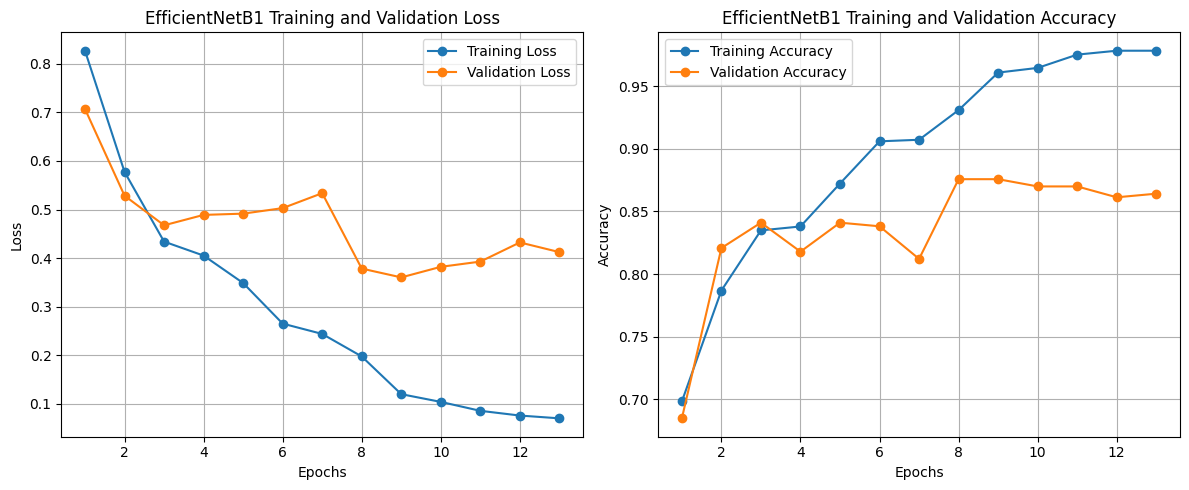


--- Evaluating EfficientNetB1 on Test Set ---
Test Accuracy for EfficientNetB1: 0.8630
Classification Report for EfficientNetB1:
              precision    recall  f1-score   support

         abn       0.89      0.83      0.86       123
         bmt       0.79      0.66      0.72        29
        malg       0.67      0.82      0.74        40
         nml       0.92      0.94      0.93        65
         stn       0.90      0.94      0.92        86

    accuracy                           0.86       343
   macro avg       0.84      0.84      0.83       343
weighted avg       0.87      0.86      0.86       343



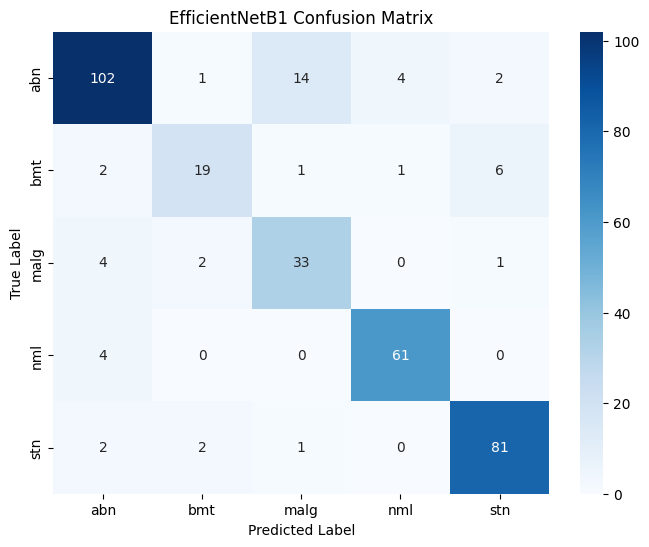

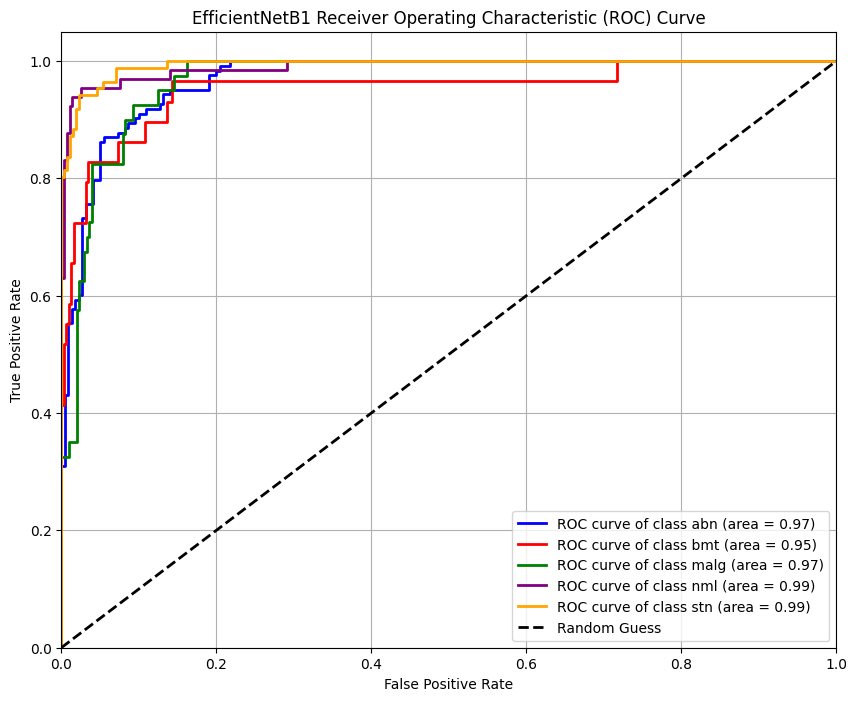

In [ ]:
clean_memory()
efficientnet_b1_model = get_model("efficientnet_b1", num_classes=len(class_names))
save_path_b1 = f"saved_models/efficientnet_b1.pth"

if load_model_weights(efficientnet_b1_model, save_path_b1, device):
    print(f"Loaded EfficientNetB1 from disk.")
    trained_efficientnet_b1_model = efficientnet_b1_model
    train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1 = [], [], [], [] # Dummy history
else:
    trained_efficientnet_b1_model, train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1 = train_model(efficientnet_b1_model, "EfficientNetB1", epochs=30, patience=5)
    save_model_weights(trained_efficientnet_b1_model, save_path_b1)

# Plot only if we have history (trained now)
if len(train_loss_eb1) > 0:
    plot_accuracy_loss(train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1, "EfficientNetB1")

y_true_eb1, y_pred_classes_eb1, y_pred_scores_eb1 = evaluate_model_on_test(trained_efficientnet_b1_model, "EfficientNetB1")
plot_confusion_matrix(y_true_eb1, y_pred_classes_eb1, class_names, "EfficientNetB1")
plot_roc_curve(label_binarize(y_true_eb1, classes=list(range(NUM_CLASSES))), y_pred_scores_eb1, NUM_CLASSES, class_names, "EfficientNetB1")
all_trained_models.append(trained_efficientnet_b1_model)


### EfficientNet-B2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:03<00:00, 11.6MB/s]



--- Training EfficientNetB2 ---
Epoch 0/29
----------
training Loss: 0.7988 Acc: 0.6885
validation Loss: 0.7565 Acc: 0.7081
Epoch 1/29
----------
training Loss: 0.6005 Acc: 0.7826
validation Loss: 0.5885 Acc: 0.7803
Epoch 2/29
----------
training Loss: 0.4687 Acc: 0.8087
validation Loss: 0.5065 Acc: 0.8208
Epoch 3/29
----------
training Loss: 0.4209 Acc: 0.8548
validation Loss: 0.5453 Acc: 0.8237
Epoch 4/29
----------
training Loss: 0.3647 Acc: 0.8548
validation Loss: 0.5556 Acc: 0.8035
Epoch 5/29
----------
training Loss: 0.3390 Acc: 0.8779
validation Loss: 0.4982 Acc: 0.8324
Epoch 6/29
----------
training Loss: 0.2803 Acc: 0.8910
validation Loss: 0.6994 Acc: 0.7948
Epoch 7/29
----------
training Loss: 0.1855 Acc: 0.9321
validation Loss: 0.4560 Acc: 0.8555
Epoch 8/29
----------
training Loss: 0.1447 Acc: 0.9477
validation Loss: 0.4334 Acc: 0.8699
Epoch 9/29
----------
training Loss: 0.1109 Acc: 0.9601
validation Loss: 0.4319 Acc: 0.8815
Epoch 10/29
----------
training Loss: 0.1047 Ac

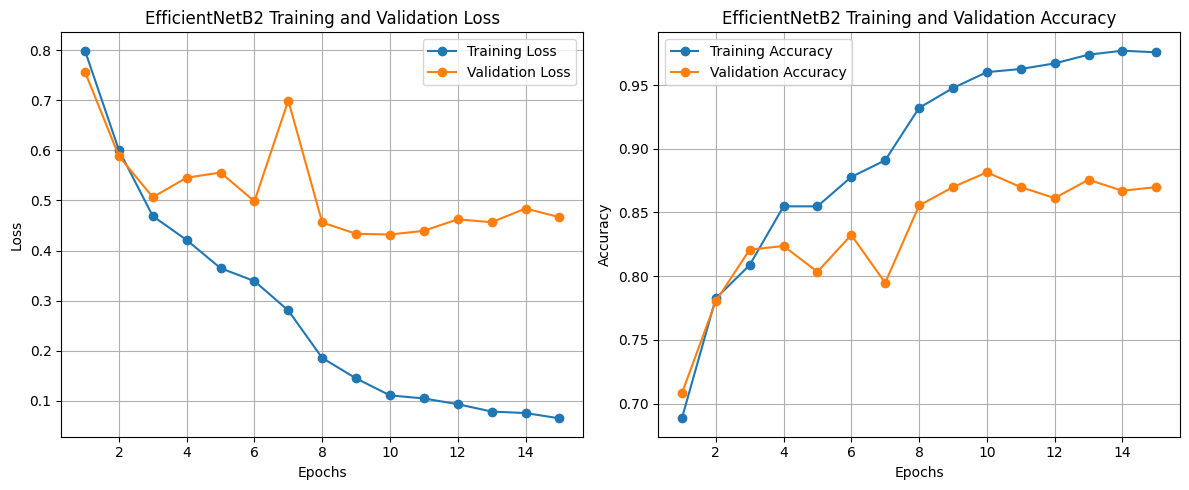


--- Evaluating EfficientNetB2 on Test Set ---
Test Accuracy for EfficientNetB2: 0.8630
Classification Report for EfficientNetB2:
              precision    recall  f1-score   support

         abn       0.91      0.84      0.87       123
         bmt       0.76      0.66      0.70        29
        malg       0.63      0.85      0.72        40
         nml       0.97      0.92      0.94        65
         stn       0.90      0.93      0.91        86

    accuracy                           0.86       343
   macro avg       0.83      0.84      0.83       343
weighted avg       0.87      0.86      0.87       343



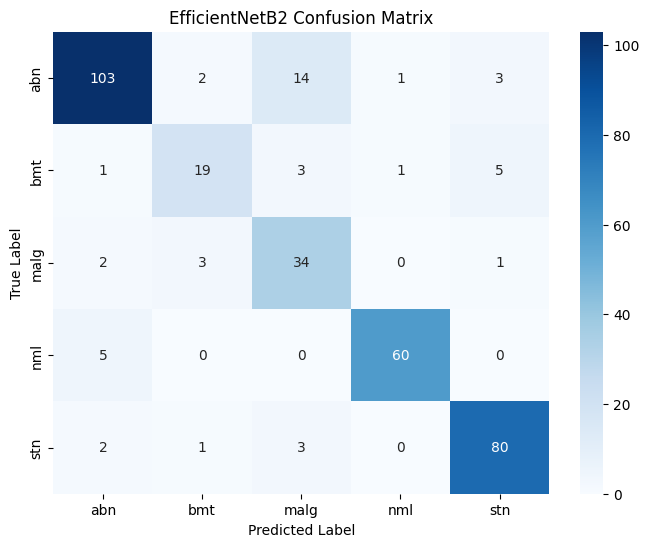

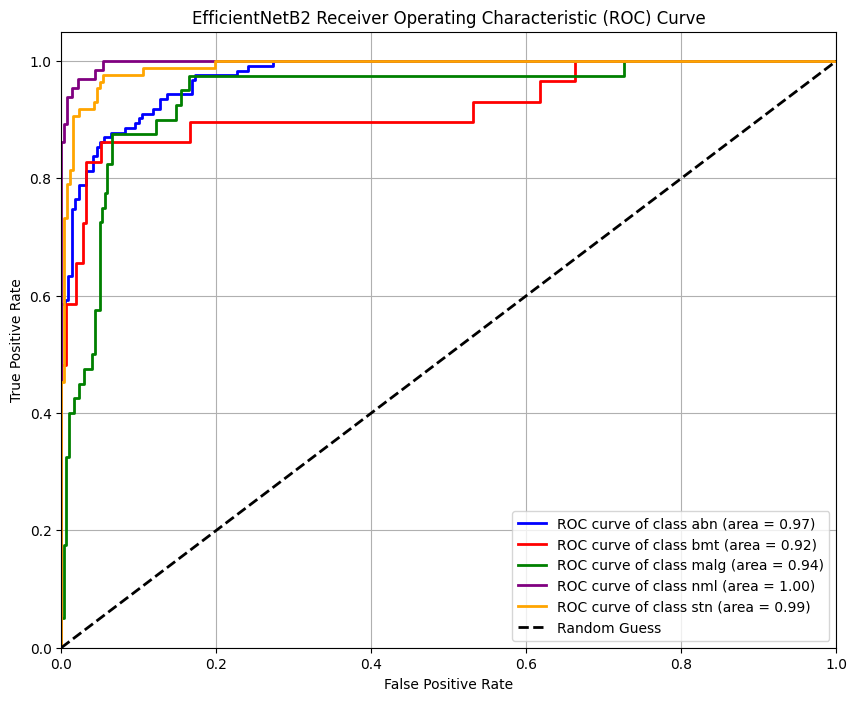

In [ ]:
clean_memory()
efficientnet_b2_model = get_model("efficientnet_b2", num_classes=len(class_names))
save_path_b2 = f"saved_models/efficientnet_b2.pth"

if load_model_weights(efficientnet_b2_model, save_path_b2, device):
    print(f"Loaded EfficientNetB2 from disk.")
    trained_efficientnet_b2_model = efficientnet_b2_model
    train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2 = [], [], [], [] # Dummy history
else:
    trained_efficientnet_b2_model, train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2 = train_model(efficientnet_b2_model, "EfficientNetB2", epochs=30, patience=5)
    save_model_weights(trained_efficientnet_b2_model, save_path_b2)

# Plot only if we have history (trained now)
if len(train_loss_eb2) > 0:
    plot_accuracy_loss(train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2, "EfficientNetB2")

y_true_eb2, y_pred_classes_eb2, y_pred_scores_eb2 = evaluate_model_on_test(trained_efficientnet_b2_model, "EfficientNetB2")
plot_confusion_matrix(y_true_eb2, y_pred_classes_eb2, class_names, "EfficientNetB2")
plot_roc_curve(label_binarize(y_true_eb2, classes=list(range(NUM_CLASSES))), y_pred_scores_eb2, NUM_CLASSES, class_names, "EfficientNetB2")
all_trained_models.append(trained_efficientnet_b2_model)


### EfficientNet-B3

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:04<00:00, 11.6MB/s]



--- Training EfficientNetB3 ---
Epoch 0/29
----------
training Loss: 0.8061 Acc: 0.6972
validation Loss: 0.6571 Acc: 0.7861
Epoch 1/29
----------
training Loss: 0.5457 Acc: 0.8100
validation Loss: 0.6241 Acc: 0.8064
Epoch 2/29
----------
training Loss: 0.4325 Acc: 0.8380
validation Loss: 0.5235 Acc: 0.8121
Epoch 3/29
----------
training Loss: 0.3650 Acc: 0.8648
validation Loss: 0.4723 Acc: 0.8092
Epoch 4/29
----------
training Loss: 0.3368 Acc: 0.8773
validation Loss: 0.4698 Acc: 0.8584
Epoch 5/29
----------
training Loss: 0.2957 Acc: 0.8941
validation Loss: 0.4798 Acc: 0.8295
Epoch 6/29
----------
training Loss: 0.3144 Acc: 0.8903
validation Loss: 0.4050 Acc: 0.8468
Epoch 7/29
----------
training Loss: 0.1613 Acc: 0.9495
validation Loss: 0.3765 Acc: 0.8526
Epoch 8/29
----------
training Loss: 0.1429 Acc: 0.9514
validation Loss: 0.3732 Acc: 0.8642
Epoch 9/29
----------
training Loss: 0.1161 Acc: 0.9626
validation Loss: 0.4062 Acc: 0.8613
Epoch 10/29
----------
training Loss: 0.1032 Ac

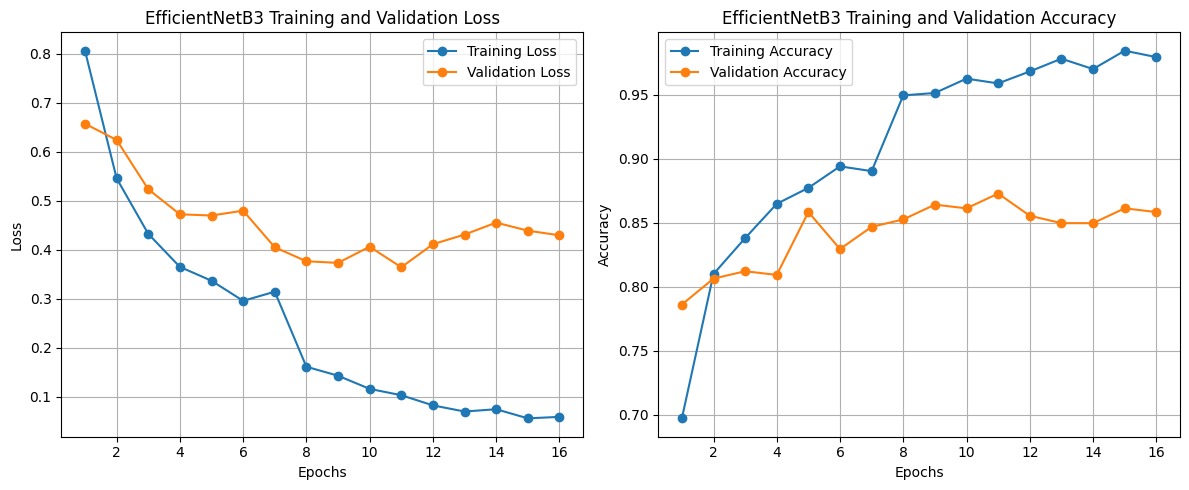


--- Evaluating EfficientNetB3 on Test Set ---
Test Accuracy for EfficientNetB3: 0.8717
Classification Report for EfficientNetB3:
              precision    recall  f1-score   support

         abn       0.91      0.87      0.89       123
         bmt       0.73      0.66      0.69        29
        malg       0.63      0.78      0.70        40
         nml       0.95      0.94      0.95        65
         stn       0.94      0.94      0.94        86

    accuracy                           0.87       343
   macro avg       0.83      0.84      0.83       343
weighted avg       0.88      0.87      0.87       343



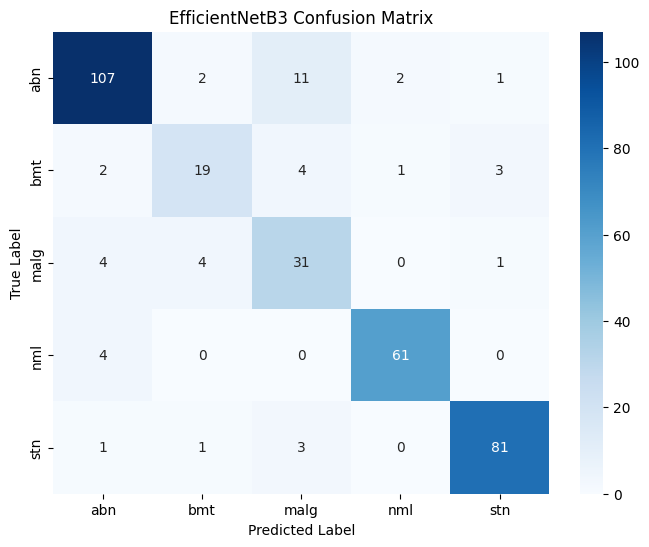

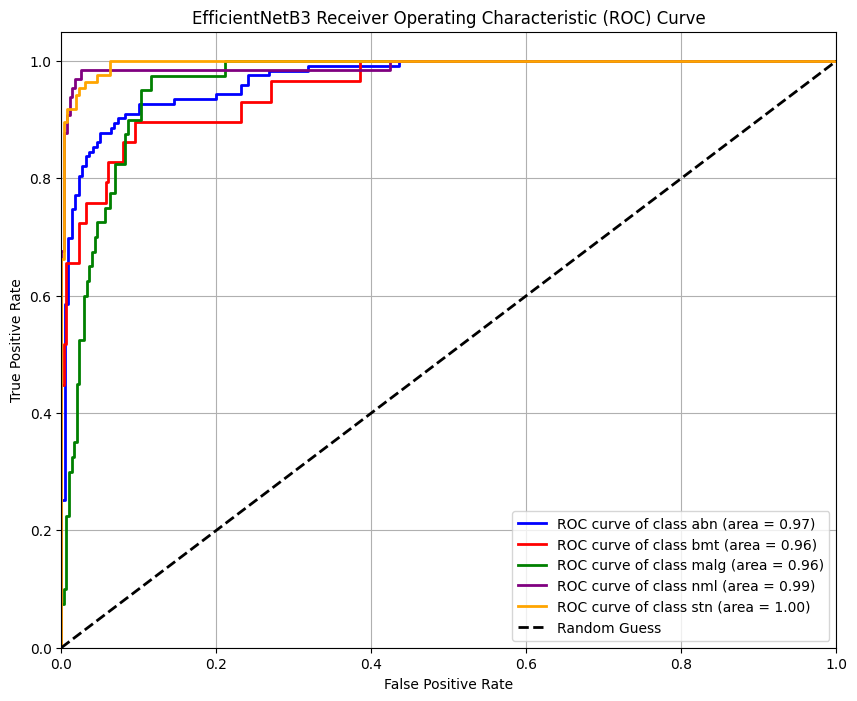

In [ ]:
clean_memory()
efficientnet_b3_model = get_model("efficientnet_b3", num_classes=len(class_names))
save_path_b3 = f"saved_models/efficientnet_b3.pth"

if load_model_weights(efficientnet_b3_model, save_path_b3, device):
    print(f"Loaded EfficientNetB3 from disk.")
    trained_efficientnet_b3_model = efficientnet_b3_model
    train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3 = [], [], [], [] # Dummy history
else:
    trained_efficientnet_b3_model, train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3 = train_model(efficientnet_b3_model, "EfficientNetB3", epochs=30, patience=5)
    save_model_weights(trained_efficientnet_b3_model, save_path_b3)

# Plot only if we have history (trained now)
if len(train_loss_eb3) > 0:
    plot_accuracy_loss(train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3, "EfficientNetB3")

y_true_eb3, y_pred_classes_eb3, y_pred_scores_eb3 = evaluate_model_on_test(trained_efficientnet_b3_model, "EfficientNetB3")
plot_confusion_matrix(y_true_eb3, y_pred_classes_eb3, class_names, "EfficientNetB3")
plot_roc_curve(label_binarize(y_true_eb3, classes=list(range(NUM_CLASSES))), y_pred_scores_eb3, NUM_CLASSES, class_names, "EfficientNetB3")
all_trained_models.append(trained_efficientnet_b3_model)


### EfficientNet-B4

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:06<00:00, 11.6MB/s]



--- Training EfficientNetB4 ---
Epoch 0/29
----------
training Loss: 0.9336 Acc: 0.6343
validation Loss: 0.5810 Acc: 0.7659
Epoch 1/29
----------
training Loss: 0.5366 Acc: 0.7975
validation Loss: 0.4956 Acc: 0.8237
Epoch 2/29
----------
training Loss: 0.3884 Acc: 0.8548
validation Loss: 0.5172 Acc: 0.8035
Epoch 3/29
----------
training Loss: 0.3208 Acc: 0.8804
validation Loss: 0.4950 Acc: 0.8179
Epoch 4/29
----------
training Loss: 0.2255 Acc: 0.9171
validation Loss: 0.6188 Acc: 0.8237
Epoch 5/29
----------
training Loss: 0.2476 Acc: 0.9059
validation Loss: 0.5349 Acc: 0.7919
Epoch 6/29
----------
training Loss: 0.2116 Acc: 0.9246
validation Loss: 0.4977 Acc: 0.8324
Epoch 7/29
----------
training Loss: 0.1412 Acc: 0.9533
validation Loss: 0.4646 Acc: 0.8410
Epoch 8/29
----------
training Loss: 0.1111 Acc: 0.9583
validation Loss: 0.4727 Acc: 0.8468
Epoch 9/29
----------
training Loss: 0.0846 Acc: 0.9707
validation Loss: 0.5036 Acc: 0.8295
Epoch 10/29
----------
training Loss: 0.0969 Ac

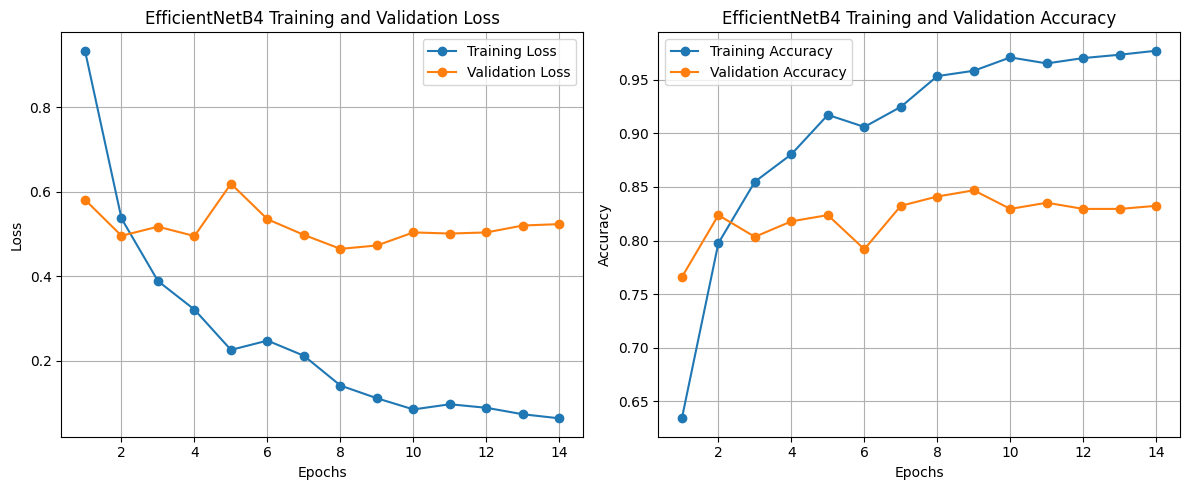


--- Evaluating EfficientNetB4 on Test Set ---
Test Accuracy for EfficientNetB4: 0.8776
Classification Report for EfficientNetB4:
              precision    recall  f1-score   support

         abn       0.91      0.86      0.89       123
         bmt       0.82      0.79      0.81        29
        malg       0.63      0.78      0.70        40
         nml       0.94      0.94      0.94        65
         stn       0.94      0.93      0.94        86

    accuracy                           0.88       343
   macro avg       0.85      0.86      0.85       343
weighted avg       0.88      0.88      0.88       343



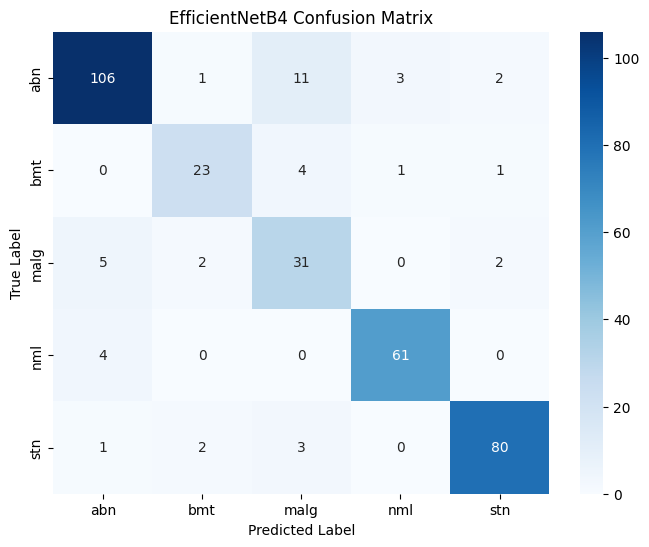

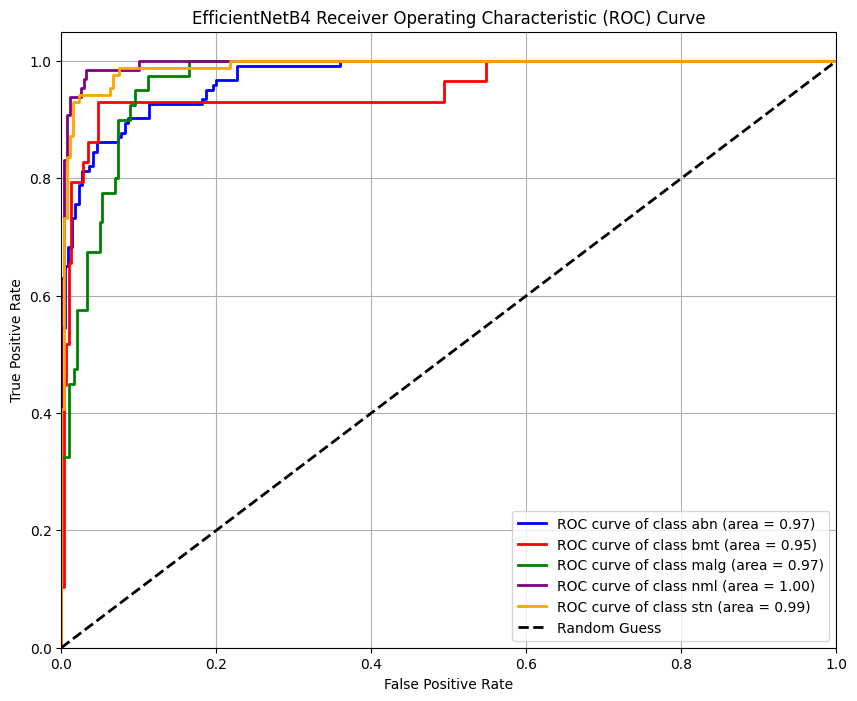

In [ ]:
clean_memory()
efficientnet_b4_model = get_model("efficientnet_b4", num_classes=len(class_names))
save_path_b4 = f"saved_models/efficientnet_b4.pth"

if load_model_weights(efficientnet_b4_model, save_path_b4, device):
    print(f"Loaded EfficientNetB4 from disk.")
    trained_efficientnet_b4_model = efficientnet_b4_model
    train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4 = [], [], [], [] # Dummy history
else:
    trained_efficientnet_b4_model, train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4 = train_model(efficientnet_b4_model, "EfficientNetB4", epochs=30, patience=5)
    save_model_weights(trained_efficientnet_b4_model, save_path_b4)

# Plot only if we have history (trained now)
if len(train_loss_eb4) > 0:
    plot_accuracy_loss(train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4, "EfficientNetB4")

y_true_eb4, y_pred_classes_eb4, y_pred_scores_eb4 = evaluate_model_on_test(trained_efficientnet_b4_model, "EfficientNetB4")
plot_confusion_matrix(y_true_eb4, y_pred_classes_eb4, class_names, "EfficientNetB4")
plot_roc_curve(label_binarize(y_true_eb4, classes=list(range(NUM_CLASSES))), y_pred_scores_eb4, NUM_CLASSES, class_names, "EfficientNetB4")
all_trained_models.append(trained_efficientnet_b4_model)


### Ensemble Evaluation


--- Performing Ensemble Evaluation ---
Ensemble Test Accuracy: 0.8834
Ensemble Classification Report:
              precision    recall  f1-score   support

         abn       0.92      0.86      0.89       123
         bmt       0.81      0.76      0.79        29
        malg       0.67      0.85      0.75        40
         nml       0.92      0.94      0.93        65
         stn       0.95      0.93      0.94        86

    accuracy                           0.88       343
   macro avg       0.86      0.87      0.86       343
weighted avg       0.89      0.88      0.89       343



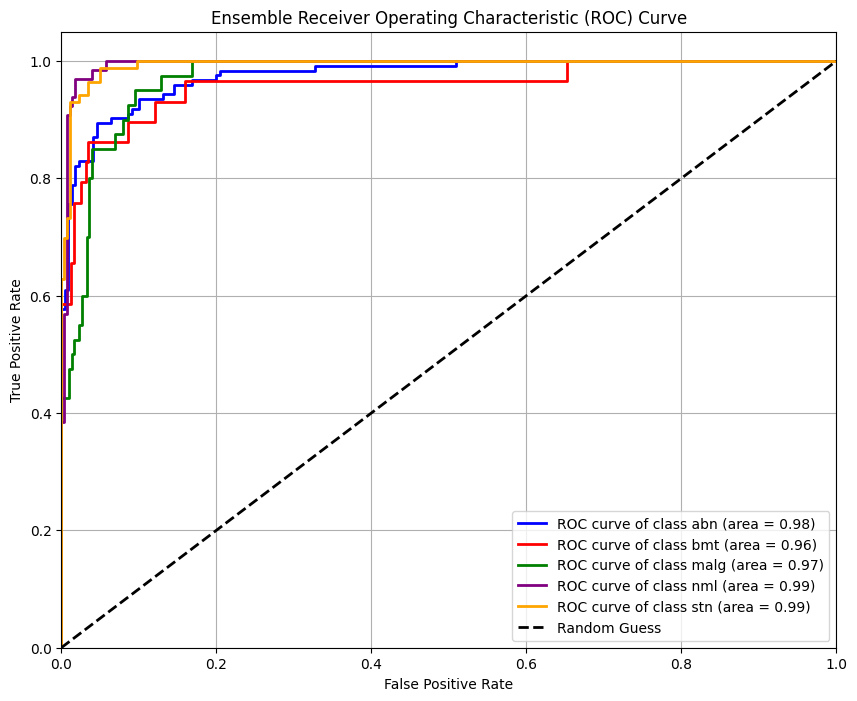

In [ ]:
ensemble_accuracy, ensemble_probs, y_true_ensemble = ensemble_evaluate(all_trained_models, test_loader, class_names, device)
model_results["Ensemble"] = ensemble_accuracy
plot_roc_curve(label_binarize(y_true_ensemble, classes=list(range(NUM_CLASSES))), ensemble_probs, NUM_CLASSES, class_names, "Ensemble")

### Table

In [ ]:
print("\nModel Performance Summary (Including Ensemble - All Test Accuracies):\\n")
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Test Accuracy"])
results_df["Test Accuracy"] = results_df["Test Accuracy"].apply(lambda x: f"{x*100:.2f}%")
results_df = results_df.sort_values(by="Test Accuracy", ascending=False) # Sort by accuracy

print(results_df.to_string(index=False))


Model Performance Summary (Including Ensemble - All Test Accuracies):\n
         Model Test Accuracy
      Ensemble        88.34%
EfficientNetB0        87.76%
EfficientNetB4        87.76%
EfficientNetB3        87.17%
  ShuffleNetV2        86.88%
   DenseNet121        86.30%
EfficientNetB1        86.30%
EfficientNetB2        86.30%
      ResNet18        86.01%
   DenseNet201        85.71%
    ResNet50V1        85.71%
    ResNet50V2        85.71%
    SqueezeNet        75.80%
   MobileNetV2        71.72%
        GBCNet        61.22%


Weights for weighted ensemble: [0.16917028 0.16750969 0.16750969 0.16693707 0.16527648 0.1635968 ]

Weighted Ensemble Test Accuracy: 88.63%
Classification Report:
              precision    recall  f1-score   support

         abn       0.92      0.88      0.90       123
         bmt       0.78      0.72      0.75        29
        malg       0.67      0.85      0.75        40
         nml       0.97      0.94      0.95        65
         stn       0.94      0.93      0.94        86

    accuracy                           0.89       343
   macro avg       0.86      0.86      0.86       343
weighted avg       0.89      0.89      0.89       343



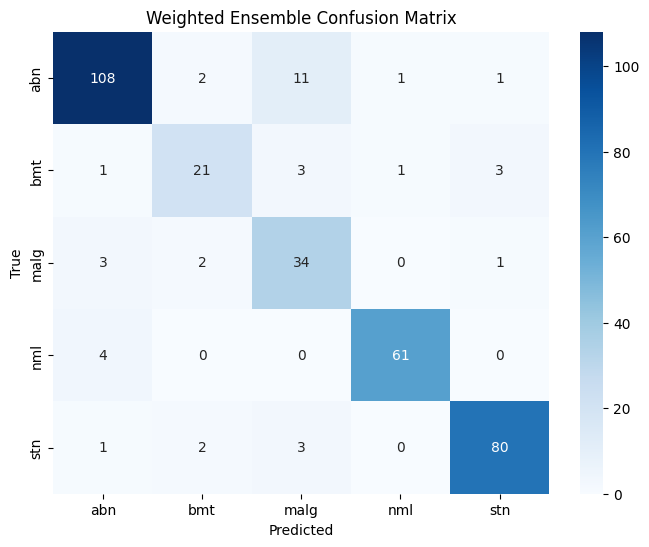

In [ ]:

# --------------------------
# Selected models and weights
# --------------------------
selected_models = [
    ("EfficientNetB2", efficientnet_b2_model),
    ("EfficientNetB1", efficientnet_b1_model),
    ("EfficientNetB3", efficientnet_b3_model),
    ("EfficientNetB0", efficientnet_b0_model),
    ("EfficientNetB4", efficientnet_b4_model),
    ("MobileNetV2", mobilenet_v2_model)
]

# Test accuracies of selected models
selected_accs = np.array([0.8863, 0.8776, 0.8776, 0.8746, 0.8659, 0.8571])
weights = selected_accs / selected_accs.sum()
print("Weights for weighted ensemble:", weights)

# --------------------------
# Weighted Ensemble Prediction
# --------------------------
def weighted_ensemble_predict(models, weights, test_loader, device):
    all_preds = []
    y_true = []
    weighted_probs_list = []

    for inputs, labels in test_loader:
        if device.type == 'cuda':
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
        else:
            inputs = inputs.to(device)
            labels = labels.to(device)
        y_true.extend(labels.cpu().numpy())

        # Weighted probability sum
        weighted_probs = 0
        for (name, model), w in zip(models, weights):
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                weighted_probs += w * probs

        weighted_probs_list.extend(weighted_probs)
        all_preds.extend(np.argmax(weighted_probs, axis=1))

    ensemble_accuracy = accuracy_score(y_true, all_preds)
    print(f"\nWeighted Ensemble Test Accuracy: {ensemble_accuracy*100:.2f}%")
    print(f"Classification Report:\n{classification_report(y_true, all_preds, target_names=class_names)}")

    return ensemble_accuracy, all_preds, np.array(weighted_probs_list), y_true

# Run weighted ensemble
ensemble_accuracy, ensemble_preds, ensemble_probs, y_true_ensemble = weighted_ensemble_predict(
    selected_models, weights, test_loader, device
)

# --------------------------
# Plot Confusion Matrix
# --------------------------
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Weighted Ensemble"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true_ensemble, ensemble_preds, class_names, "Weighted Ensemble")

# --------------------------
# Plot ROC Curve
# --------------------------
def plot_roc_curve(y_true, y_pred_probs, class_names, model_name="Weighted Ensemble"):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10,8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0,1], [0,1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")

    plt.grid(True)
    plt.show()


# Call the ROC plotting function for the weighted ensemble
plot_roc_curve(y_true_ensemble, ensemble_probs, class_names, "Weighted Ensemble")

extra


In [101]:
# --- KG export for ResNet18 (diagnostic + model-concept + hybrid) ---
# This cell is safe and runs only on existing objects produced by your ResNet18 run.
import os
import shutil
try:
    import networkx as nx
except Exception as e:
    print("Optional: install 'networkx' to enable KG export: pip install networkx", e)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
from PIL import Image as PilImage

OUT_DIR = Path.cwd() / "kg_artifacts"
OUT_DIR.mkdir(exist_ok=True)


def extract_embeddings_for_model(model, dataloader, device, max_batches=6):
    model.eval()
    embs = []
    labels = []
    paths = []

    with torch.no_grad():
        for batch_idx, (inputs, lbs) in enumerate(dataloader):
            if batch_idx >= max_batches:
                break
            bs = inputs.size(0)
            inputs = inputs.to(device)
            try:
                if hasattr(model, 'features'):
                    out = model.features(inputs)
                    feat = torch.flatten(out, 1)
                elif hasattr(model, 'forward_features'):
                    out = model.forward_features(inputs)
                    if torch.is_tensor(out):
                        feat = torch.flatten(out, 1)
                    else:
                        feat = torch.as_tensor(out)
                else:
                    out = model(inputs)
                    feat = torch.flatten(out, 1)
            except Exception:
                out = model(inputs)
                feat = torch.flatten(out, 1)

            feat_np = feat.detach().cpu().numpy()
            embs.append(feat_np)
            labels.extend(lbs.cpu().numpy())

            # collect file paths from dataset samples (assumes ImageFolder)
            start = batch_idx * dataloader.batch_size
            for i in range(bs):
                idx = start + i
                if idx < len(dataloader.dataset.samples):
                    p, _ = dataloader.dataset.samples[idx]
                    paths.append(p)
                else:
                    paths.append(None)

    if len(embs) == 0:
        return np.zeros((0,)), np.array([]), []
    embs = np.vstack(embs)
    return embs, np.array(labels), paths


def build_and_save_model_concept_graph(name, model, dataloader, device, out_prefix, n_clusters=6, max_batches=6):
    """
    Builds a model-concept graph by extracting embeddings, optionally clustering them, and saving:
      - {out_prefix}.graphml
      - {out_prefix}.png (network visualization)
      - {out_prefix}_pca.png (PCA scatter colored by cluster)
      - {out_prefix}_samples/ (up to 3 thumbnails per cluster)

    n_clusters can be:
      - int: use KMeans with that many clusters
      - 'auto': use silhouette search to pick k (2..min(12, n_samples-1))
      - 'all': treat each sample as its own cluster (cluster id = sample index)
    """
    embs, labels, paths = extract_embeddings_for_model(model, dataloader, device, max_batches=max_batches)
    if embs.shape[0] == 0:
        print("No embeddings extracted; skipping model-concept graph.")
        return None

    # Standardize and reduce dimensionality for clustering/visualization
    sc = StandardScaler()
    e = sc.fit_transform(embs)
    n_comp = min(50, e.shape[1])
    pca = PCA(n_components=n_comp)
    e_p = pca.fit_transform(e)

    n_samples = e_p.shape[0]

    # Determine clusters robustly
    chosen_k = None
    if isinstance(n_clusters, str) and n_clusters == 'all':
        # each sample is its own cluster
        cl_labels = np.arange(n_samples)
        chosen_k = n_samples
        print(f"Using 'all' mode: creating {chosen_k} clusters (one per sample)")
    elif isinstance(n_clusters, str) and n_clusters == 'auto':
        # silhouette-based k selection
        from sklearn.metrics import silhouette_score
        best_k = None
        best_s = -1
        max_k = min(12, max(2, n_samples - 1))
        for k in range(2, max_k + 1):
            try:
                labels_k = KMeans(n_clusters=k, random_state=42).fit_predict(e_p)
                if len(np.unique(labels_k)) > 1:
                    s = silhouette_score(e_p, labels_k)
                    if s > best_s:
                        best_s = s
                        best_k = k
            except Exception:
                continue
        if best_k is None:
            best_k = min(6, max(1, n_samples))
        chosen_k = best_k
        print(f"Auto-selected k={chosen_k} (silhouette={best_s if best_s is not None else 'NA'})")
        km = KMeans(n_clusters=chosen_k, random_state=42).fit(e_p)
        cl_labels = km.labels_
    else:
        # explicit integer (or convertible string)
        try:
            k = int(n_clusters)
        except Exception:
            k = 6
        k = max(1, min(k, n_samples))
        chosen_k = k
        if k == 1:
            cl_labels = np.zeros(n_samples, dtype=int)
        else:
            km = KMeans(n_clusters=k, random_state=42).fit(e_p)
            cl_labels = km.labels_
        print(f"Using k={chosen_k} clusters")

    # Build graph
    G = nx.Graph()
    model_node = f"model:{name}"
    G.add_node(model_node, type='model', label=name)

    sample_dir = OUT_DIR / f"{out_prefix}_samples"
    sample_dir.mkdir(parents=True, exist_ok=True)

    for c in np.unique(cl_labels):
        node_id = f"{name}:cluster:{c}"
        idxs = np.where(cl_labels == c)[0]
        support = int(len(idxs))
        counts = Counter(labels[idxs]) if len(idxs) > 0 else Counter()
        if len(counts) > 0:
            majority_label, majority_count = counts.most_common(1)[0]
        else:
            majority_label, majority_count = -1, 0

        G.add_node(node_id, type='cluster', model=name, cluster=int(c), support=support,
                   majority_label=int(majority_label) if majority_label is not None else -1,
                   majority_support=int(majority_count))
        G.add_edge(model_node, node_id)

        # Connect to class node if possible
        if isinstance(majority_label, (int, np.integer)) and 0 <= majority_label < len(class_names):
            class_node = f"class:{majority_label}"
            if not G.has_node(class_node):
                G.add_node(class_node, type='class', label=class_names[majority_label])
            G.add_edge(node_id, class_node, weight=float(majority_count) / max(1, support))

        # save up to 3 sample thumbnails per cluster
        for ii in idxs[:3]:
            img_node = f"{name}:img:{ii}"
            img_path = paths[ii] if ii < len(paths) else None
            true_lab = int(labels[ii]) if ii < len(labels) else -1
            G.add_node(img_node, type='image', sample_idx=int(ii), true_label=true_lab, path=str(img_path) if img_path else '')
            G.add_edge(node_id, img_node)

            if img_path and Path(img_path).exists():
                try:
                    im = PilImage.open(img_path).convert('RGB')
                    im.thumbnail((224, 224))
                    thumb_path = sample_dir / f"{name}_cluster{c}_img{ii}.png"
                    im.save(thumb_path)
                except Exception as e:
                    print('Could not save thumbnail', img_path, e)

    # save graphml
    graph_path = OUT_DIR / f"{out_prefix}.graphml"
    try:
        nx.write_graphml(G, graph_path)
    except Exception as e:
        print('Failed to write graphml:', e)

    # draw and save network visualization (may be cluttered if many clusters)
    try:
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G, k=0.3)
        types = nx.get_node_attributes(G, 'type')
        color_map = []
        size_map = []
        for n in G.nodes():
            t = types.get(n, 'other')
            if t == 'class':
                color_map.append('green'); size_map.append(400)
            elif t == 'model':
                color_map.append('red'); size_map.append(300)
            elif t == 'cluster':
                color_map.append('orange'); size_map.append(150)
            elif t == 'image':
                color_map.append('blue'); size_map.append(60)
            else:
                color_map.append('gray'); size_map.append(80)

        nx.draw(G, pos, node_color=color_map, node_size=size_map, with_labels=True, font_size=8)
        img_out = OUT_DIR / f"{out_prefix}.png"
        plt.tight_layout()
        plt.savefig(img_out)
        plt.close()
    except Exception as e:
        print('Network visualization failed:', e)

    # PCA scatter: color by cluster
    try:
        pca_out = OUT_DIR / f"{out_prefix}_pca.png"
        plt.figure(figsize=(8, 6))
        unique_clusters = np.unique(cl_labels)
        cmap = plt.get_cmap('tab20')
        for i, c in enumerate(unique_clusters):
            idxs = np.where(cl_labels == c)[0]
            color = cmap(i % 20)
            plt.scatter(e_p[idxs, 0], e_p[idxs, 1], s=30, color=color, label=f'cluster {c}')
        if len(unique_clusters) <= 20:
            plt.legend(loc='best', fontsize='small')
        plt.title(f'PCA scatter ({out_prefix})')
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.tight_layout(); plt.savefig(pca_out); plt.close()
        print('Saved PCA scatter:', pca_out)
    except Exception as e:
        print('PCA scatter failed:', e)

    img_out = OUT_DIR / f"{out_prefix}.png"
    pca_out = OUT_DIR / f"{out_prefix}_pca.png"
    print('Saved model-concept graph:', graph_path)
    print('Artifacts summary:', 'network_png=' + (str(img_out) if img_out.exists() else 'missing'), 'pca=' + (str(pca_out) if pca_out.exists() else 'missing'), 'samples_dir=' + (str(sample_dir) if sample_dir.exists() else 'missing'))
    return G


def build_and_save_diagnostic_graph(name, train_loss, train_acc, val_loss, val_acc, out_prefix):
    """Builds a diagnostic graph (epoch nodes + simple plots) and saves .graphml and .png"""
    G = nx.DiGraph()
    prev = None
    for epoch, (l, a) in enumerate(zip(train_loss, train_acc)):
        n = f"{name}:epoch:{epoch}"
        G.add_node(n, type='epoch', model=name, epoch=int(epoch), train_loss=float(l), train_acc=float(a))
        if prev is not None:
            G.add_edge(prev, n)
        prev = n

    G.add_node(f"{name}:summary", type='summary', best_val=max(val_acc) if len(val_acc) else None)
    if prev is not None:
        G.add_edge(prev, f"{name}:summary")

    graph_path = OUT_DIR / f"{out_prefix}.graphml"
    try:
        nx.write_graphml(G, graph_path)
    except Exception as e:
        print('Failed to write diagnostic graphml:', e)

    # draw simple plots for loss and accuracy
    try:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        epochs = range(1, len(train_loss) + 1)
        axes[0].plot(epochs, train_loss, 'o-', label='Training Loss')
        axes[0].plot(epochs, val_loss, 'o-', label='Validation Loss')
        axes[0].set_title(f'{name} Loss'); axes[0].legend(); axes[0].grid(True)

        axes[1].plot(epochs, train_acc, 'o-', label='Training Acc')
        axes[1].plot(epochs, val_acc, 'o-', label='Validation Acc')
        axes[1].set_title(f'{name} Accuracy'); axes[1].legend(); axes[1].grid(True)

        plt.tight_layout()
        img_out = OUT_DIR / f"{out_prefix}.png"
        plt.savefig(img_out)
        plt.close()
        print('Saved diagnostic graph:', graph_path, img_out)
    except Exception as e:
        print('Diagnostic plotting failed:', e)


    return G

In [ ]:
# Helper: verify images are readable by PIL

def check_image_paths(paths, max_checks=50):
    """Check if image files are readable by PIL. Returns list of (path, error) for bad files."""
    bad = []
    for i, p in enumerate(paths):
        if i >= max_checks:
            break
        try:
            with PilImage.open(p) as im:
                im.verify()  # verify can still leave the file open; use context manager
        except Exception as e:
            bad.append((p, repr(e)))
    print(f"Checked {min(len(paths), max_checks)} paths, bad={len(bad)}")
    return bad

# --- Persistence Helpers ---
def save_model_weights(model, path):
    """Saves the model weights to the specified path."""
    try:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(model.state_dict(), path)
        print(f"Model weights saved to {path}")
    except Exception as e:
        print(f"Error saving model weights to {path}: {e}")

def load_model_weights(model, path, device):
    """Loads model weights if they exist."""
    if os.path.exists(path):
        try:
            model.load_state_dict(torch.load(path, map_location=device))
            print(f"Loaded model weights from {path}")
            model.eval()
            return True
        except Exception as e:
            print(f"Error loading weights from {path}: {e}")
            return False
    print(f"No weights found at {path}, starting fresh.")
    return False

# --- Visualization Helpers ---
def plot_correlation_heatmap(data, title="Correlation Heatmap"):
    """Plots a correlation heatmap for the given dataframe."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.show()

def display_kg_artifacts(out_dir_path):
    """Scans OUT_DIR for *_pca.png files to identify prefixes and displays KG artifacts."""
    out_path = Path(out_dir_path)
    if not out_path.exists():
        print(f"Artifact directory {out_dir_path} does not exist.")
        return

    pca_files = list(out_path.glob("*_pca.png"))
    if not pca_files:
        print(f"No *_pca.png files found in {out_dir_path}")
        return

    prefixes = sorted(list(set([p.name.replace('_pca.png', '') for p in pca_files])))
    print(f"Found {len(prefixes)} KG prefixes; displaying PCA and network PNG for each...")

    for pref in prefixes:
        print(f"\n--- {pref}")
        pca_img = out_path / f"{pref}_pca.png"
        net_img = out_path / f"{pref}.png"
        if pca_img.exists():
            display(IPyImage(filename=str(pca_img), width=600))
        else:
            print(f"Missing PCA image: {pca_img}")
        if net_img.exists():
            display(IPyImage(filename=str(net_img), width=600))
        else:
            print(f"Missing Network image: {net_img}")



--- kg_resnet50_v1_from_training_8105


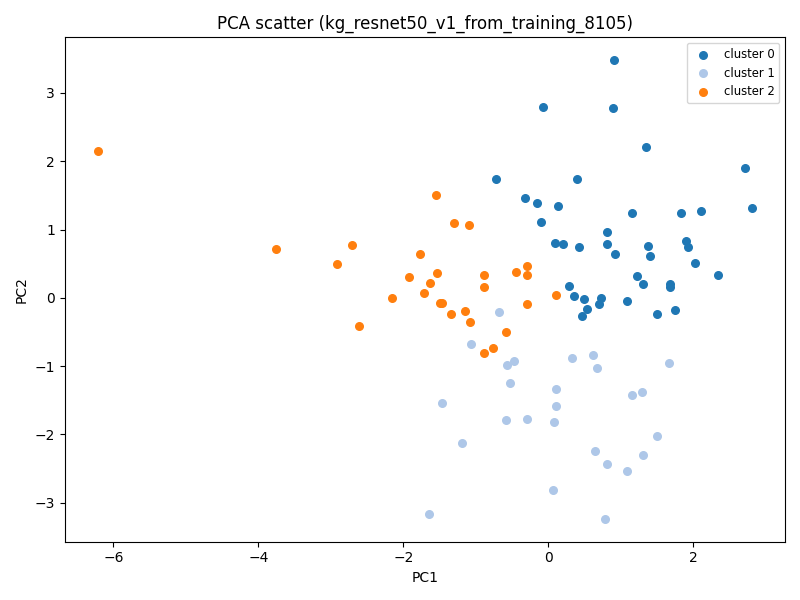

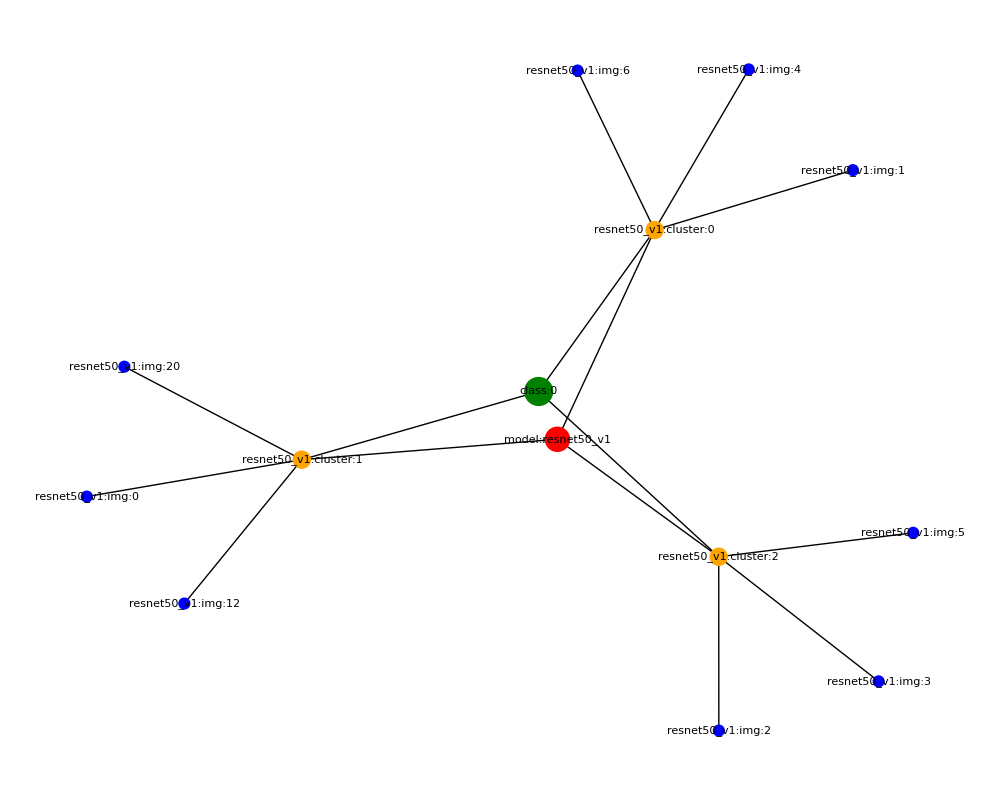


--- kg_resnet50_v2_from_training_8106


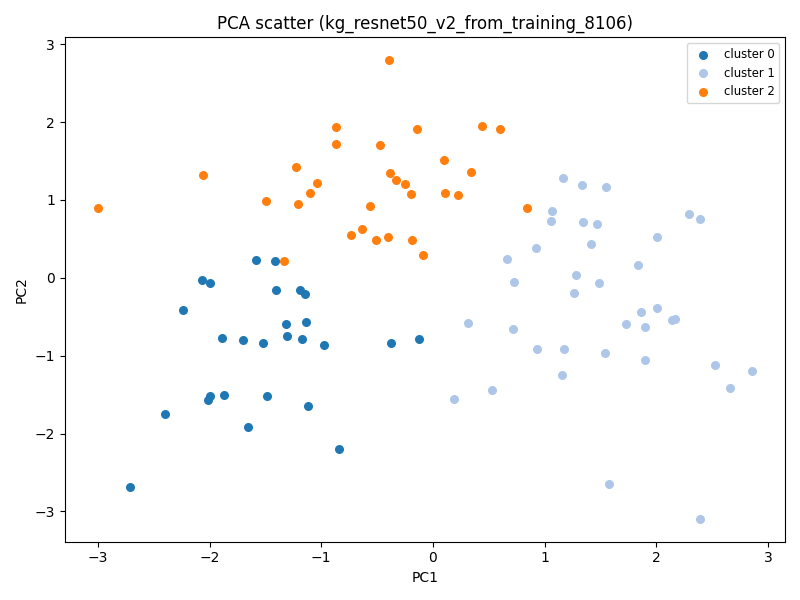

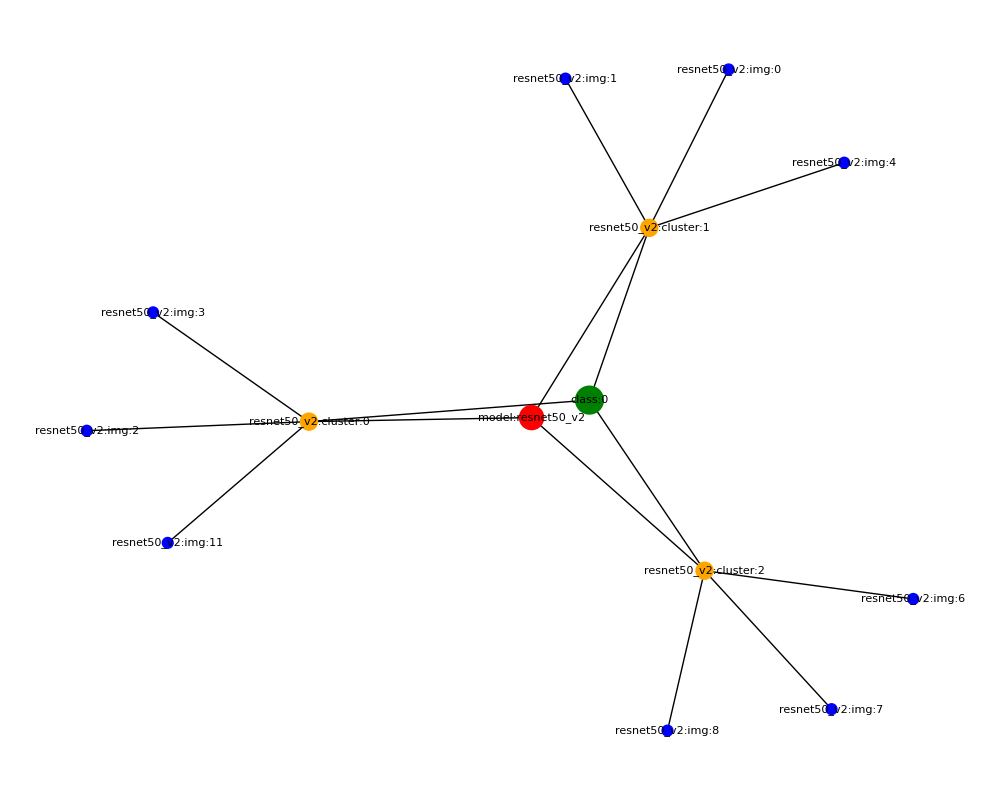

In [117]:
# Display KG Artifacts using the robust helper function
display_kg_artifacts(OUT_DIR)


Found 44 KG prefixes; displaying PCA and network PNG for each...

--- kg_densenet121_from_training_8098


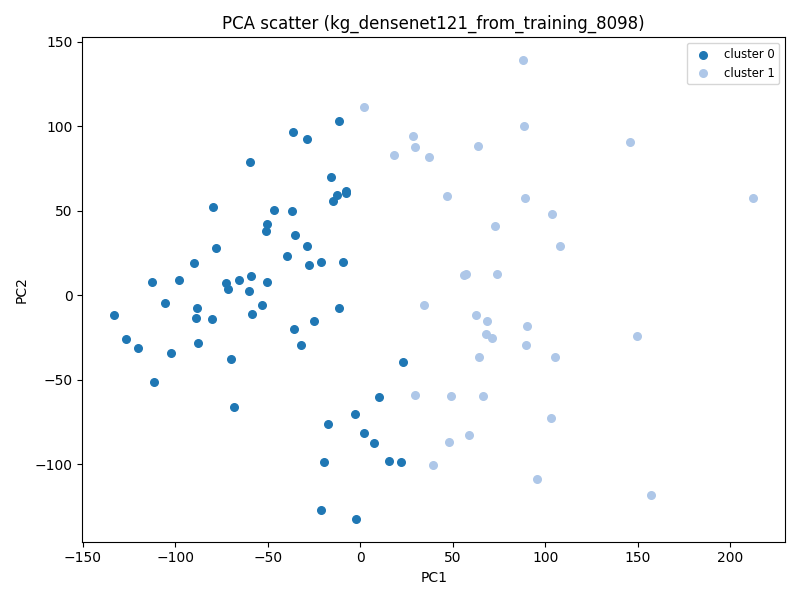

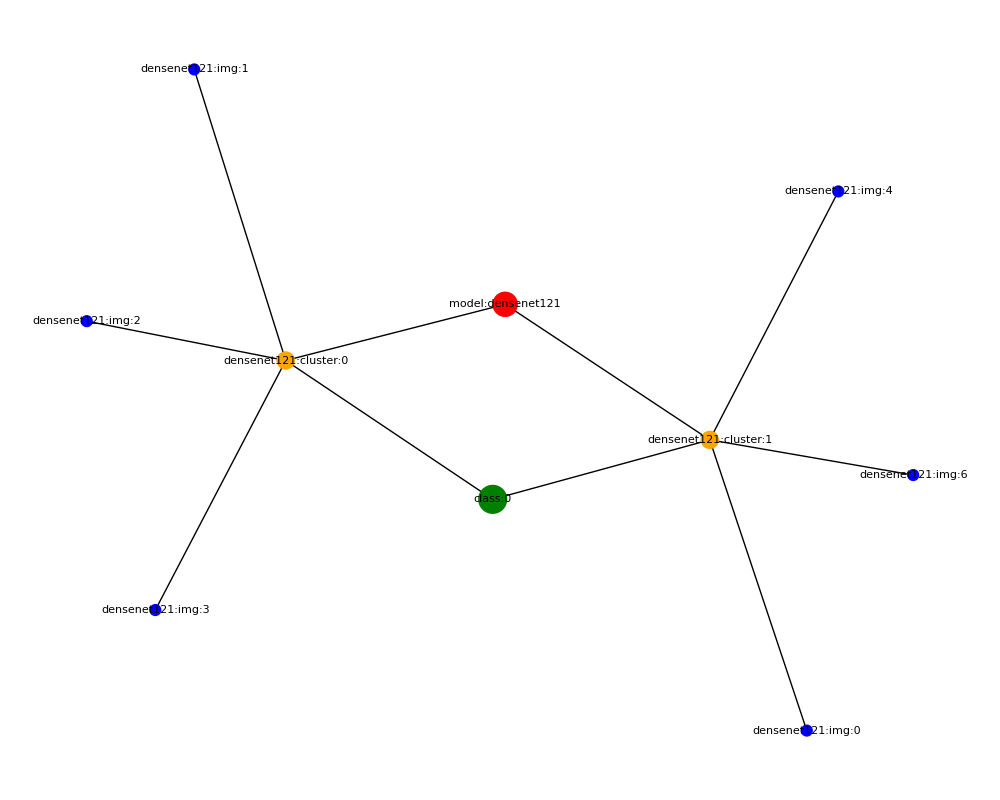


--- kg_densenet121_from_training_8185


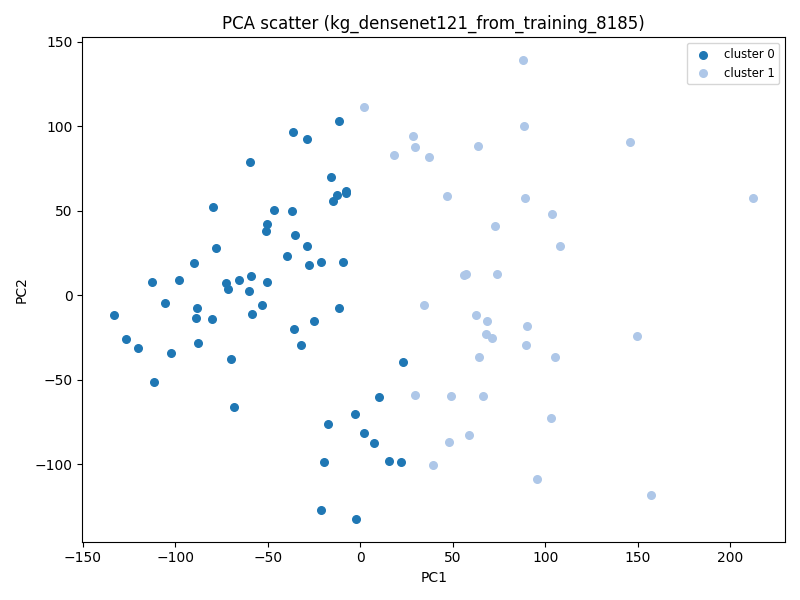

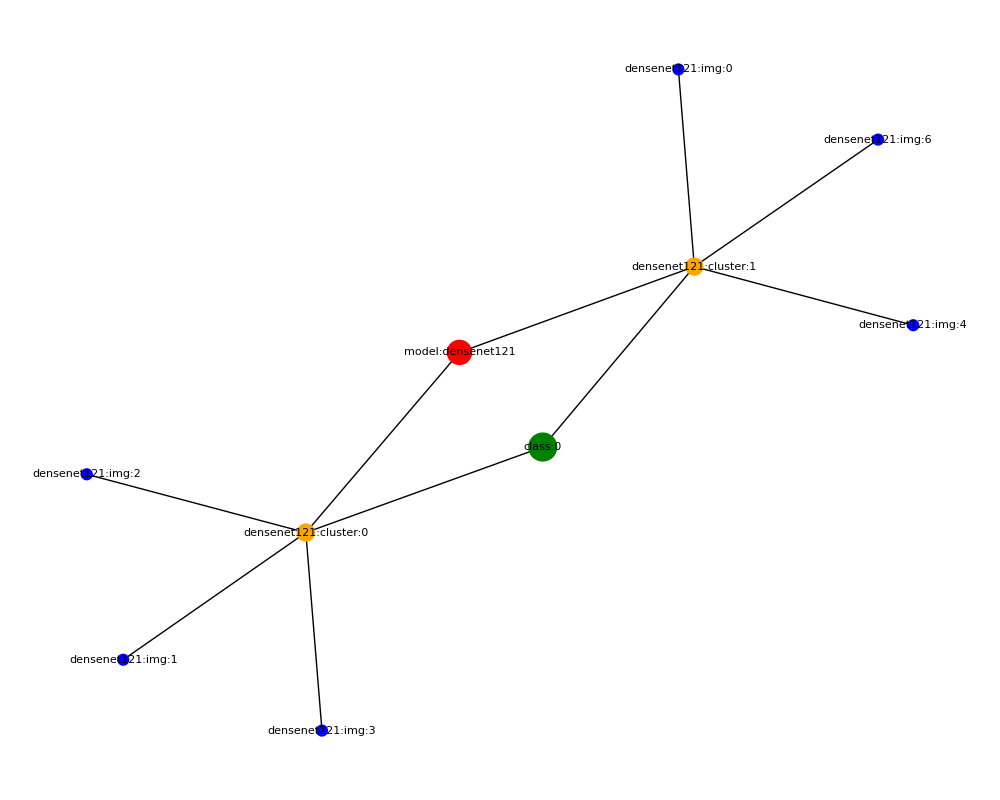


--- kg_densenet121_from_training_8265


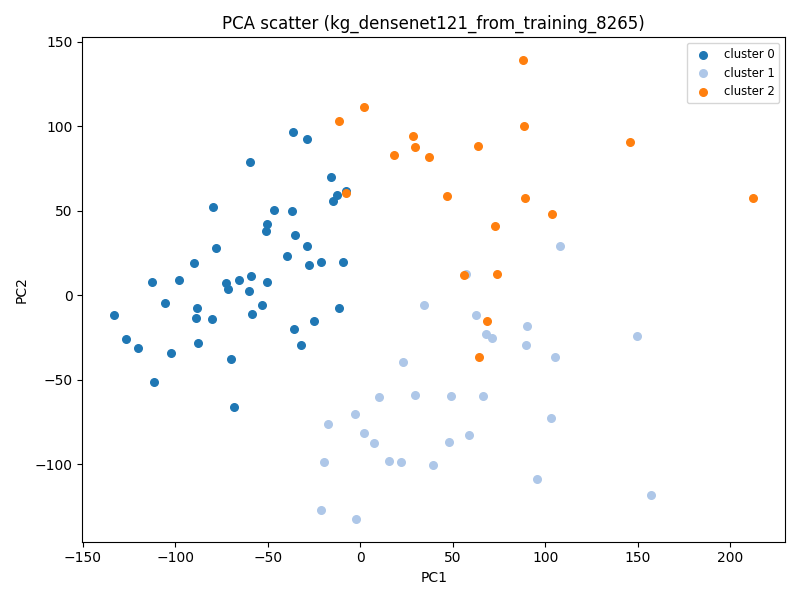

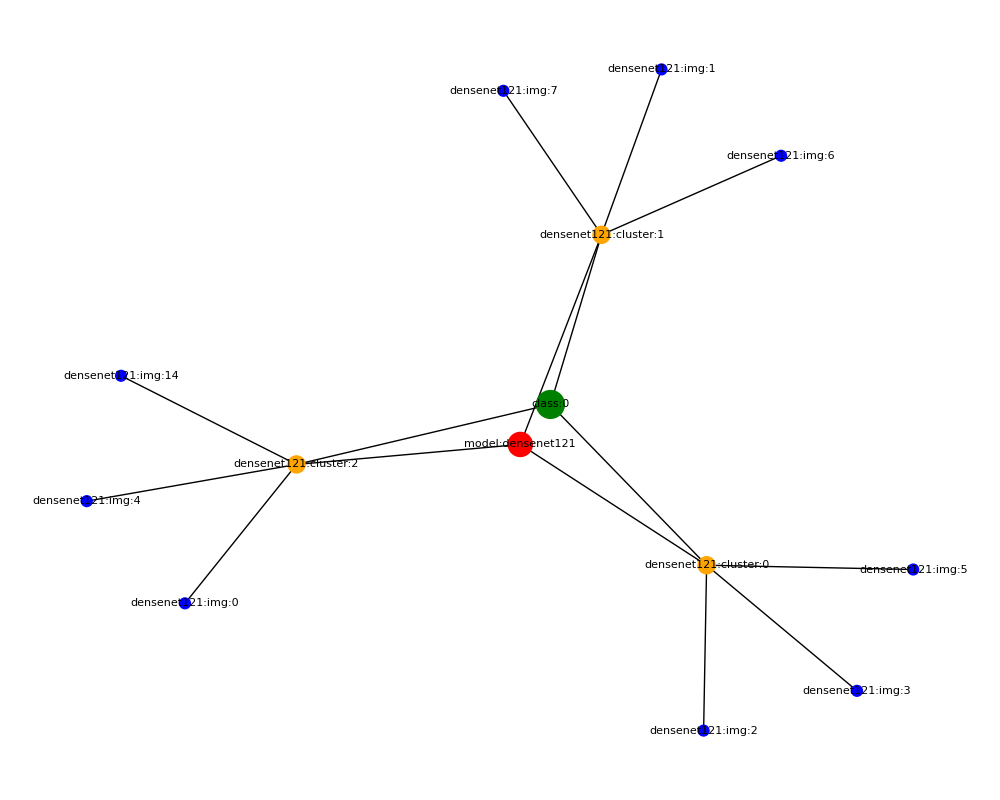


--- kg_densenet201_from_training_8099


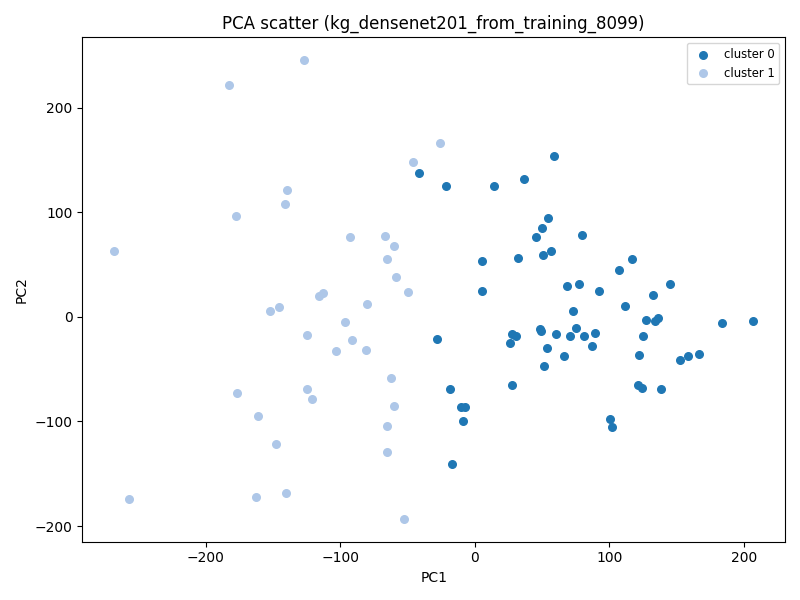

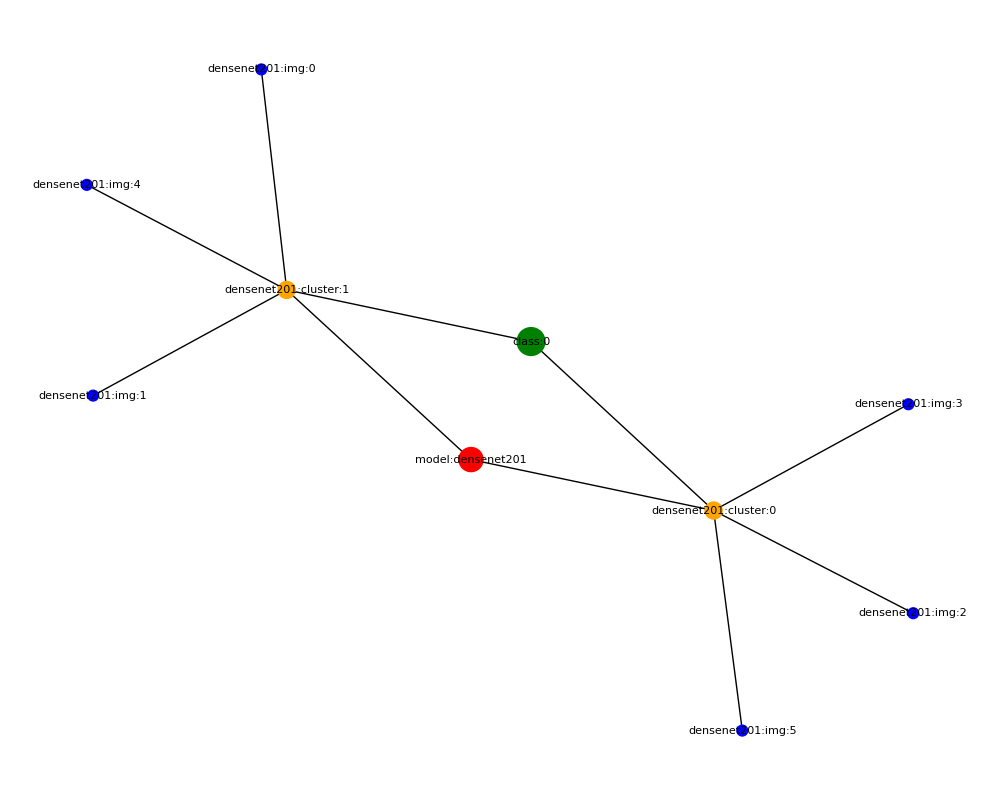


--- kg_densenet201_from_training_8187


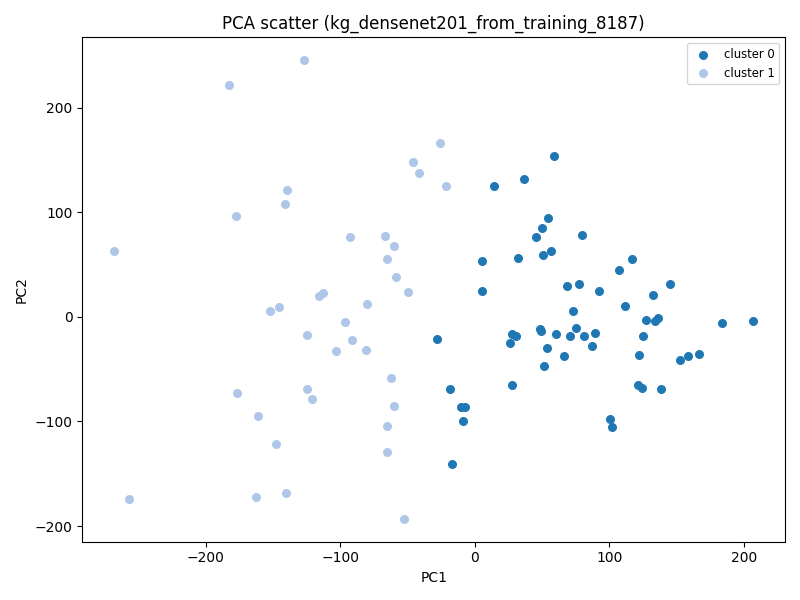

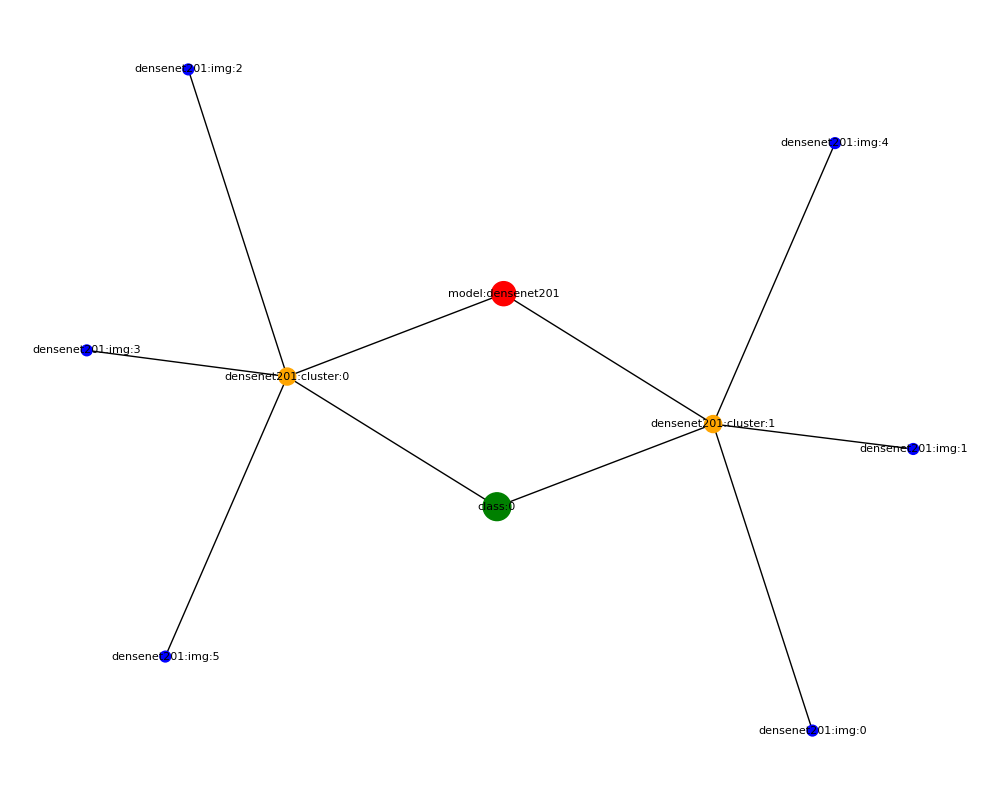


--- kg_densenet201_from_training_8267


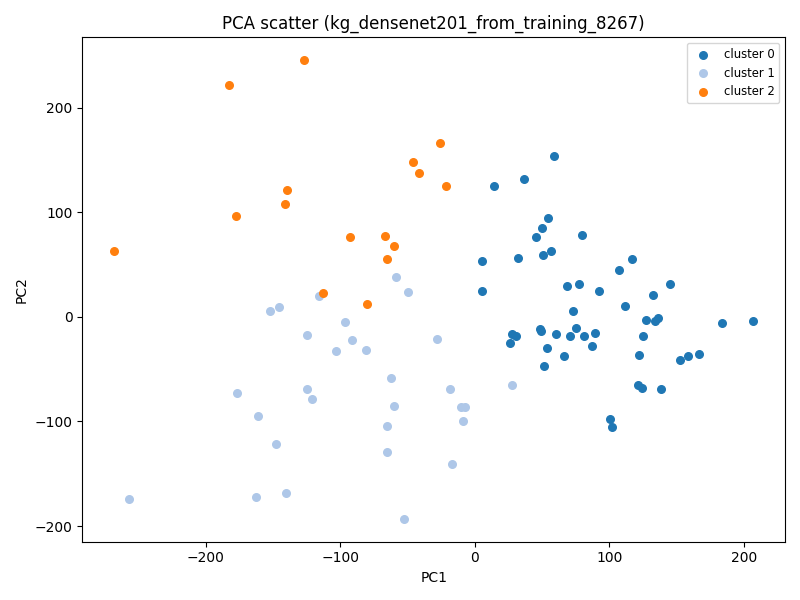

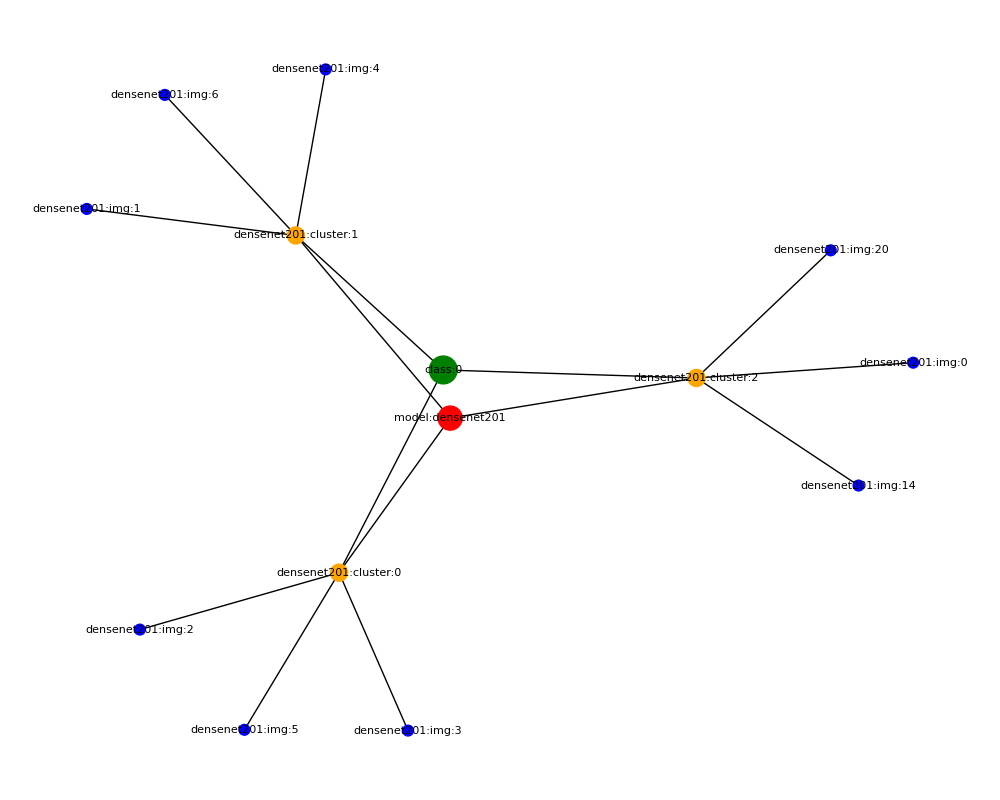


--- kg_efficientnet_b0_from_training_8091


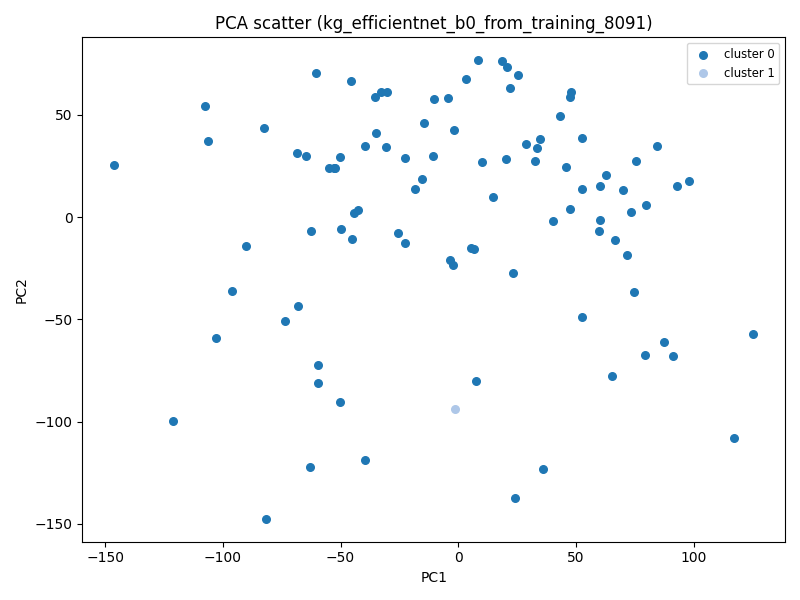

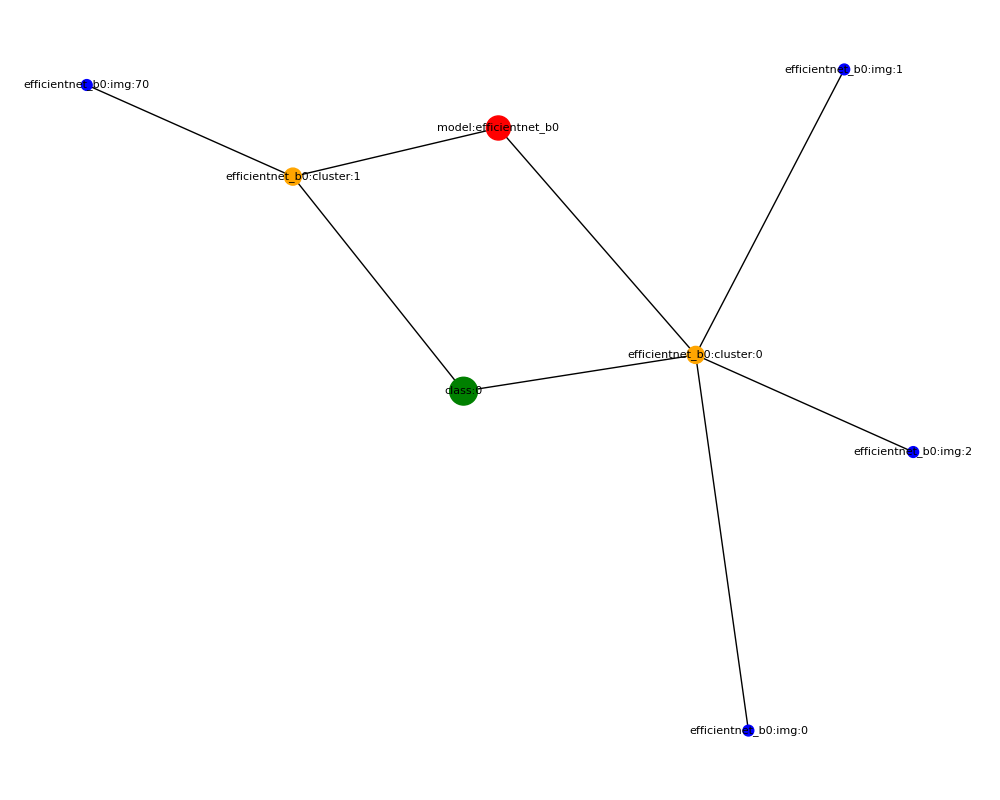


--- kg_efficientnet_b0_from_training_8178


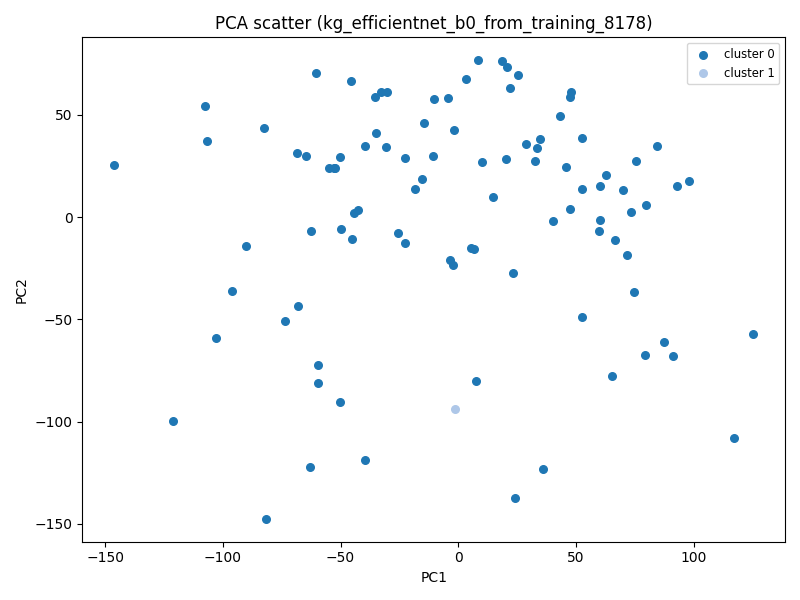

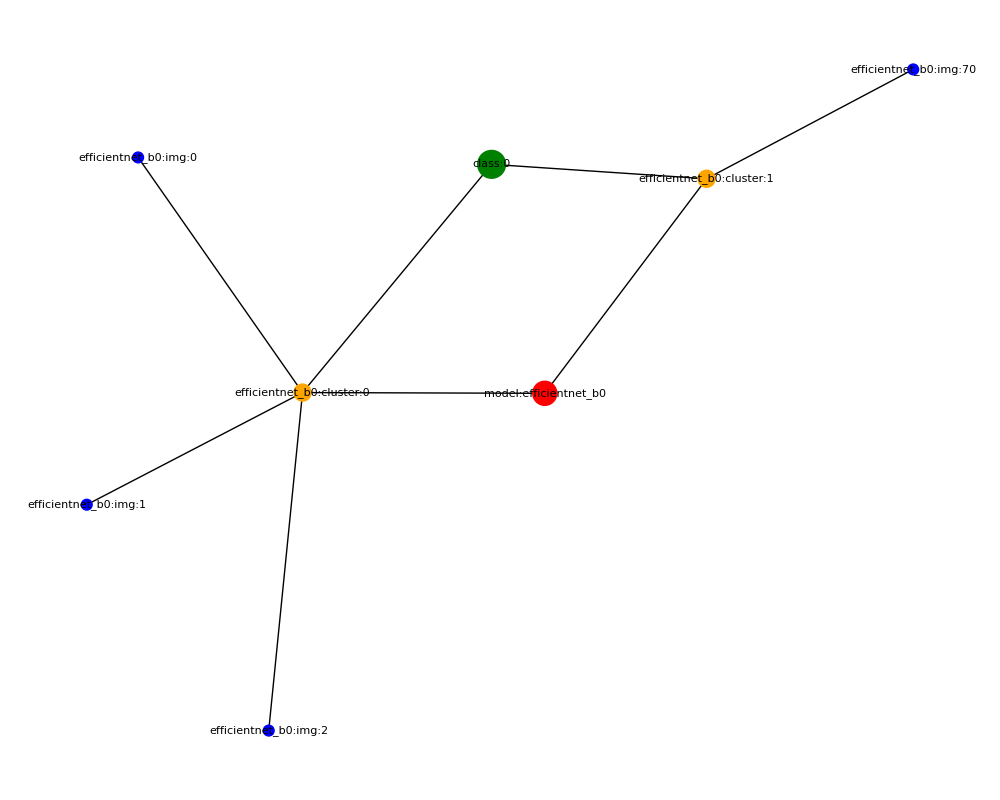


--- kg_efficientnet_b0_from_training_8258


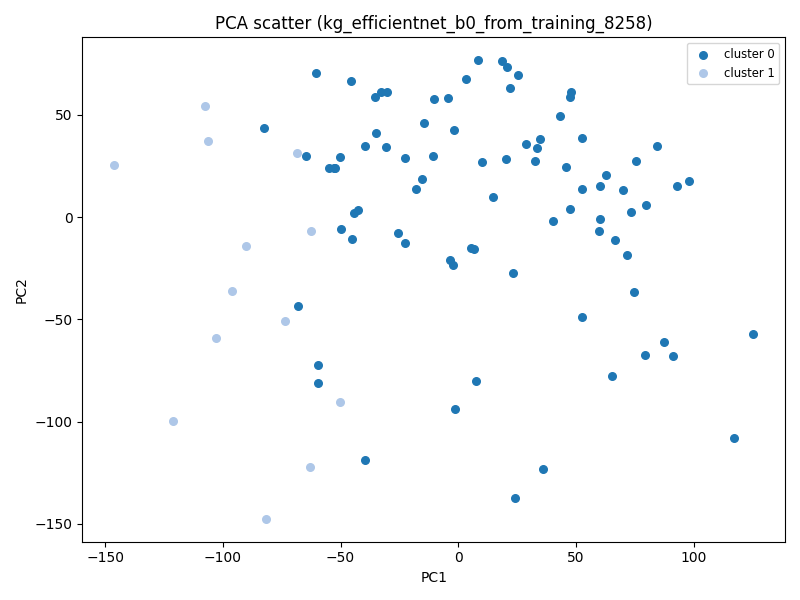

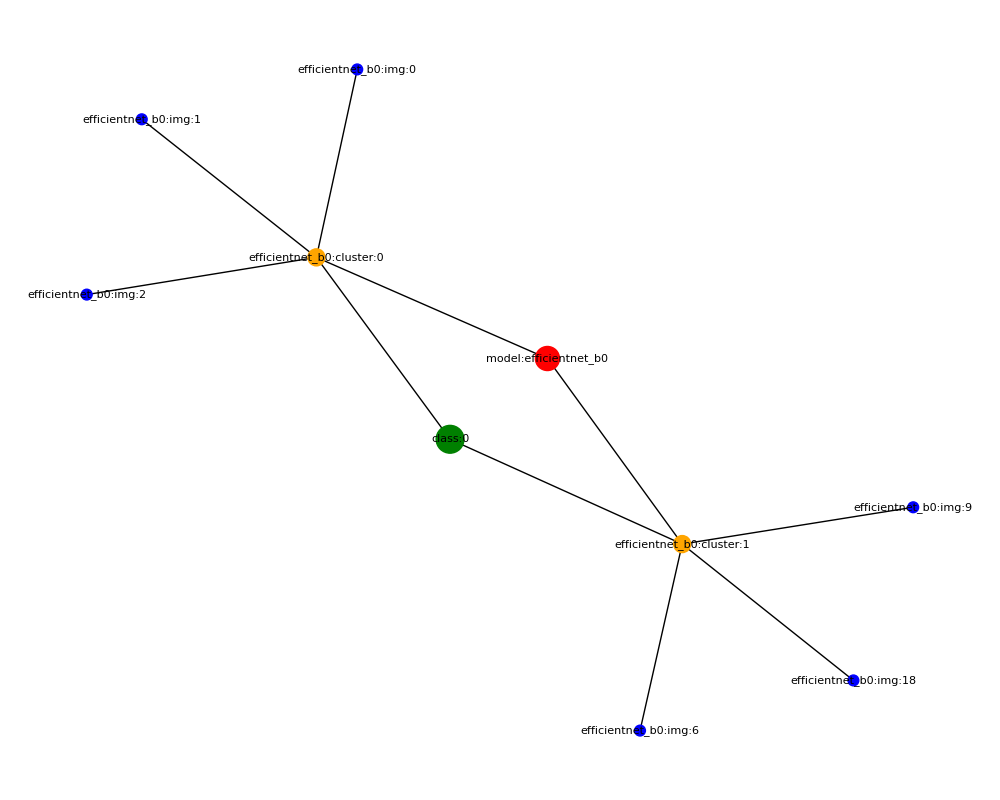


--- kg_efficientnet_b1_from_training_8092


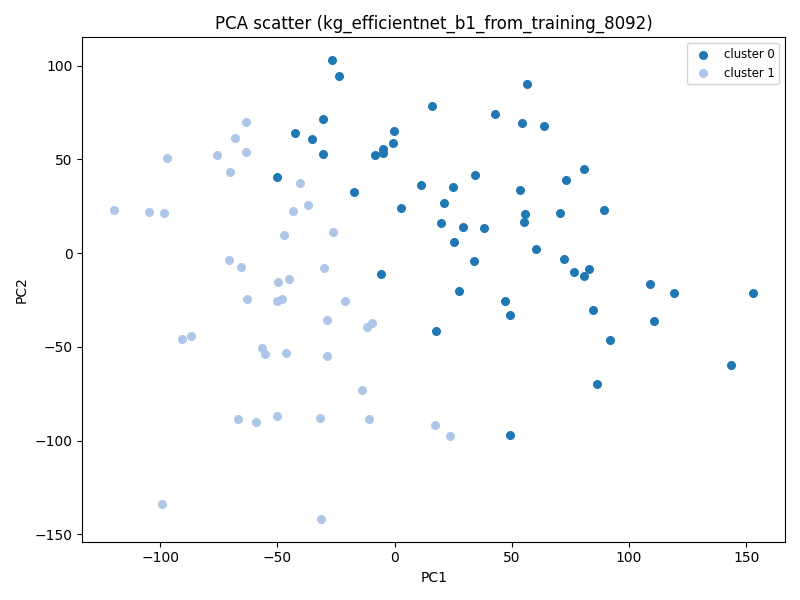

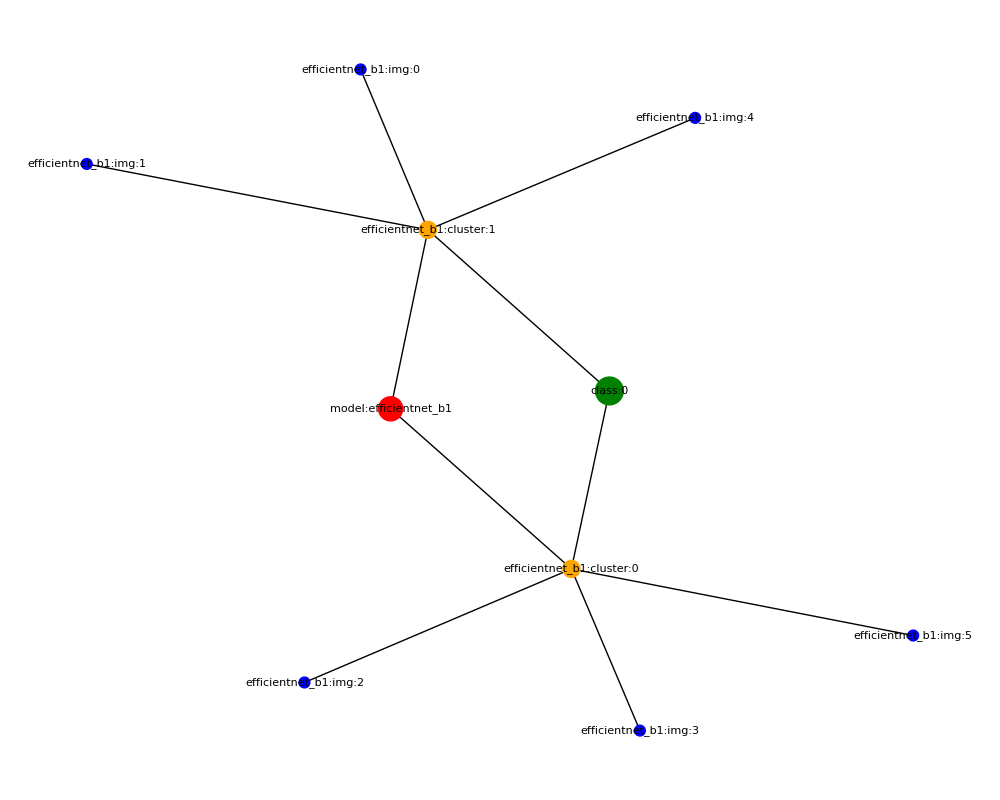


--- kg_efficientnet_b1_from_training_8179


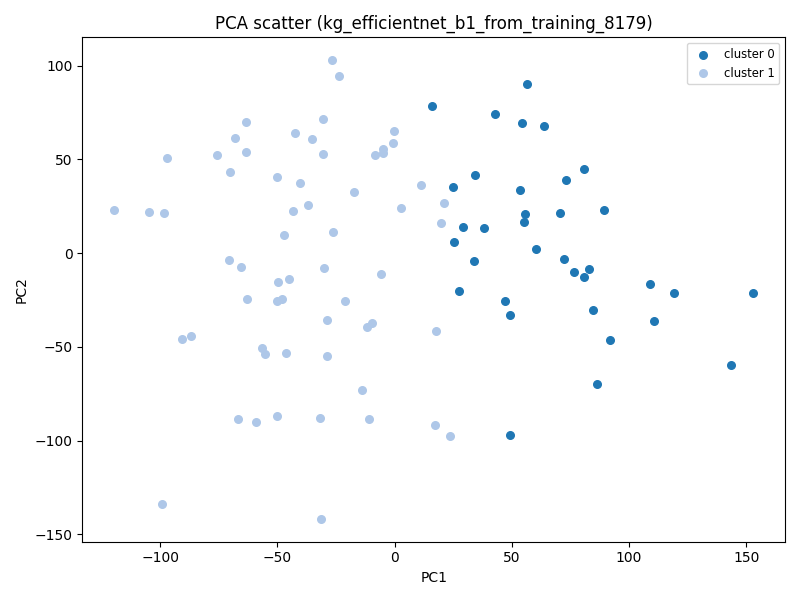

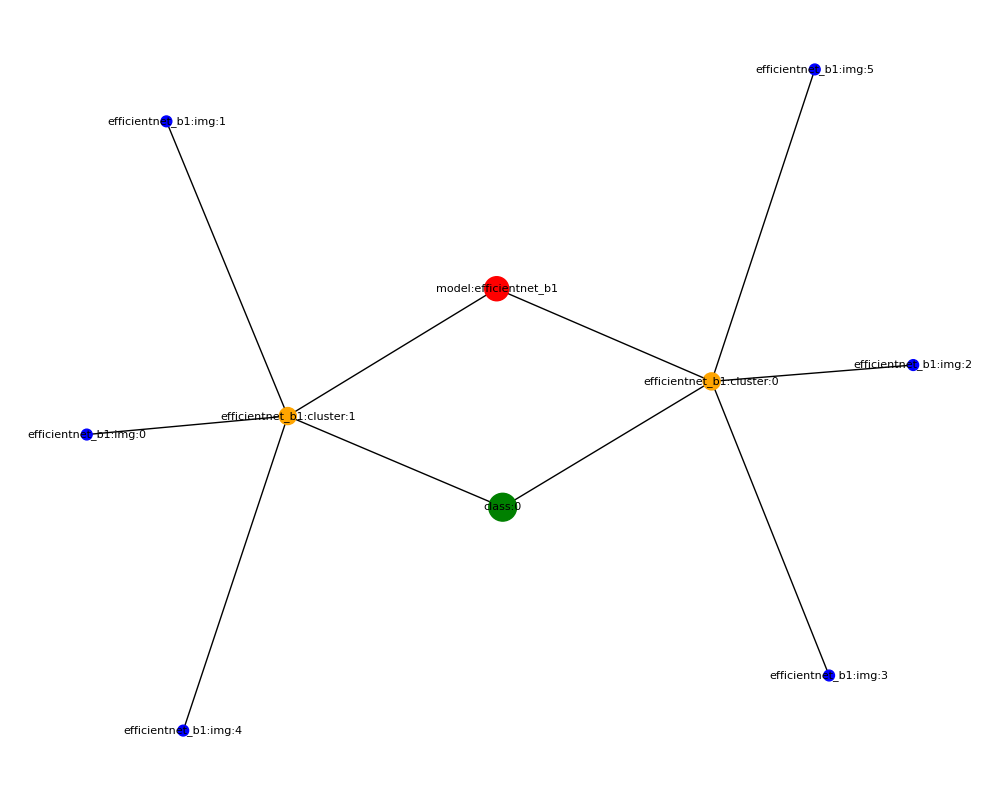


--- kg_efficientnet_b1_from_training_8259


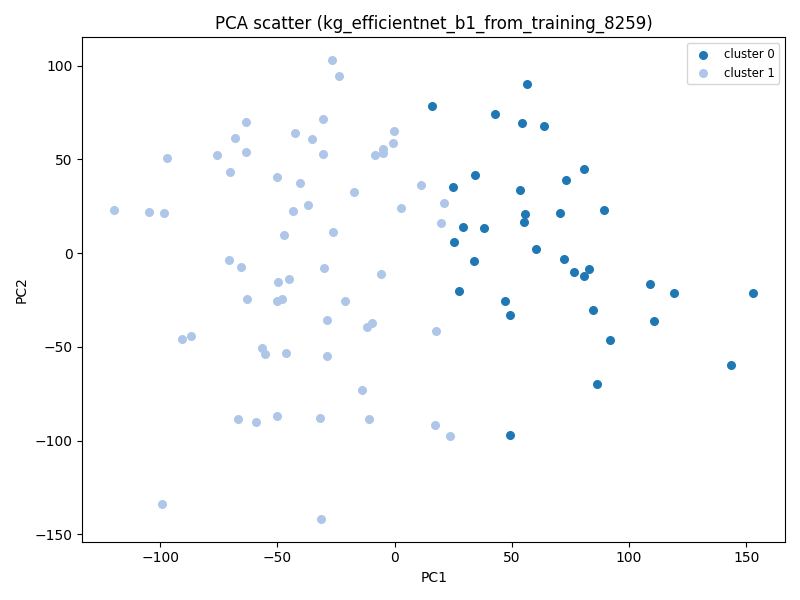

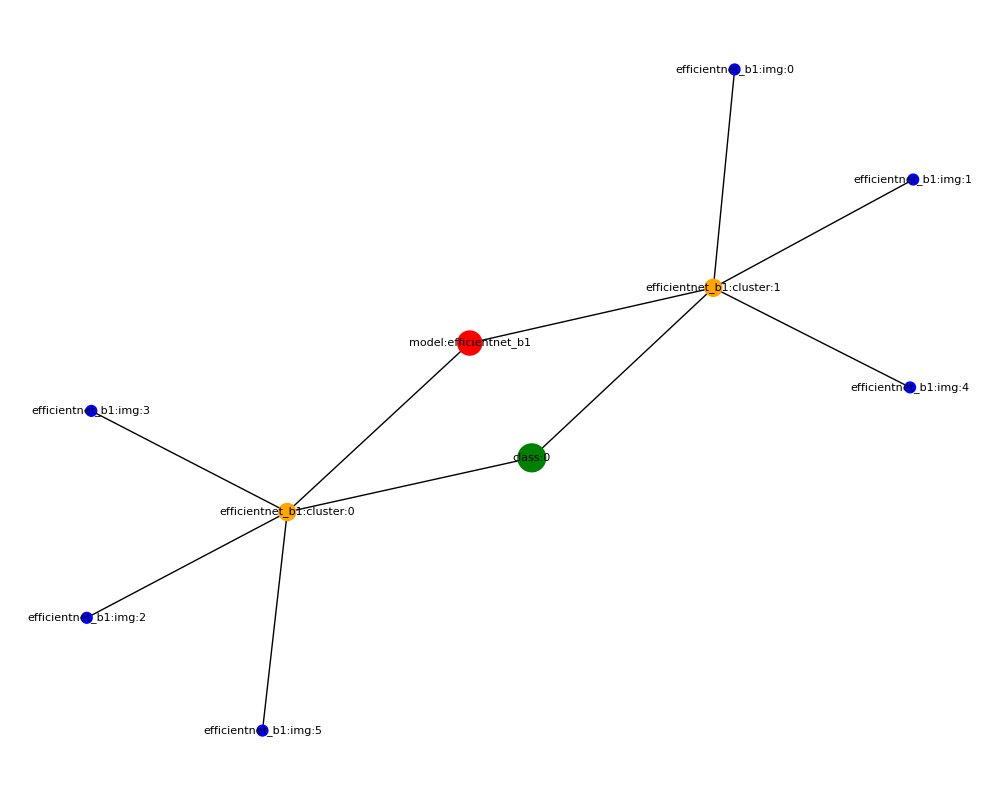


--- kg_efficientnet_b2_from_training_8093


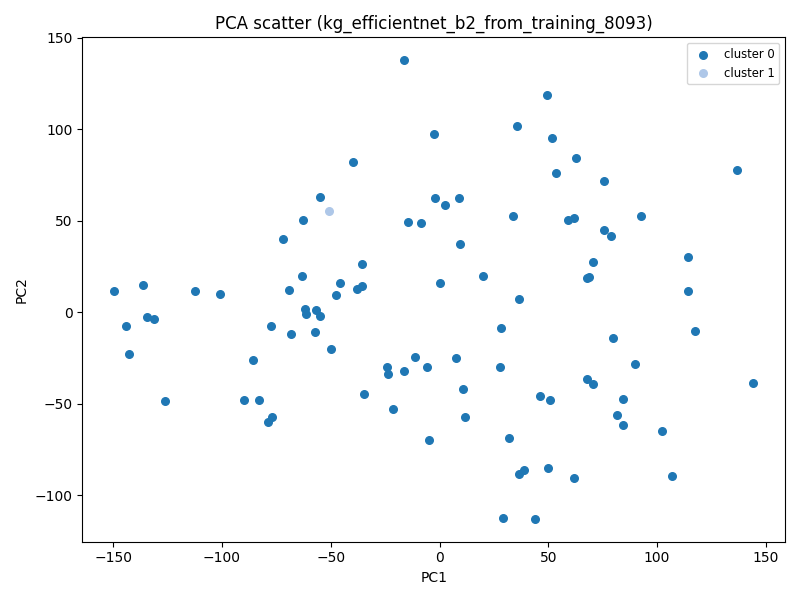

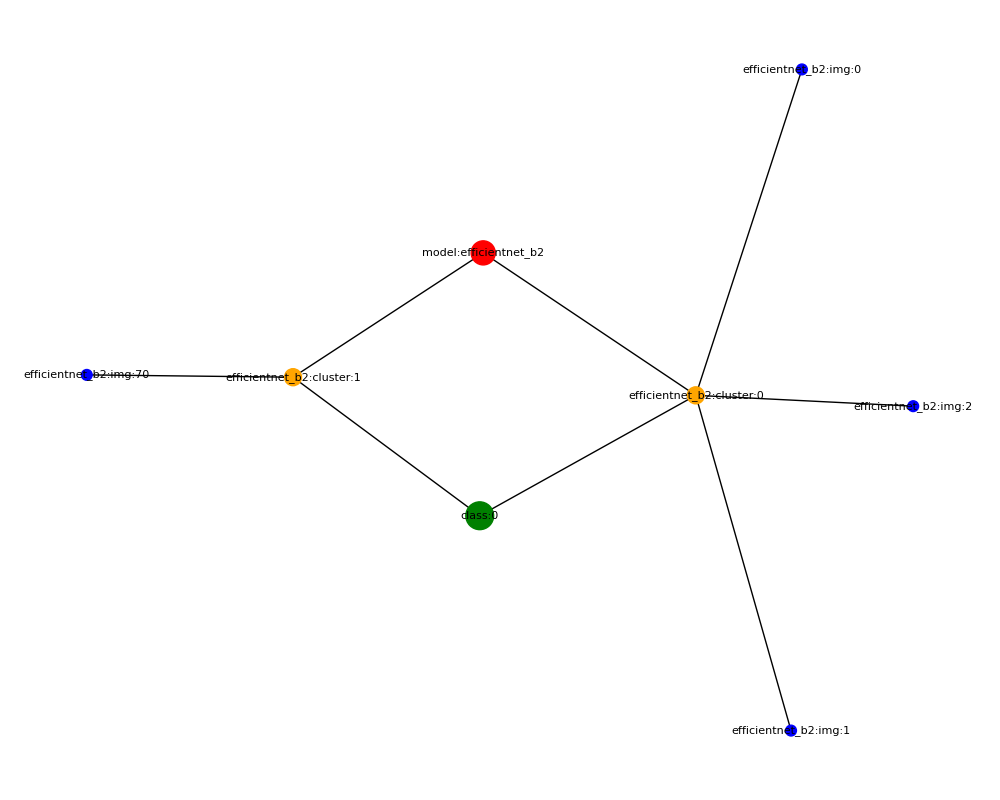


--- kg_efficientnet_b2_from_training_8181


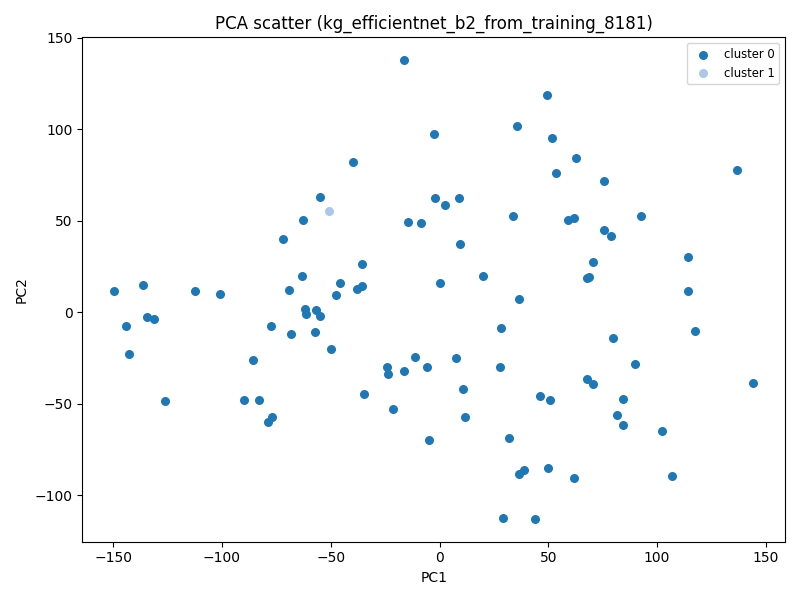

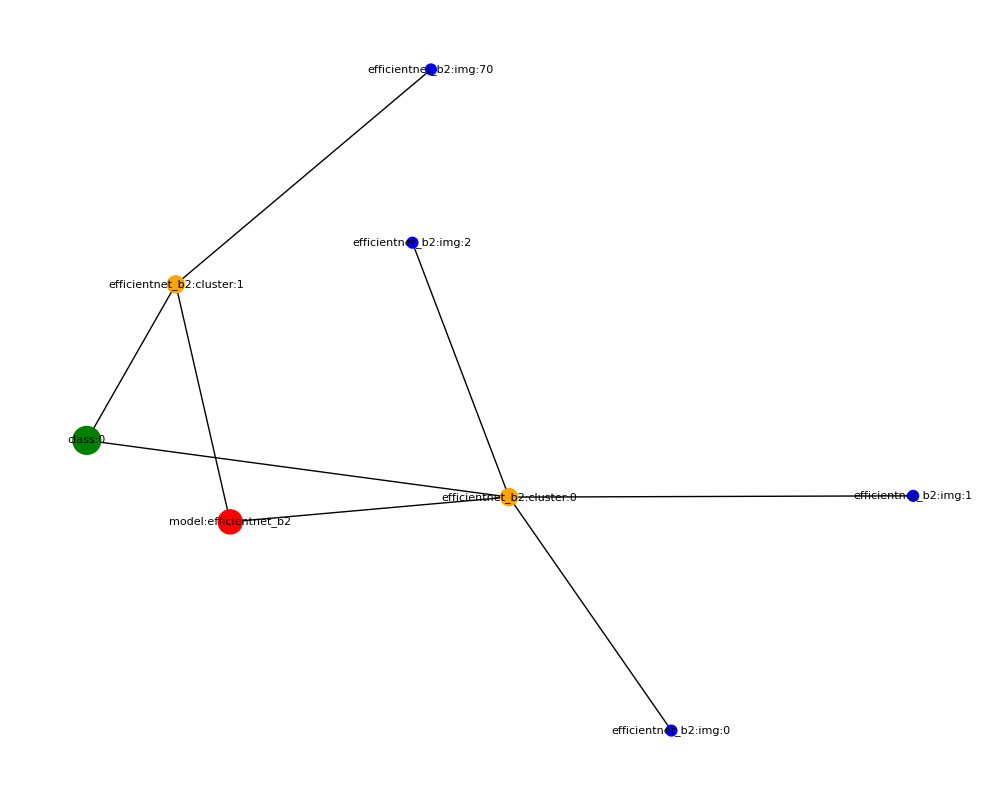


--- kg_efficientnet_b2_from_training_8261


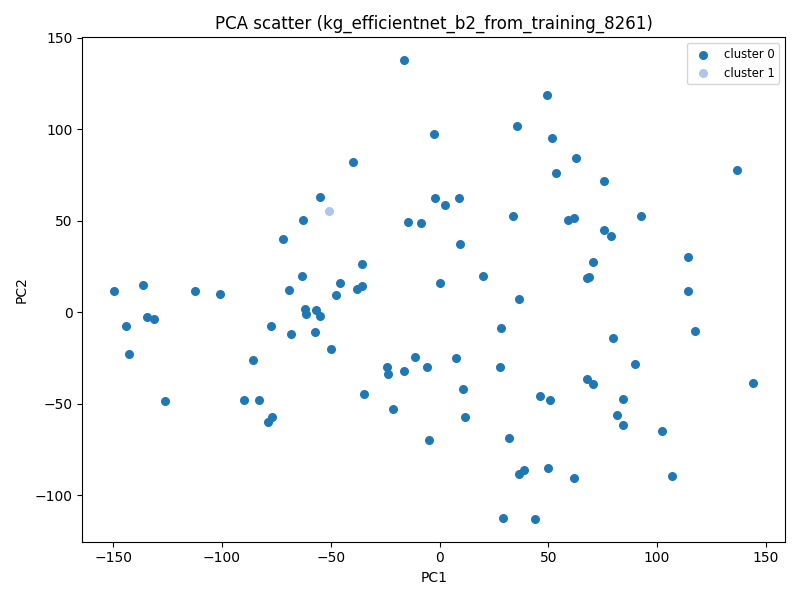

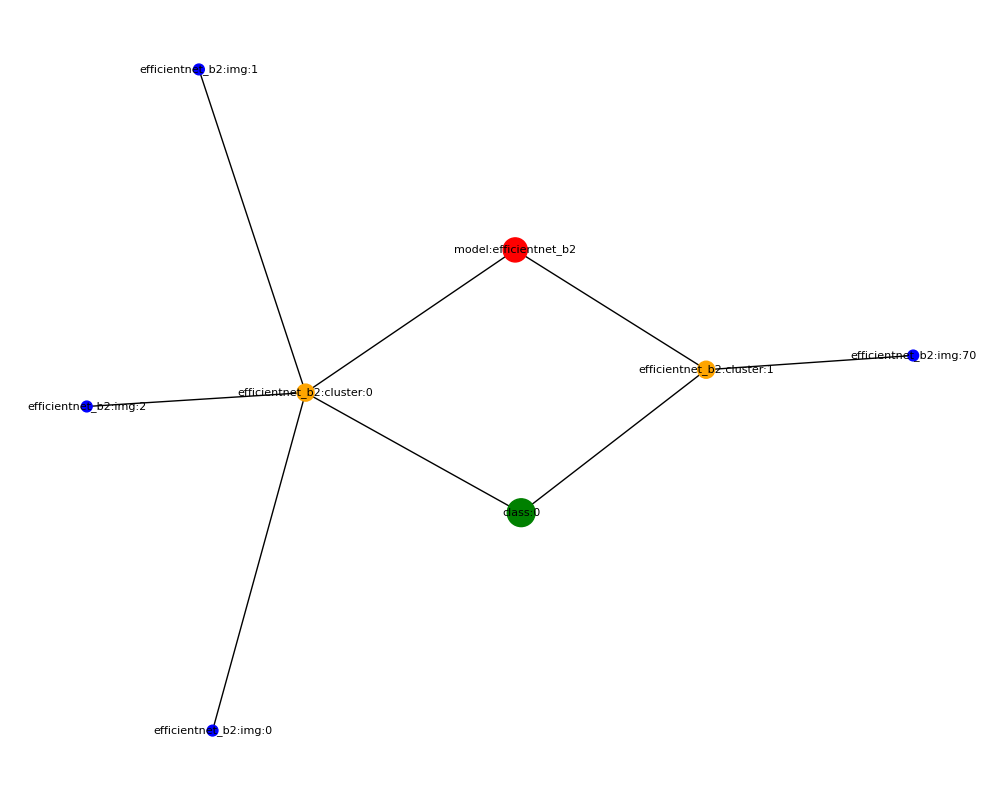


--- kg_efficientnet_b3_from_training_8094


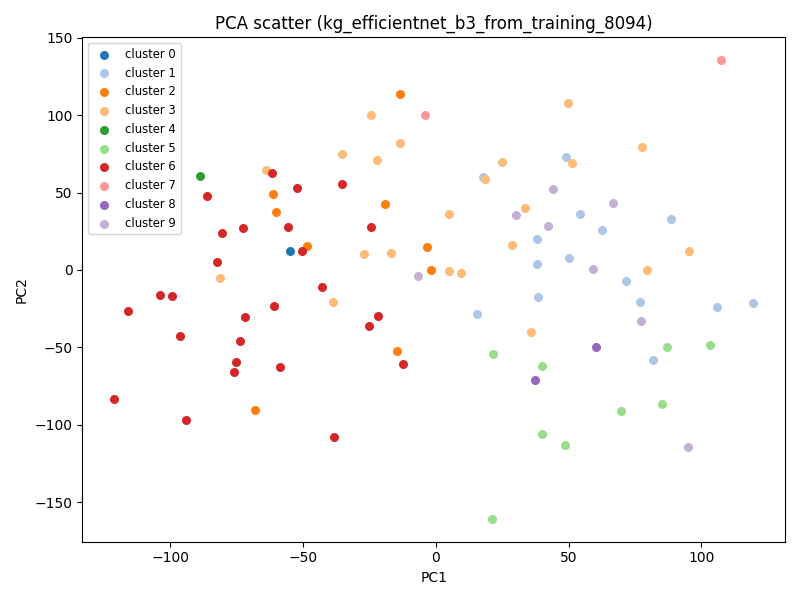

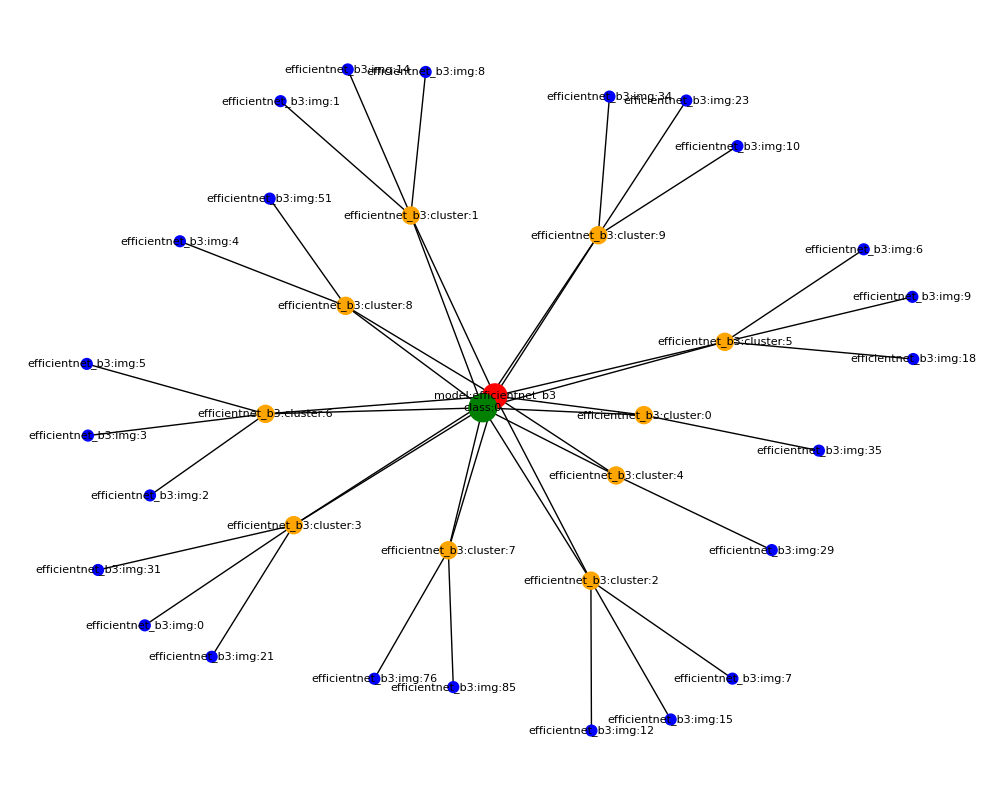


--- kg_efficientnet_b3_from_training_8182


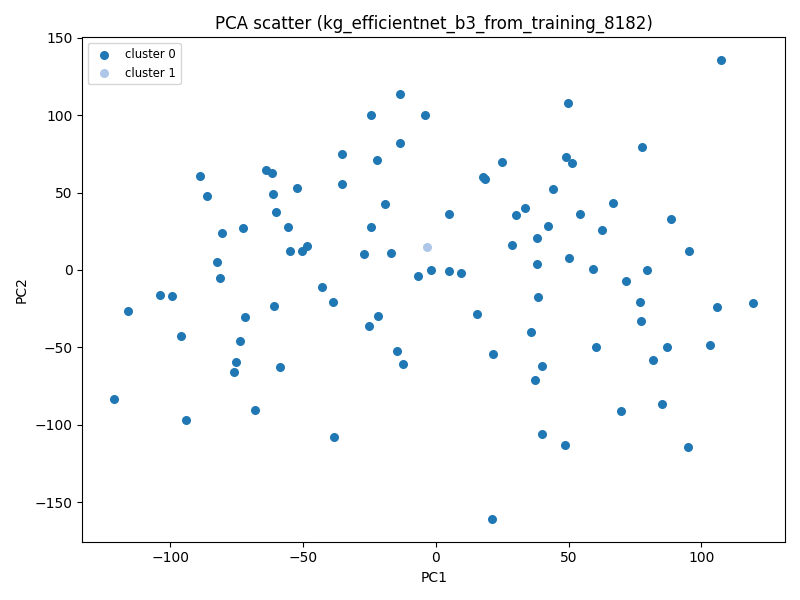

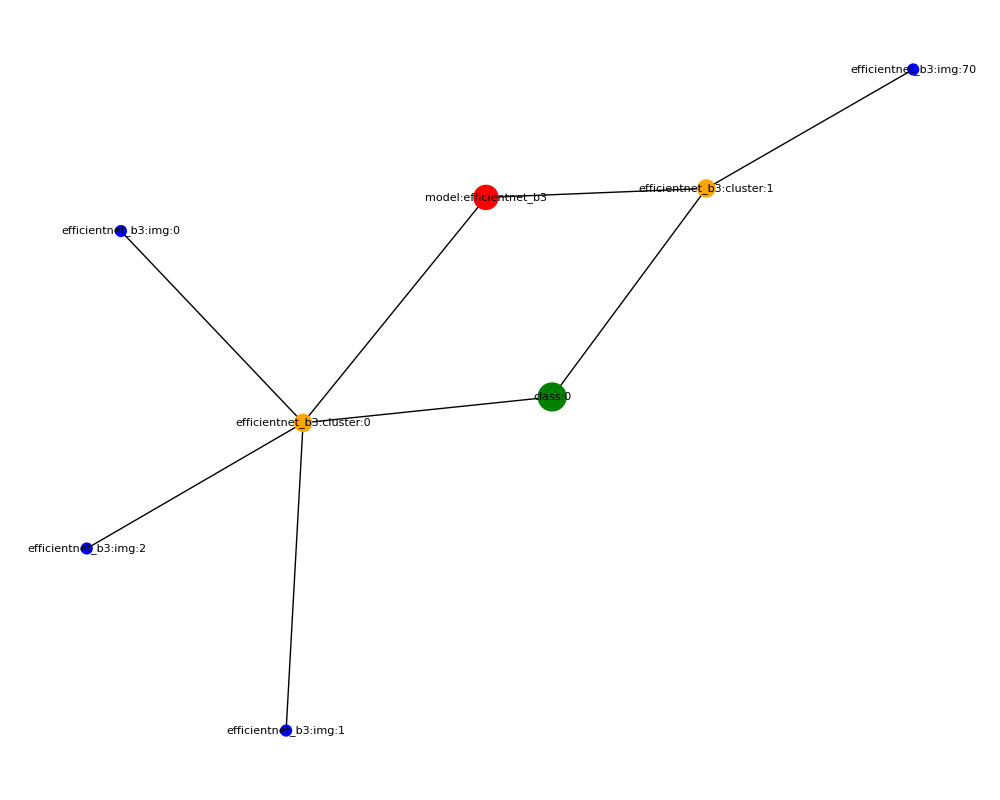


--- kg_efficientnet_b3_from_training_8262


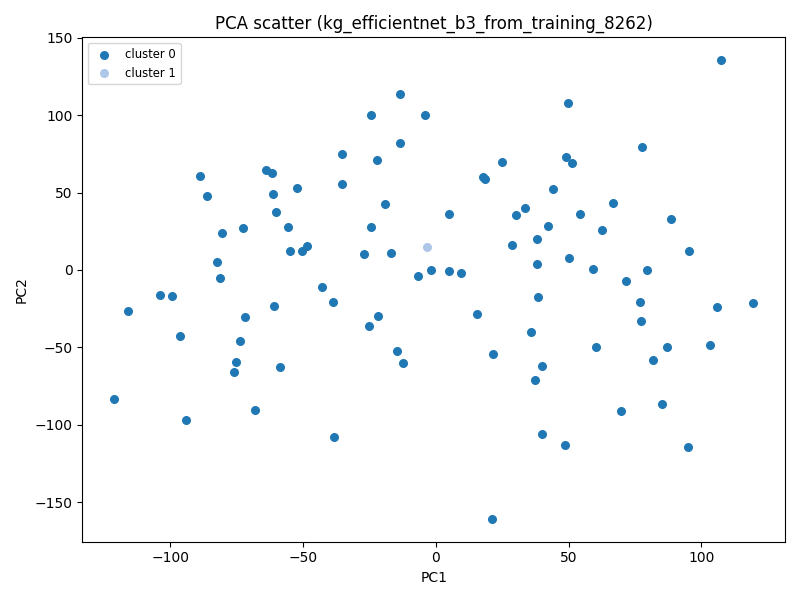

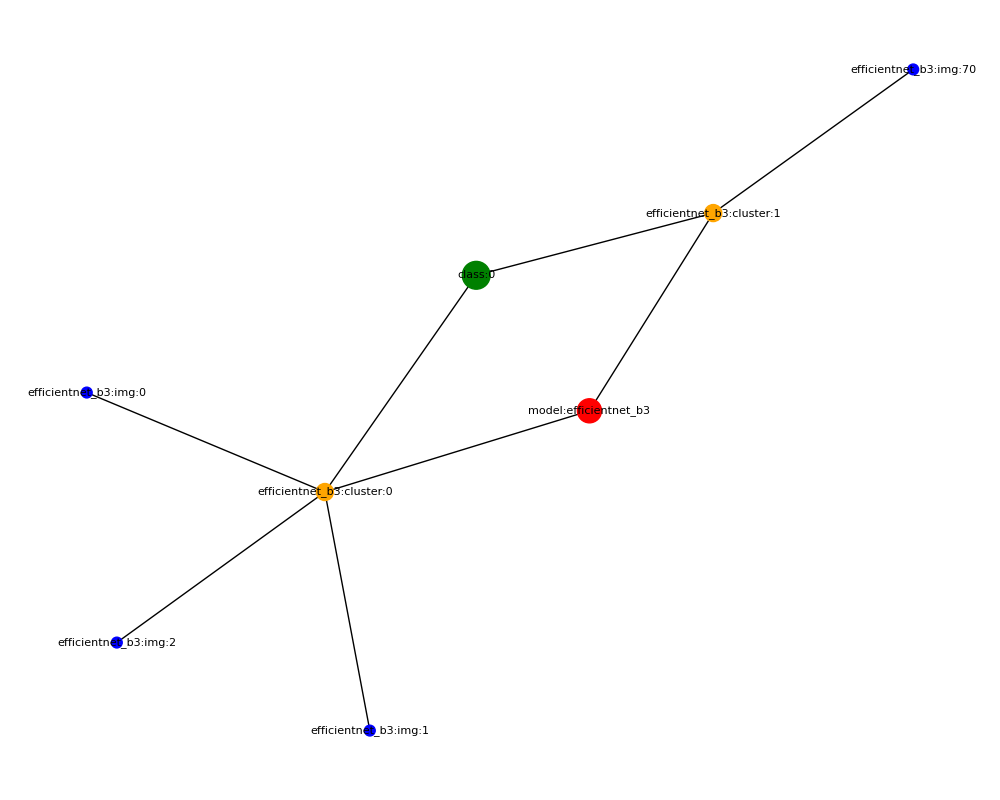


--- kg_efficientnet_b4_from_training_8096


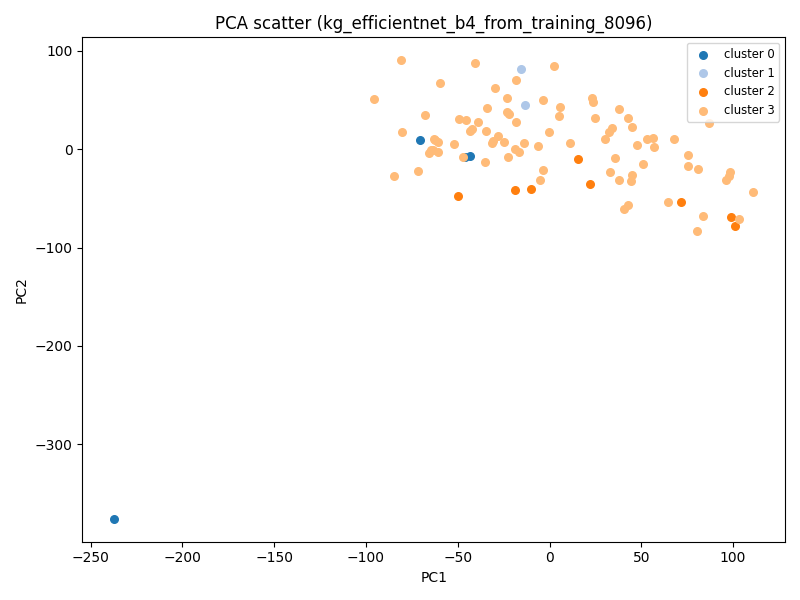

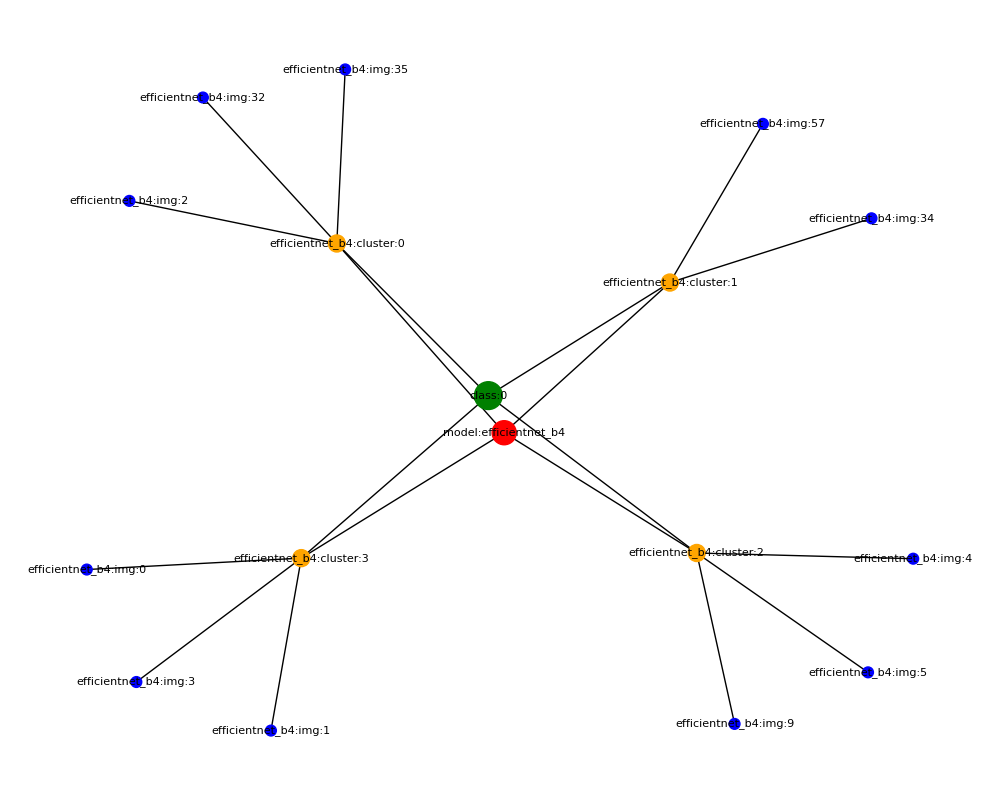


--- kg_efficientnet_b4_from_training_8183


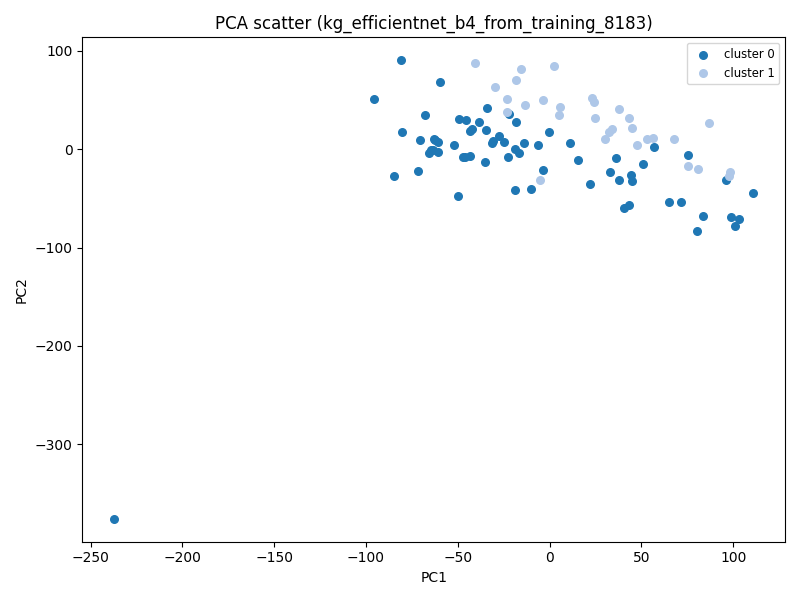

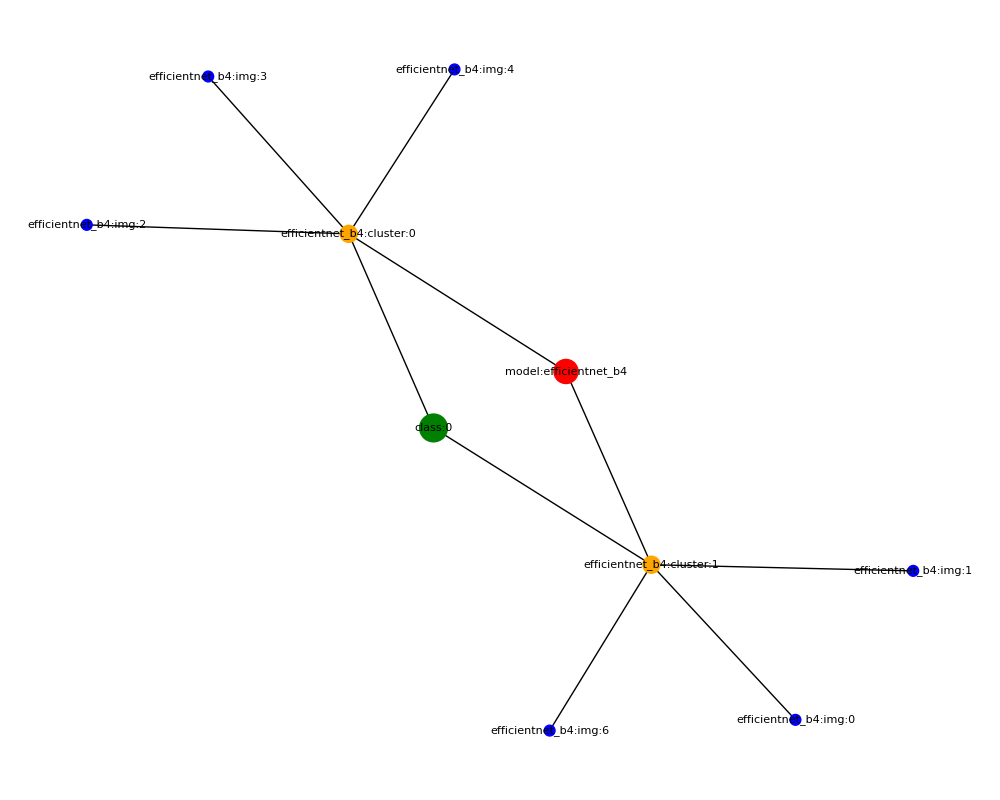


--- kg_efficientnet_b4_from_training_8263


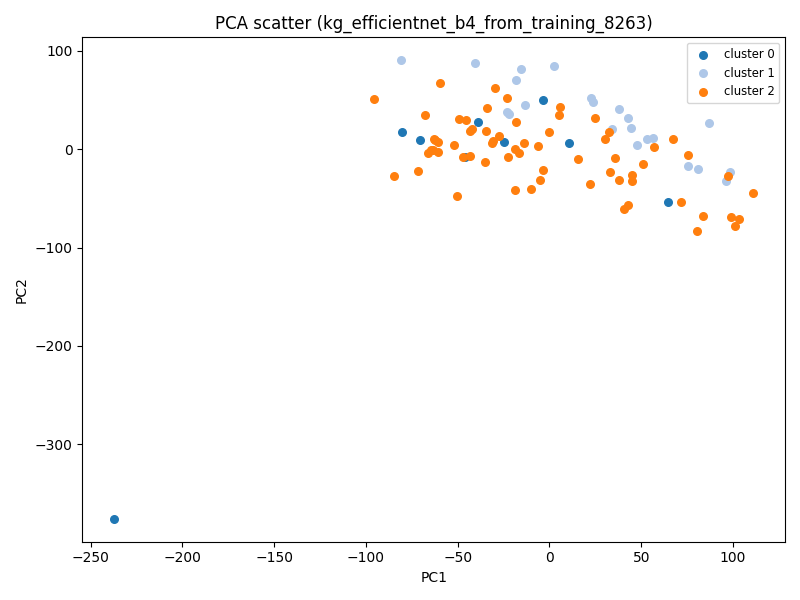

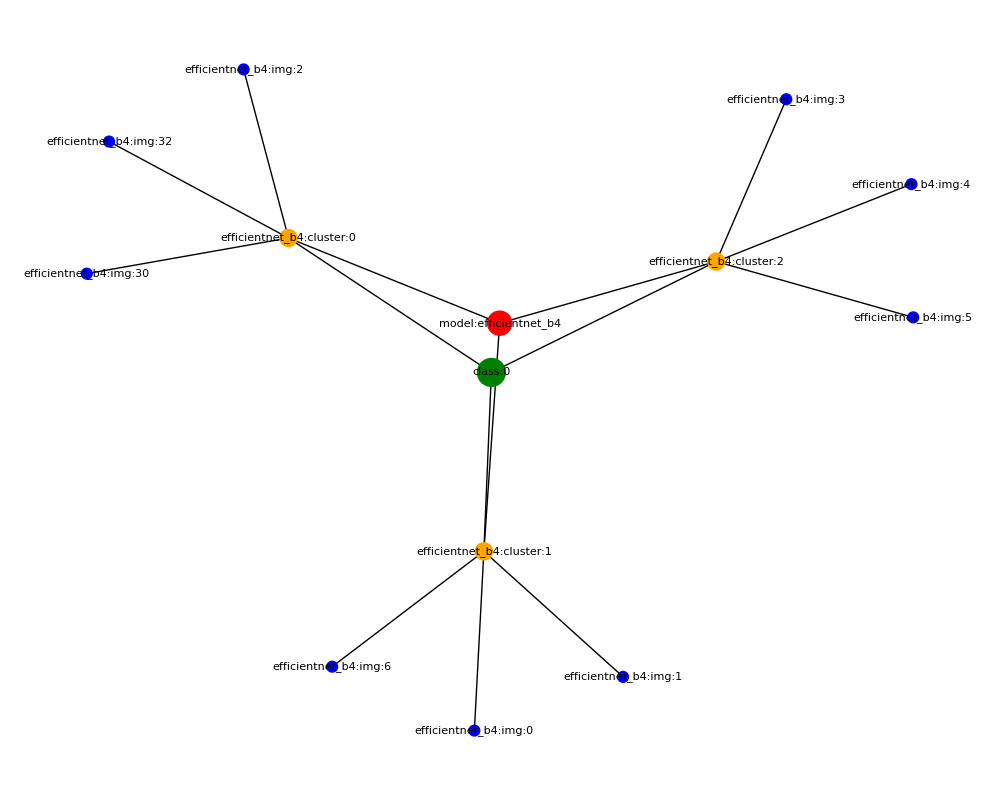


--- kg_gbcnet_from_training_8104


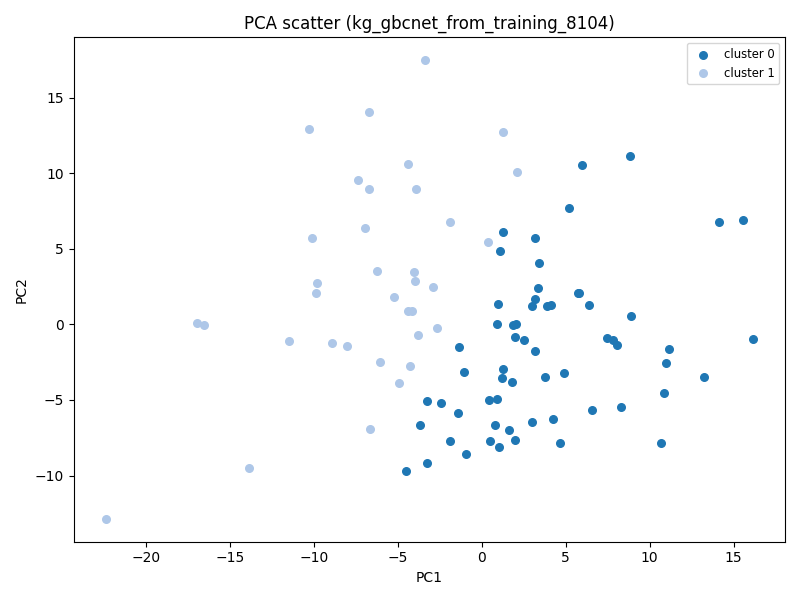

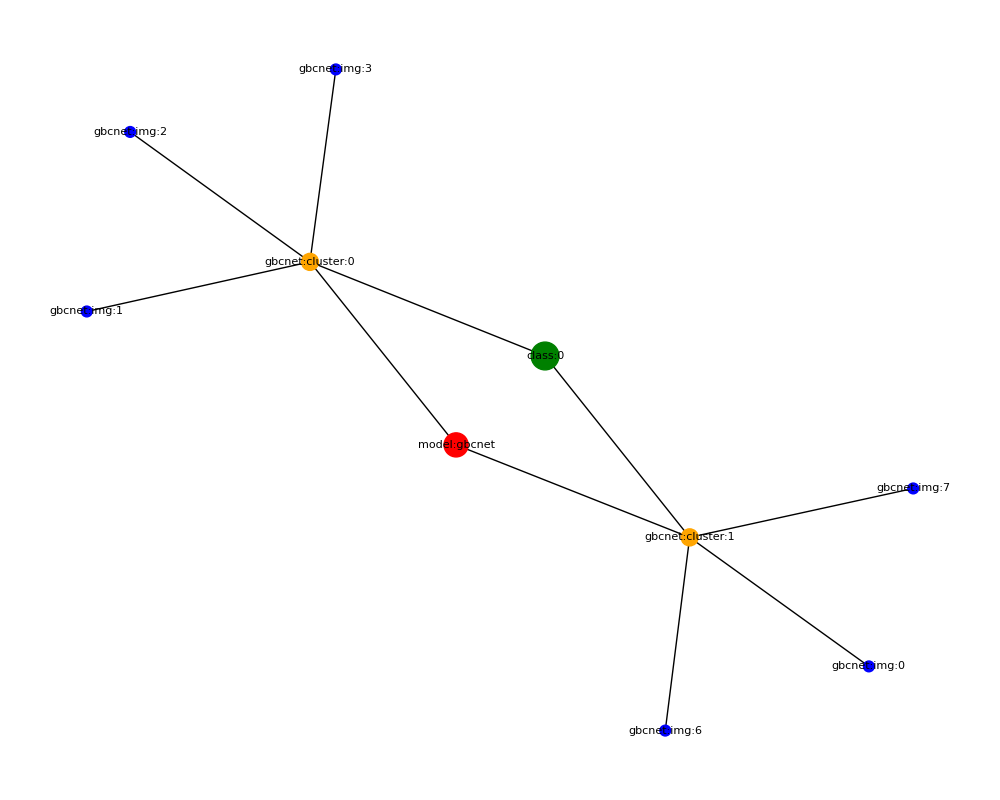


--- kg_gbcnet_from_training_8191


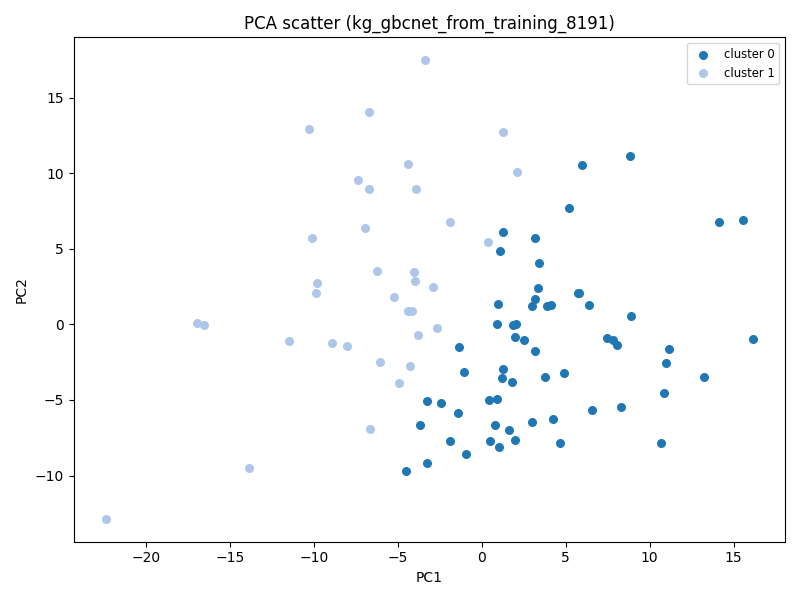

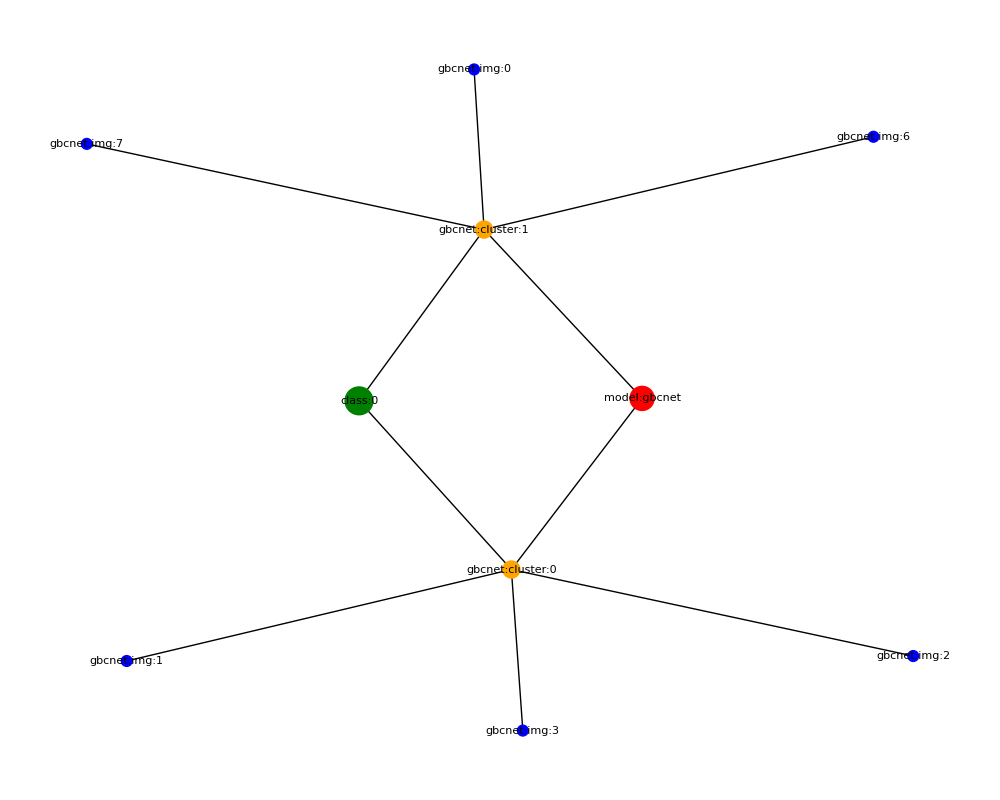


--- kg_gbcnet_from_training_8271


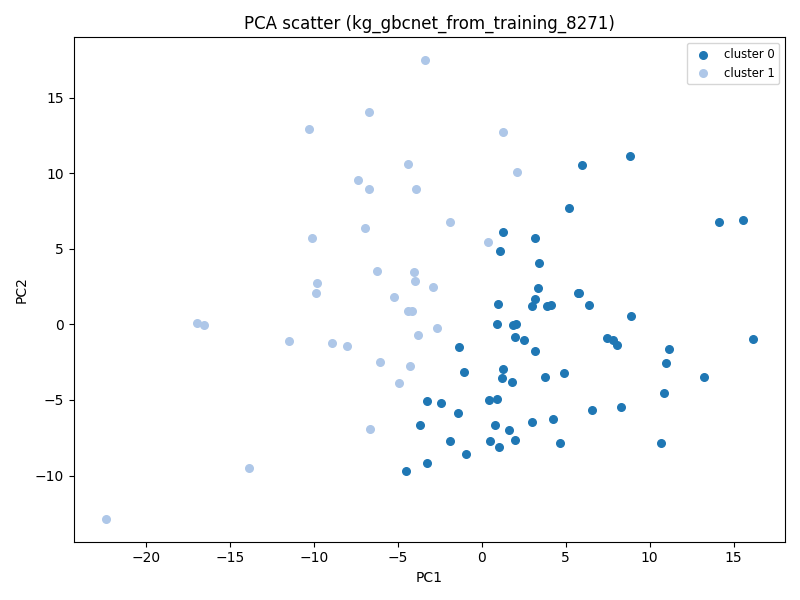

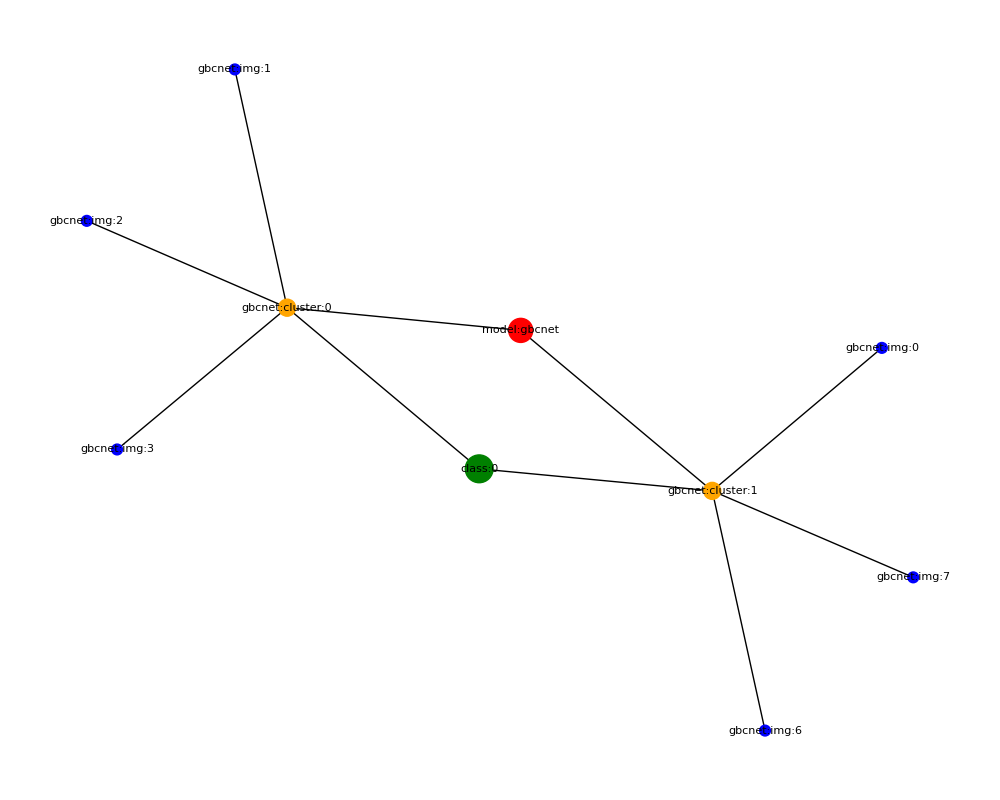


--- kg_mobilenet_v2_from_training_8101


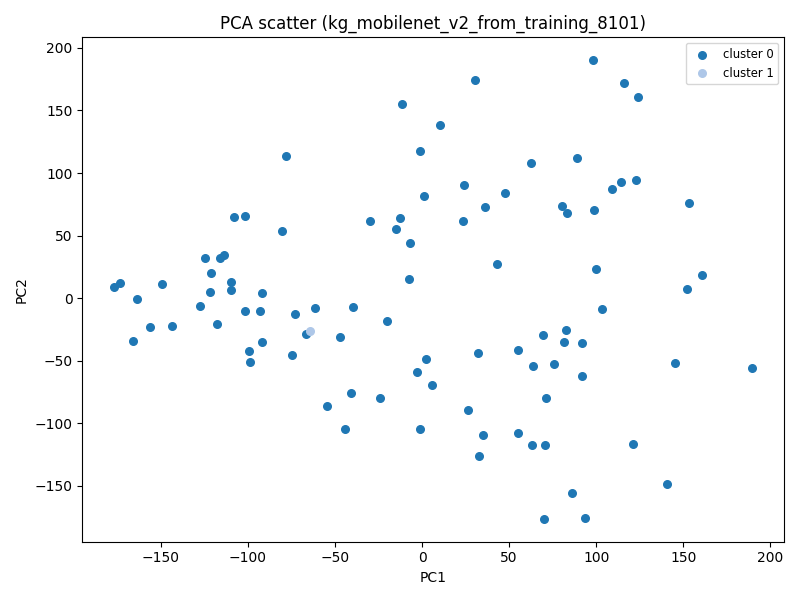

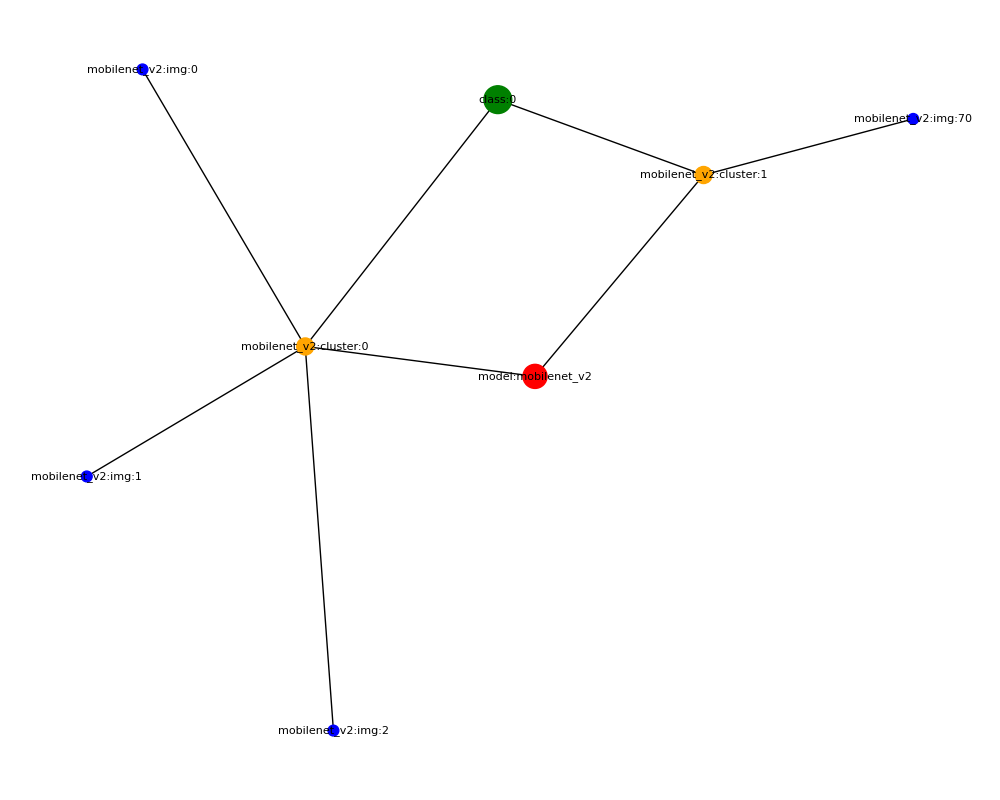


--- kg_mobilenet_v2_from_training_8189


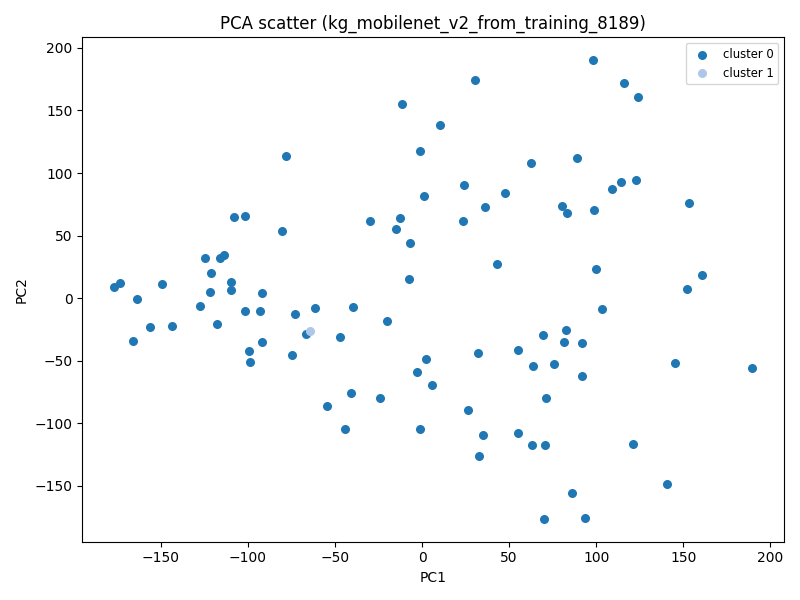

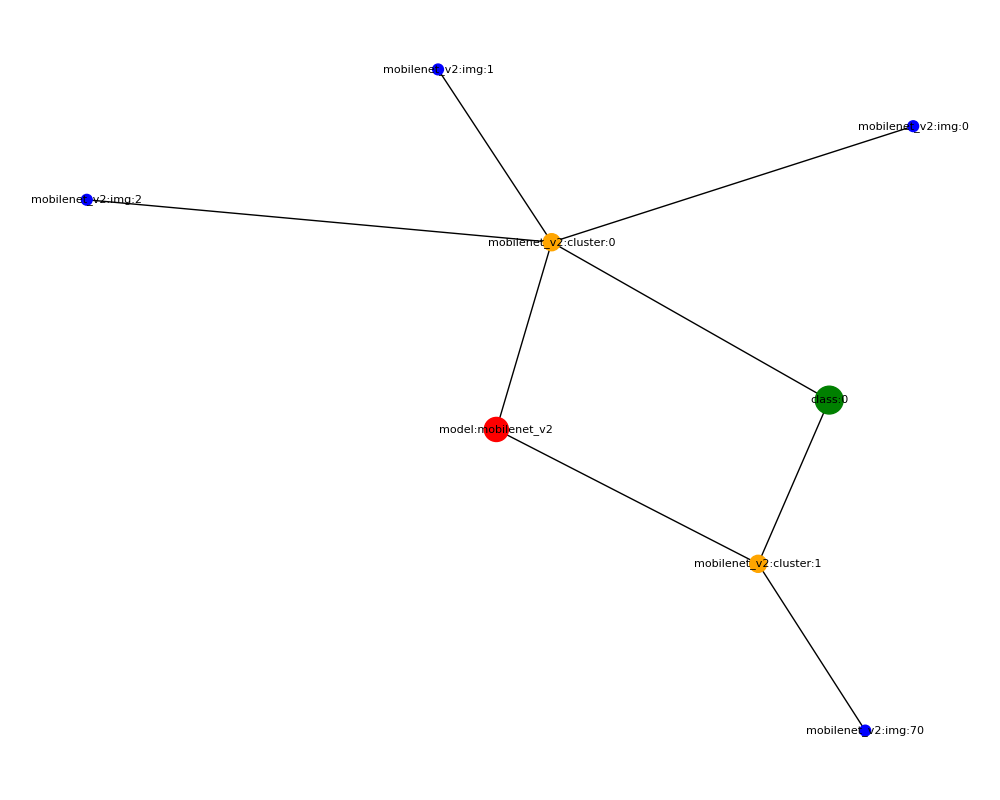


--- kg_mobilenet_v2_from_training_8269


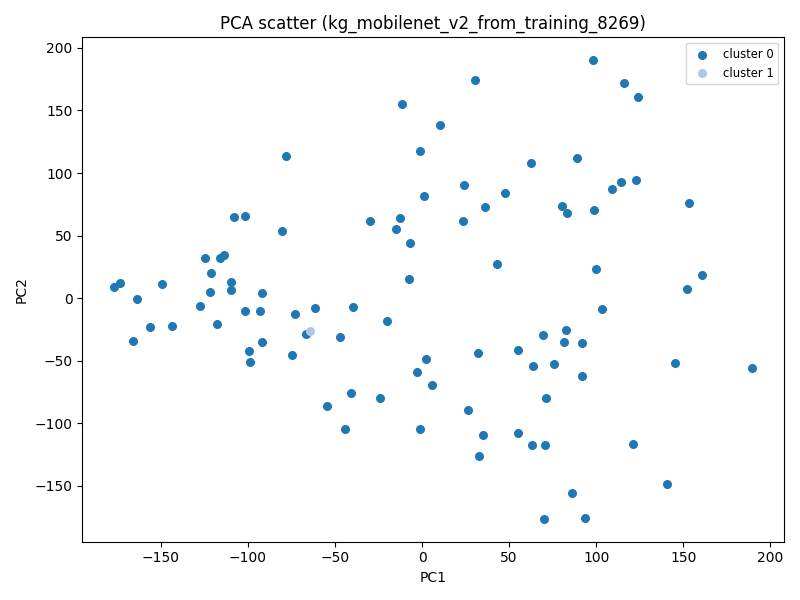

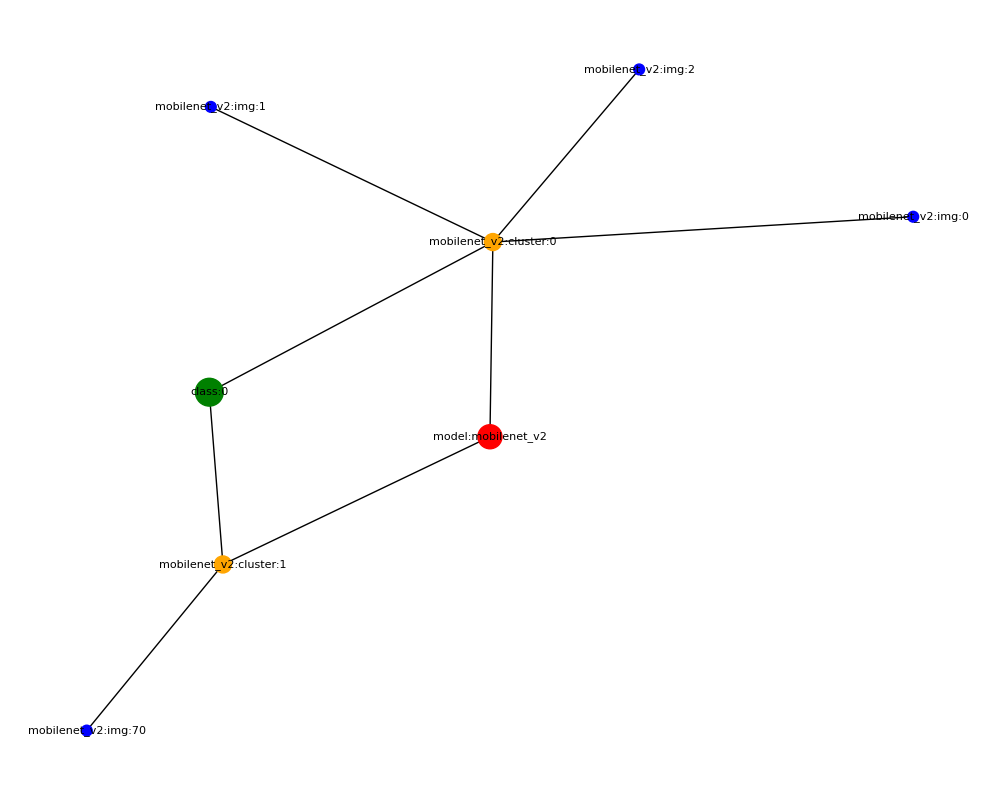


--- kg_resnet18_from_training_5272


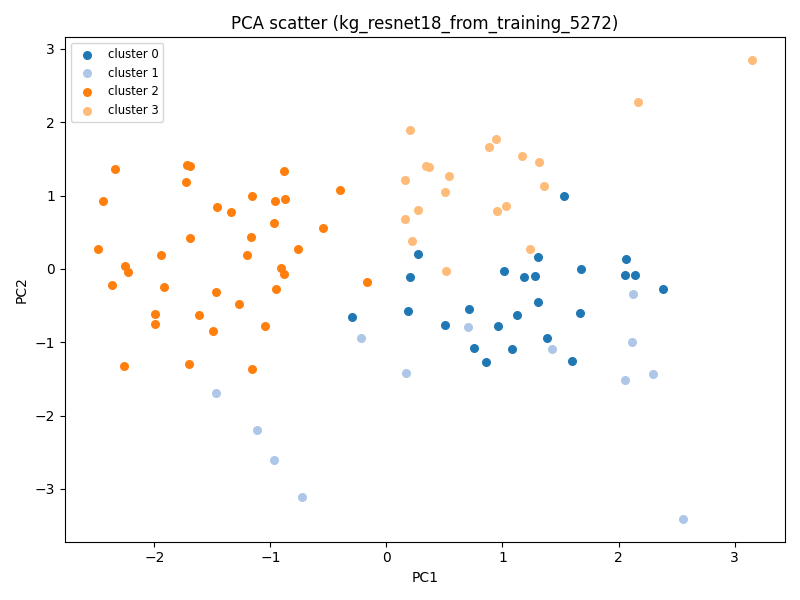

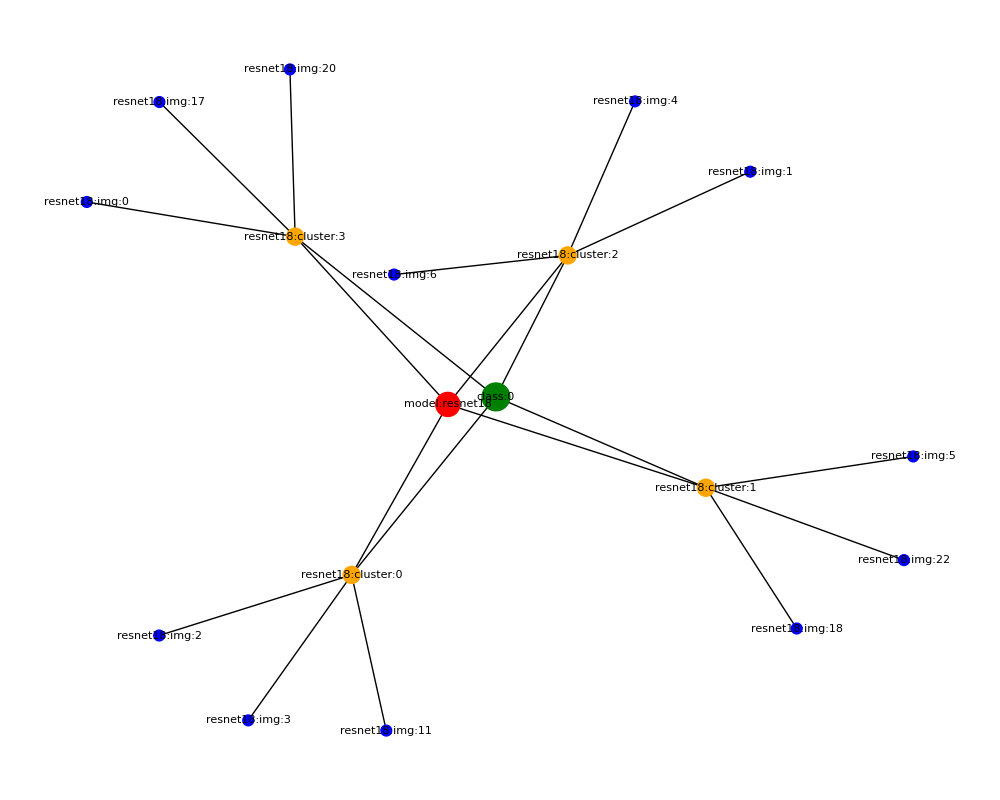


--- kg_resnet18_from_training_5744


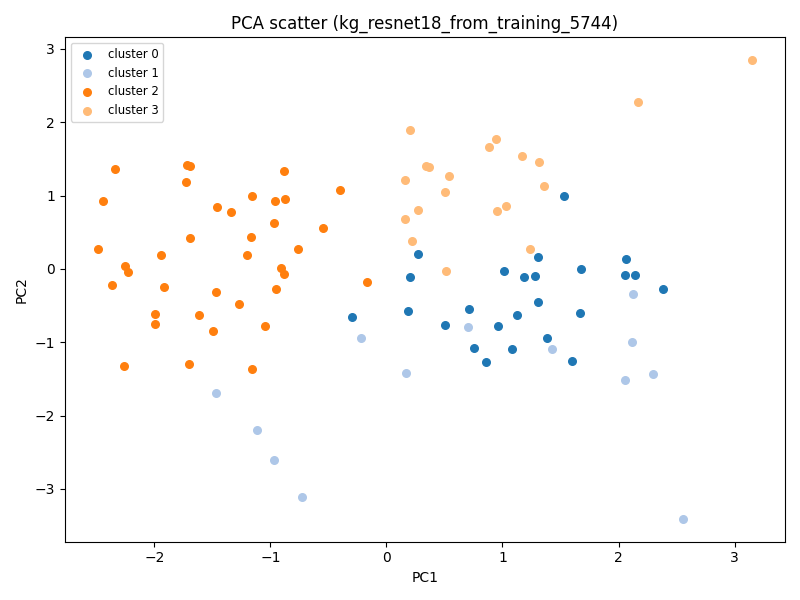

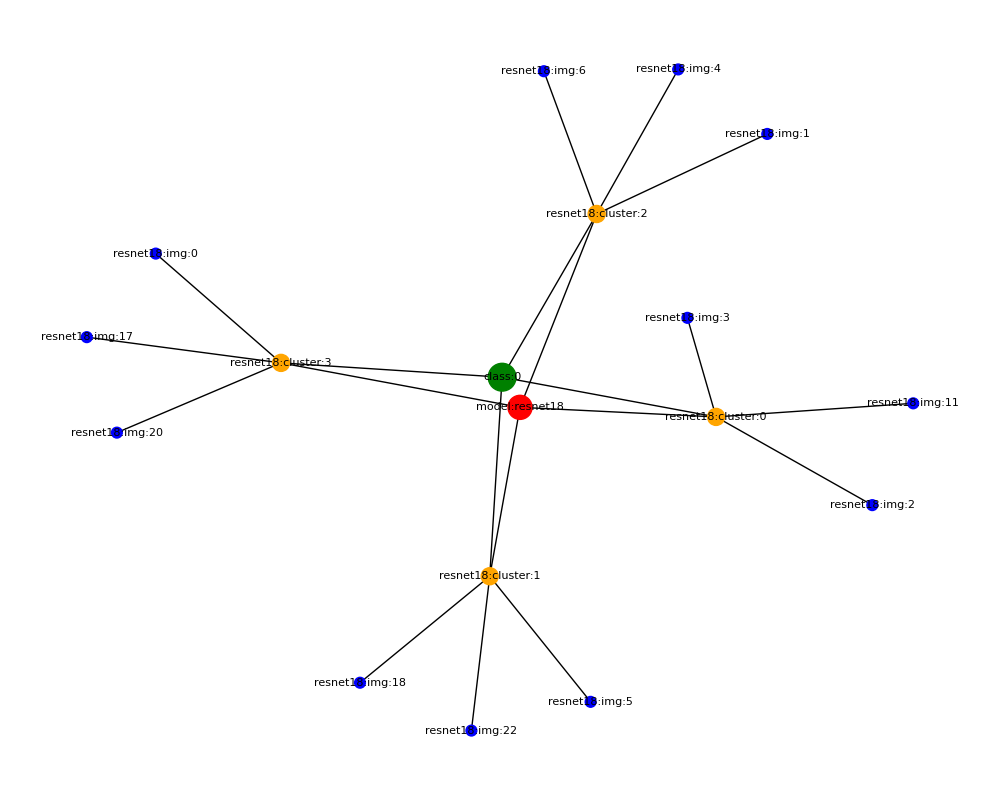


--- kg_resnet18_from_training_8089


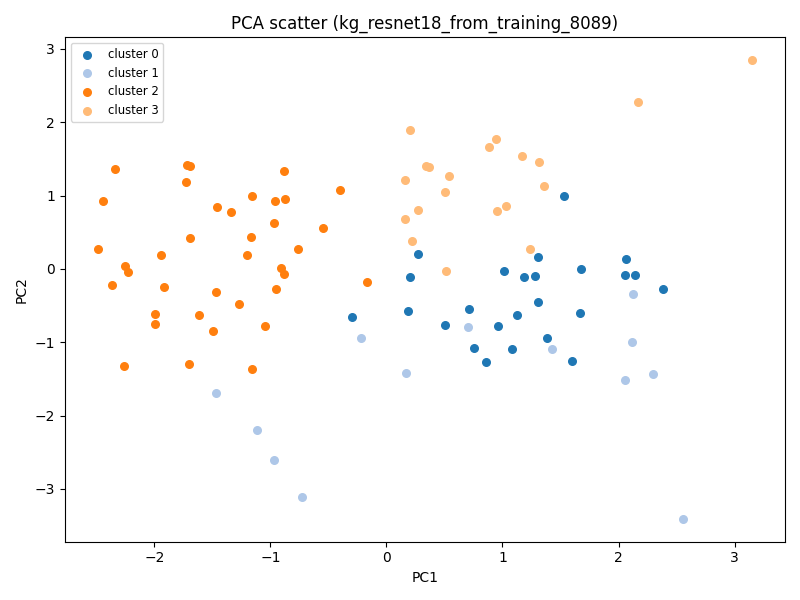

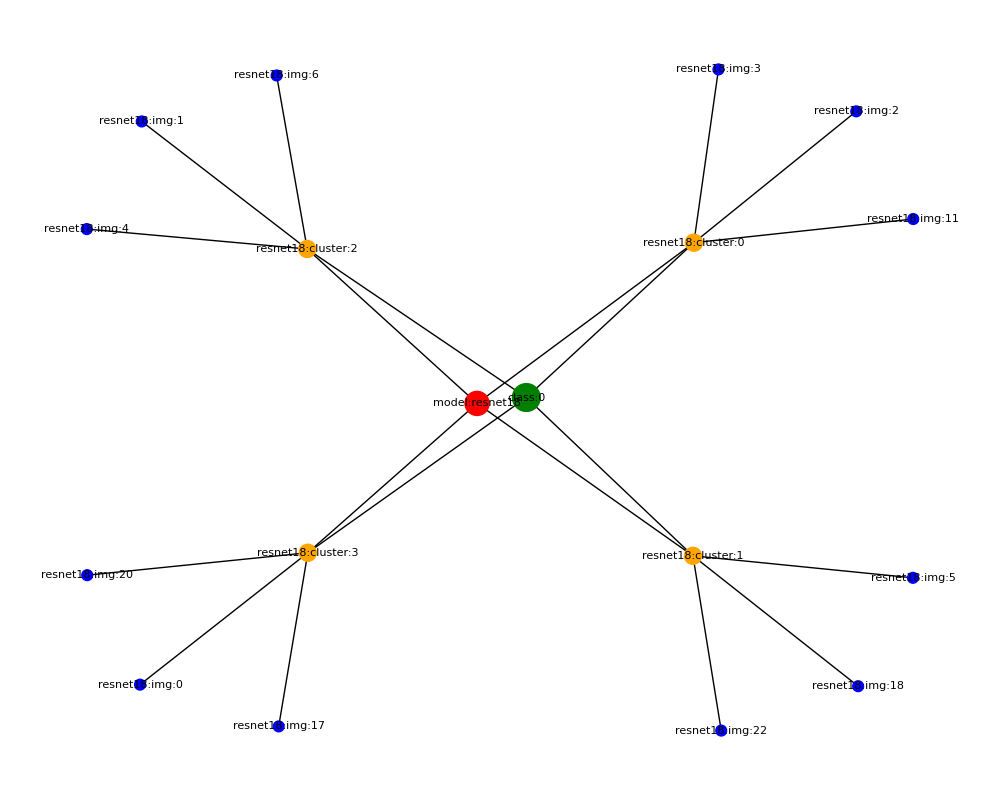


--- kg_resnet18_from_training_8177


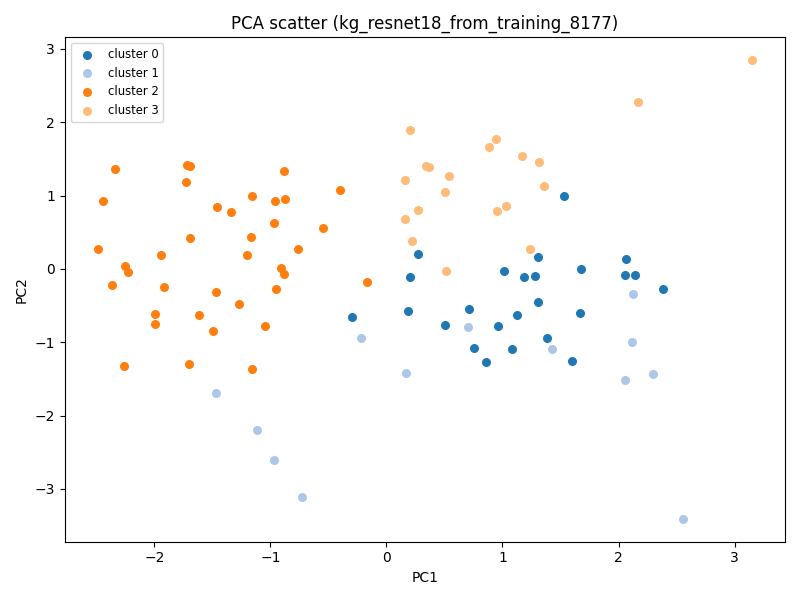

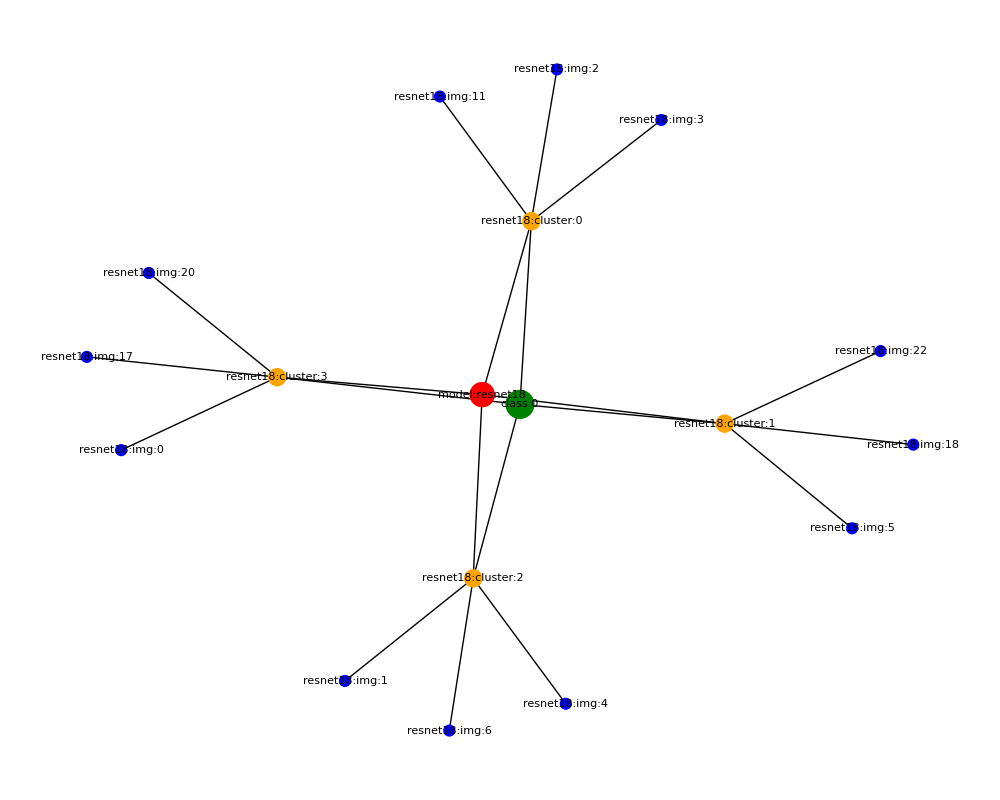


--- kg_resnet18_from_training_8258


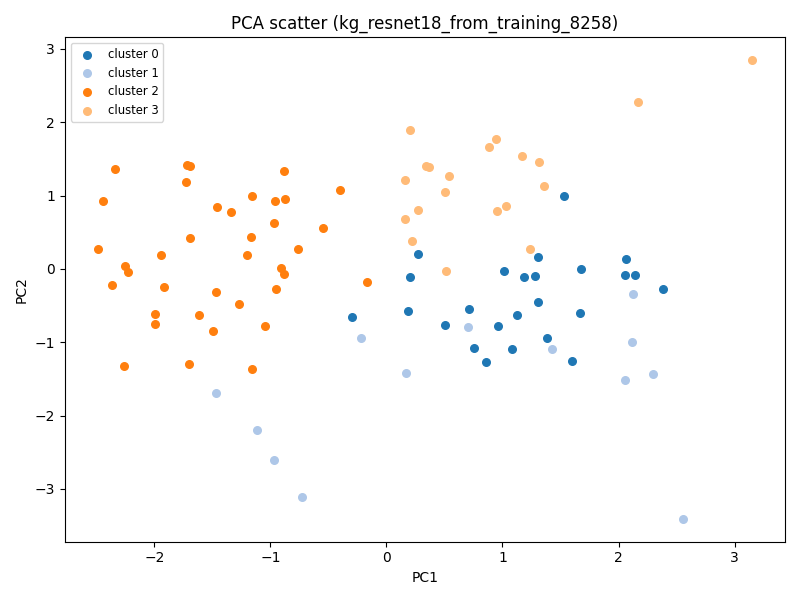

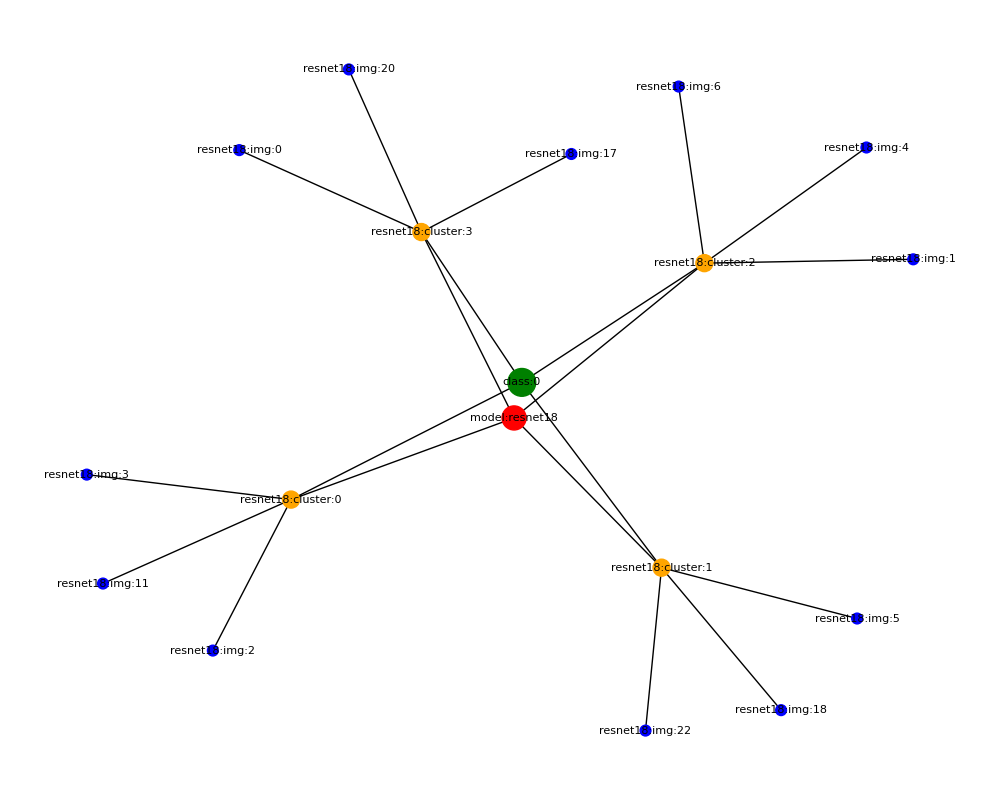


--- kg_resnet50_v1_from_training_8105


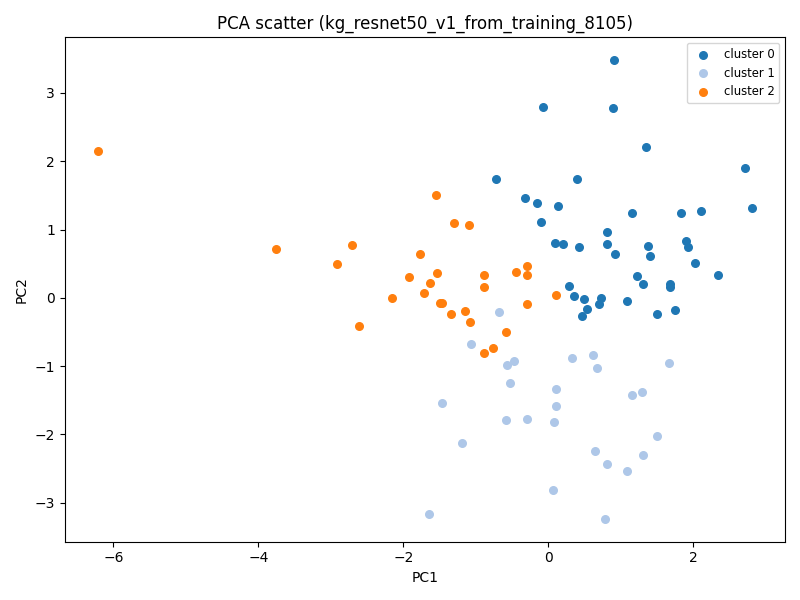

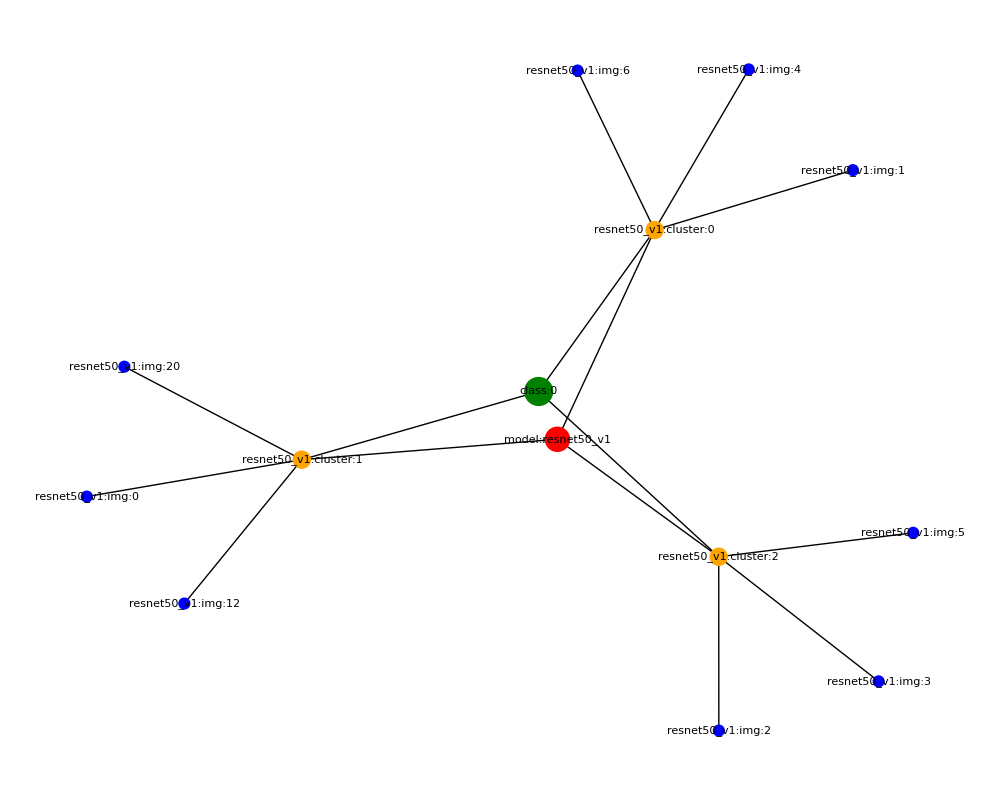


--- kg_resnet50_v1_from_training_8192


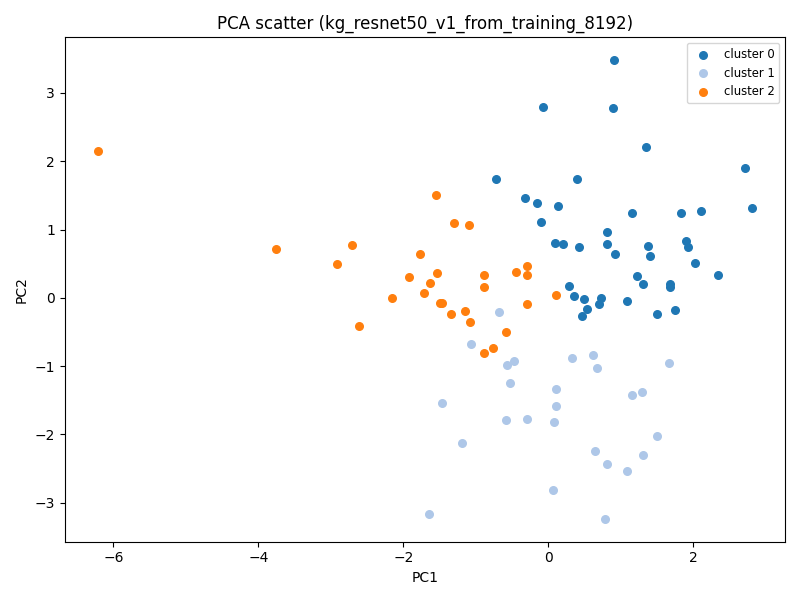

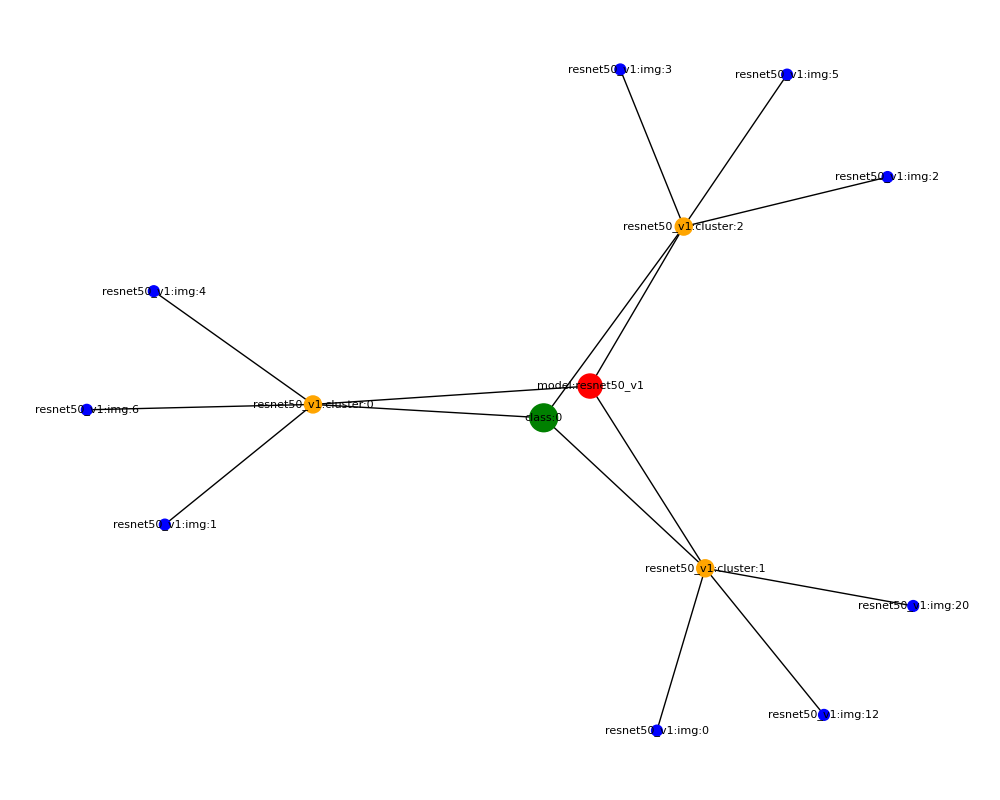


--- kg_resnet50_v1_from_training_8272


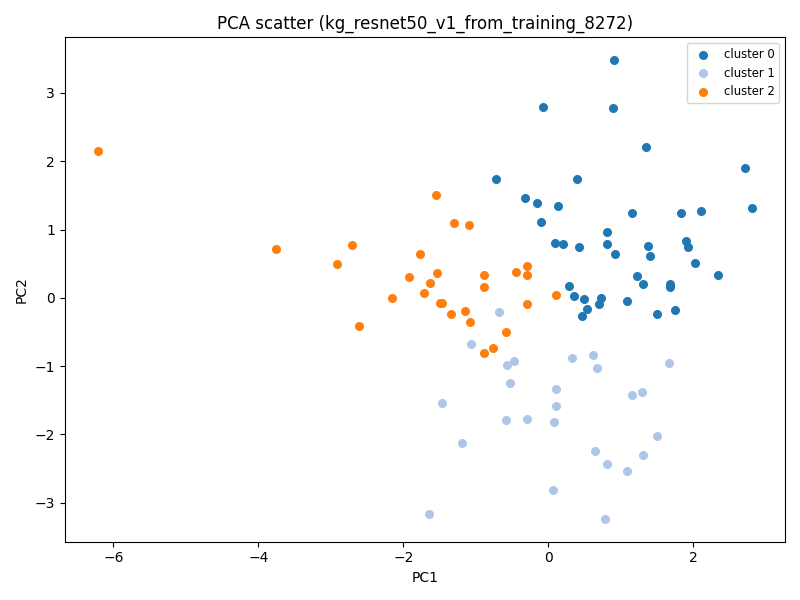

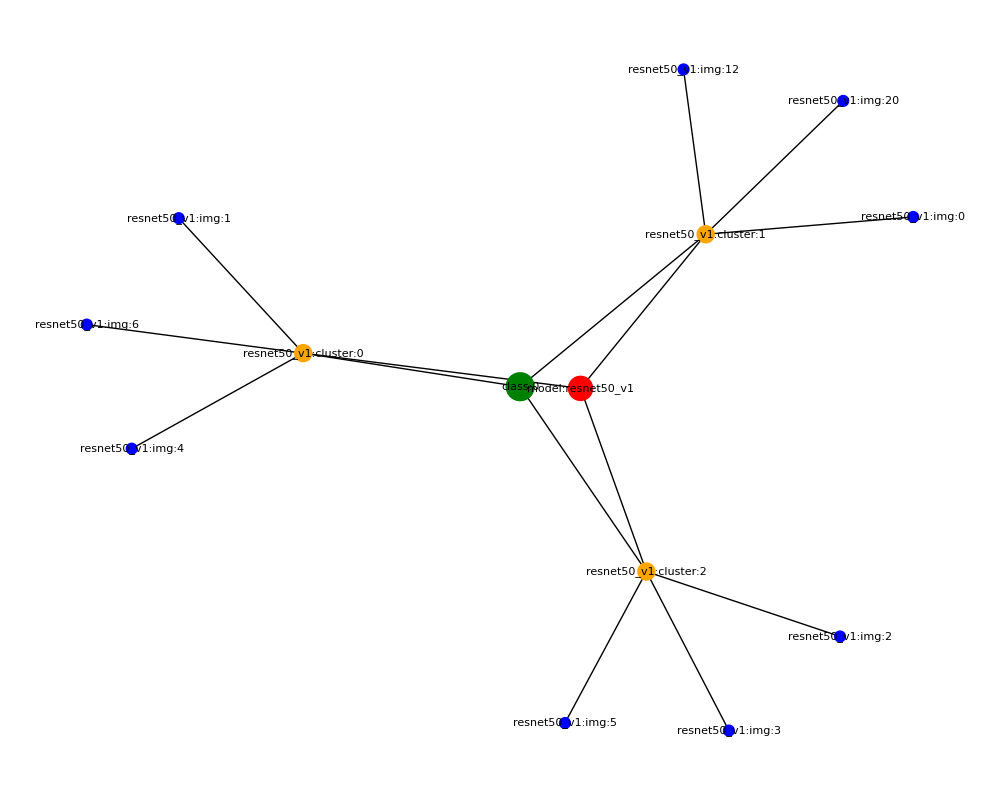


--- kg_resnet50_v2_from_training_8106


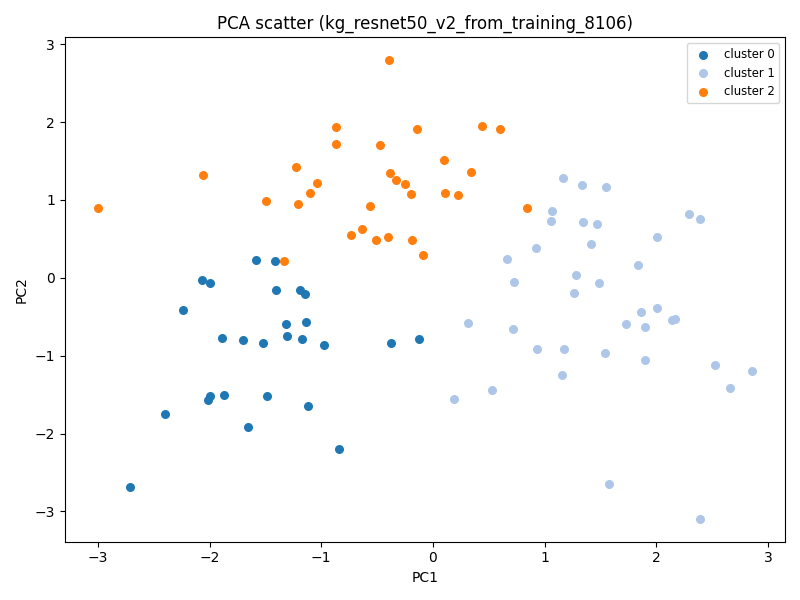

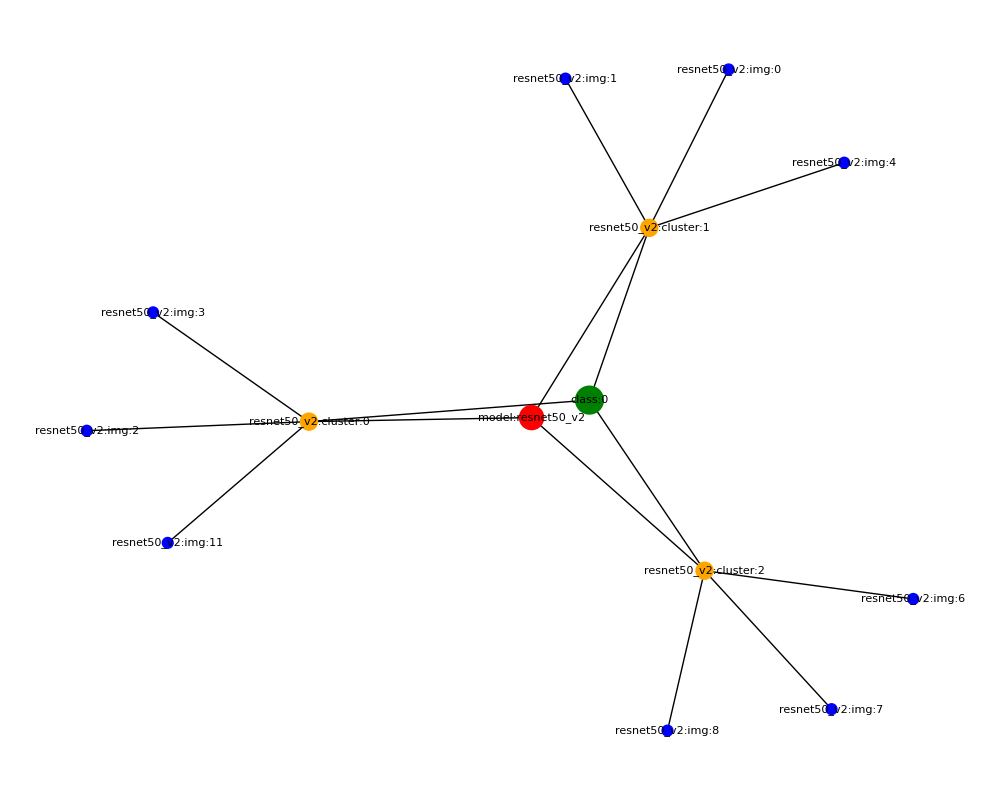


--- kg_resnet50_v2_from_training_8193


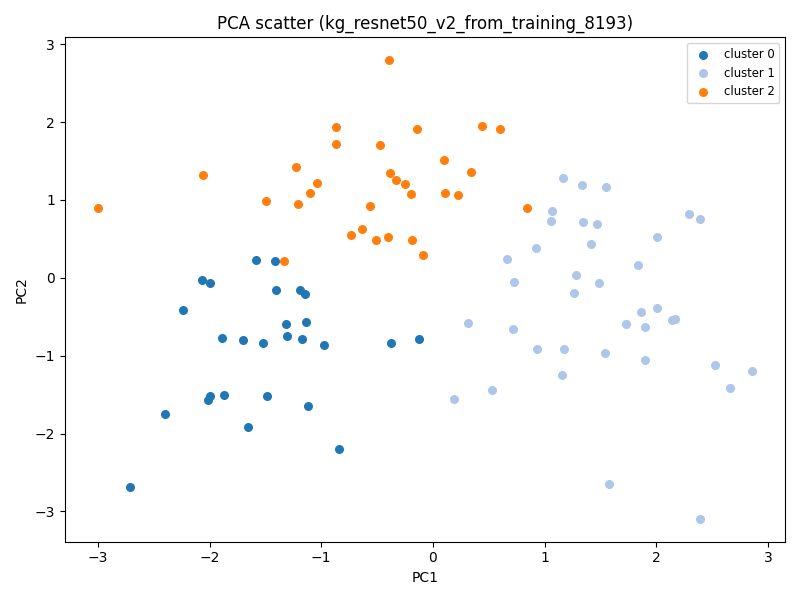

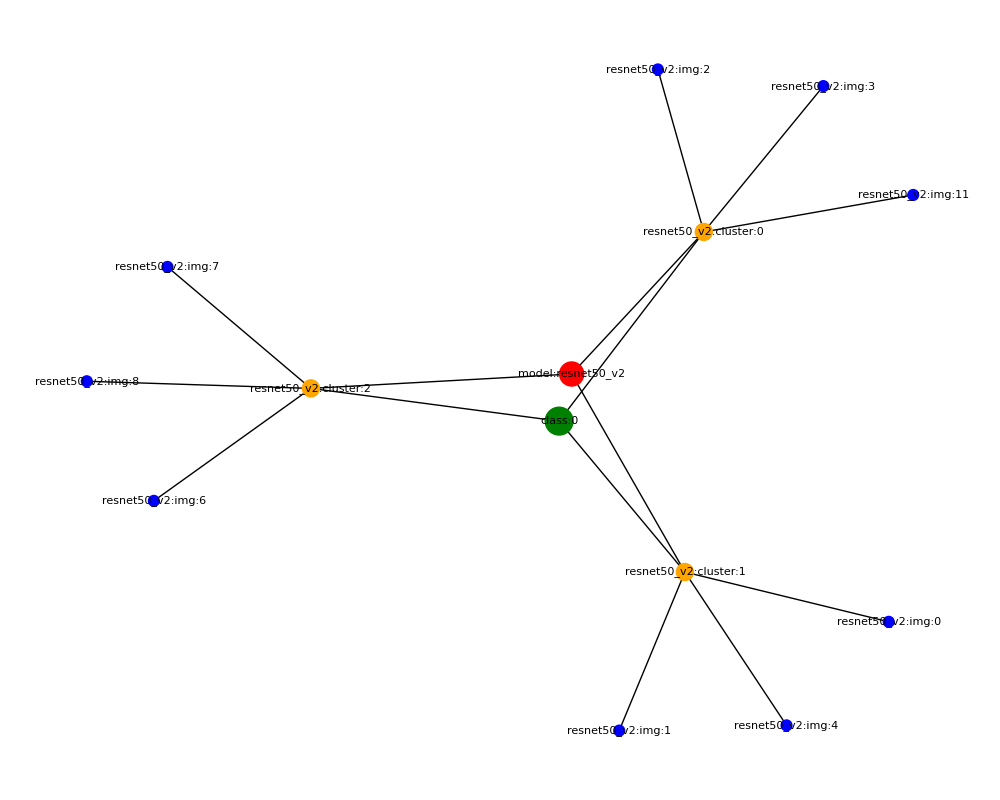


--- kg_resnet50_v2_from_training_8273


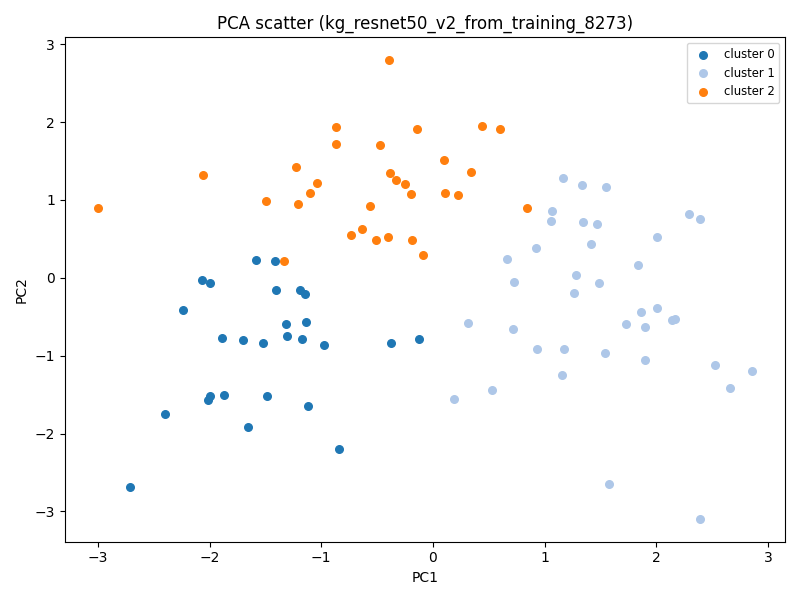

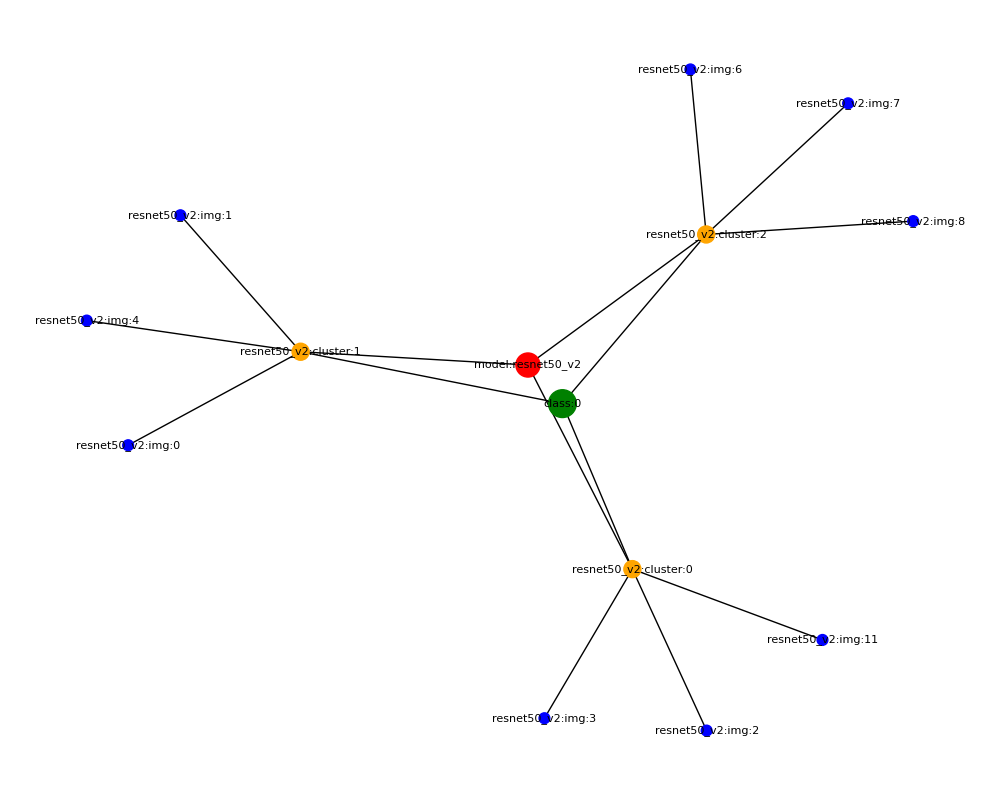


--- kg_shufflenet_v2_from_training_8102


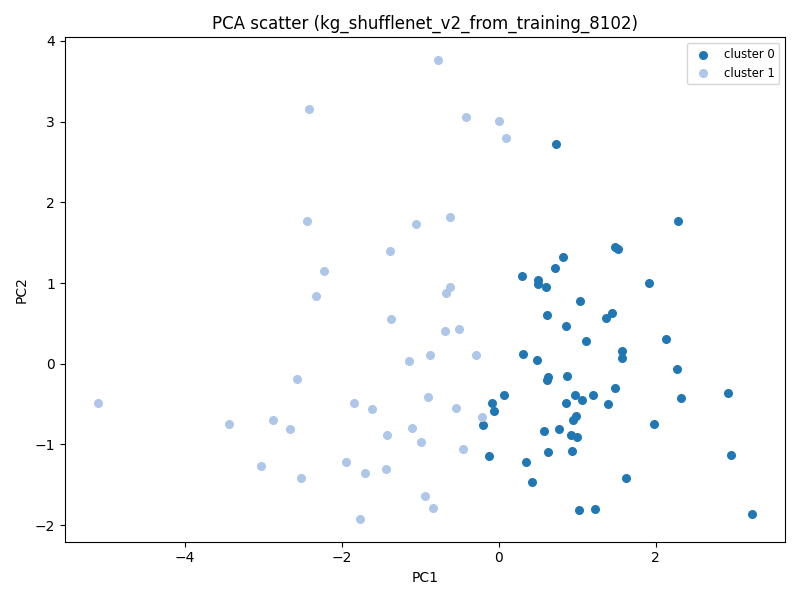

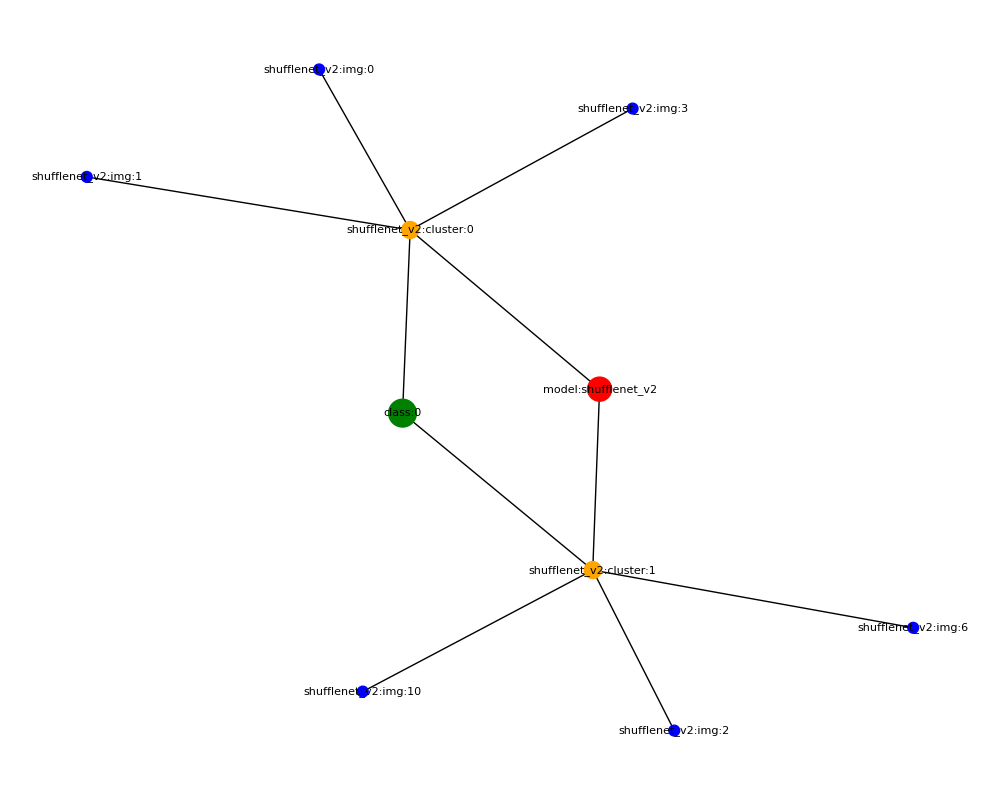


--- kg_shufflenet_v2_from_training_8190


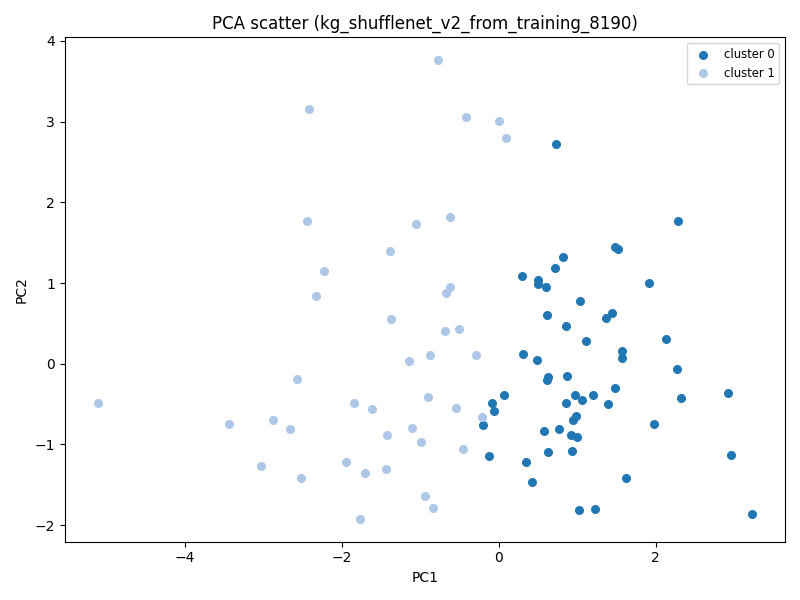

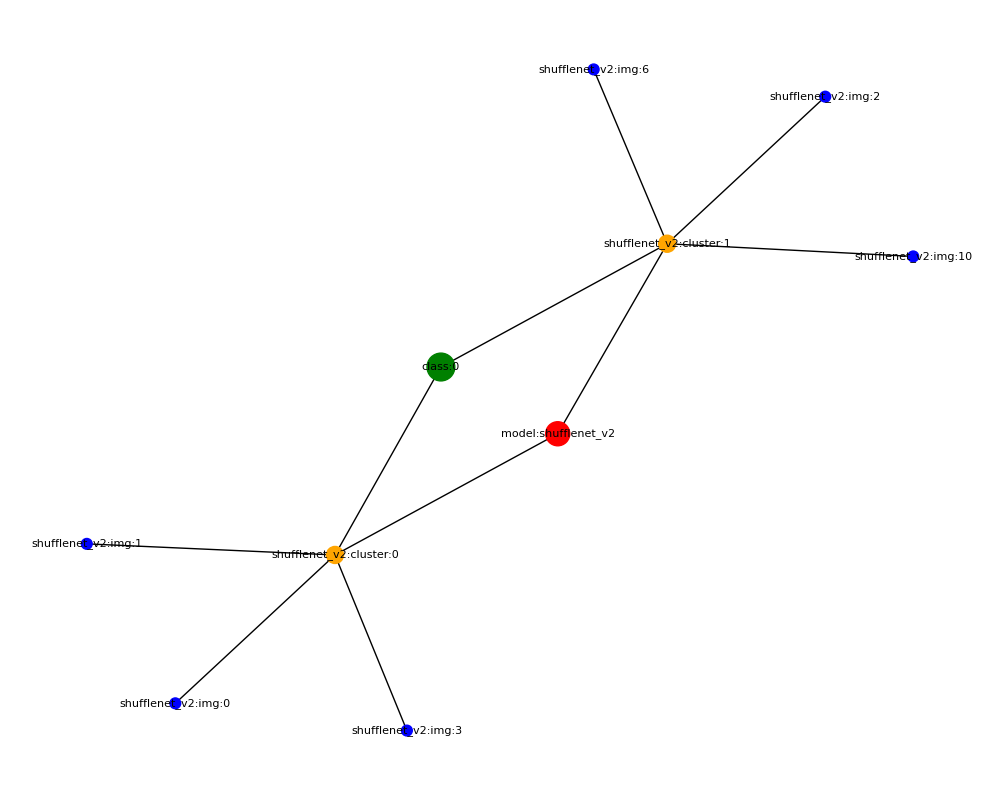


--- kg_shufflenet_v2_from_training_8270


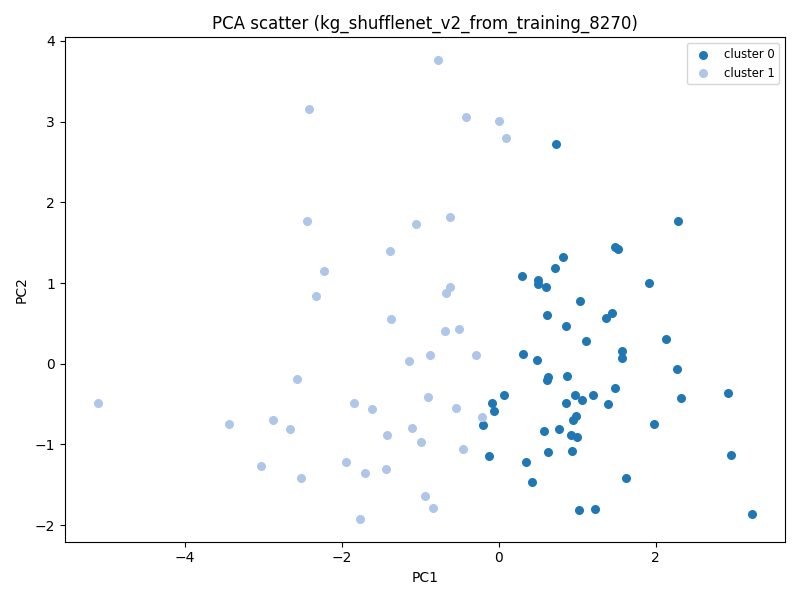

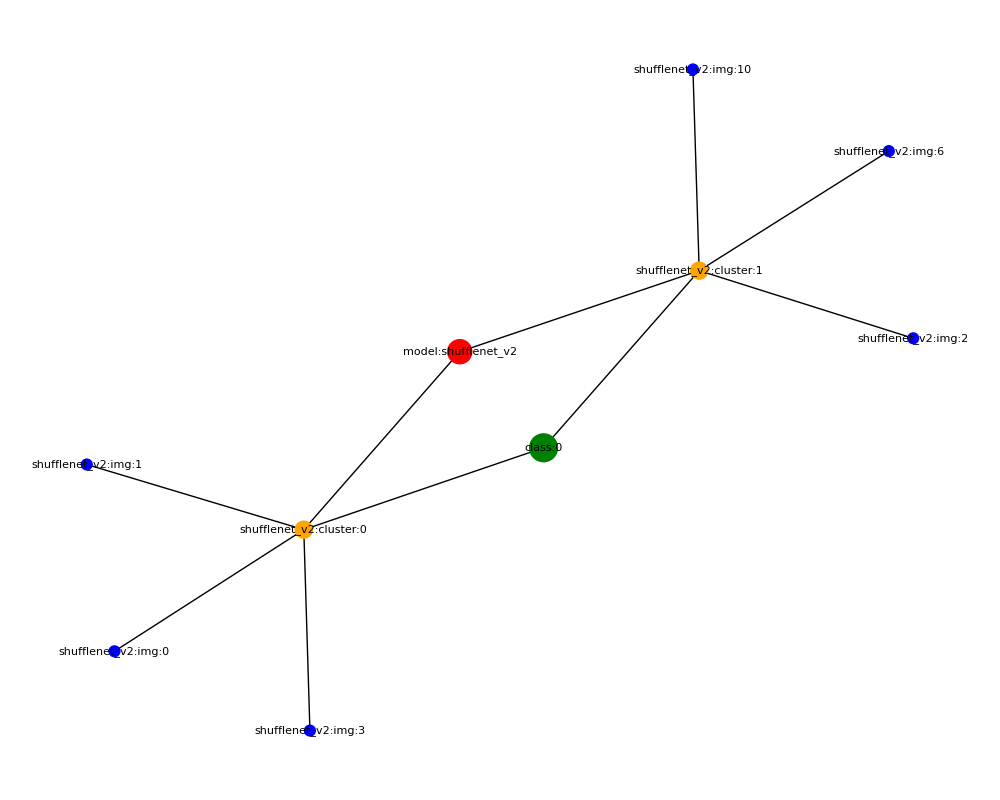


--- kg_squeezenet_from_training_8103


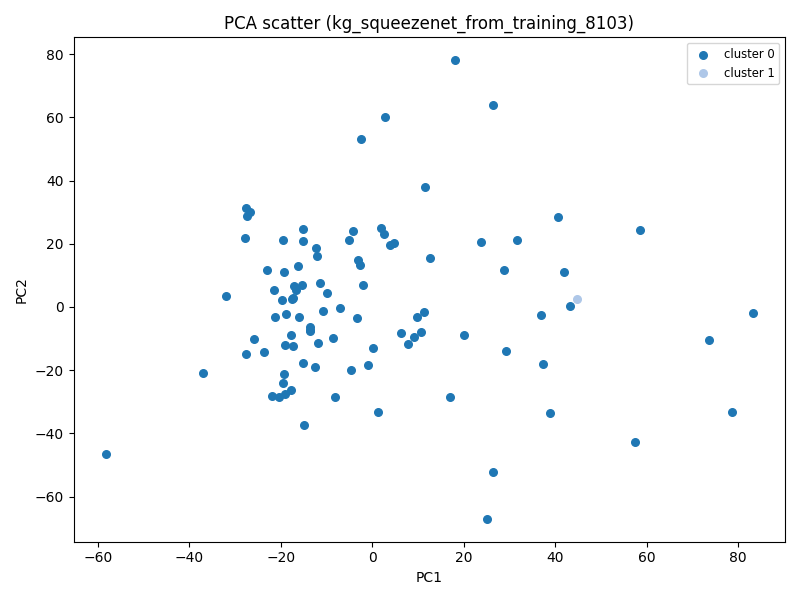

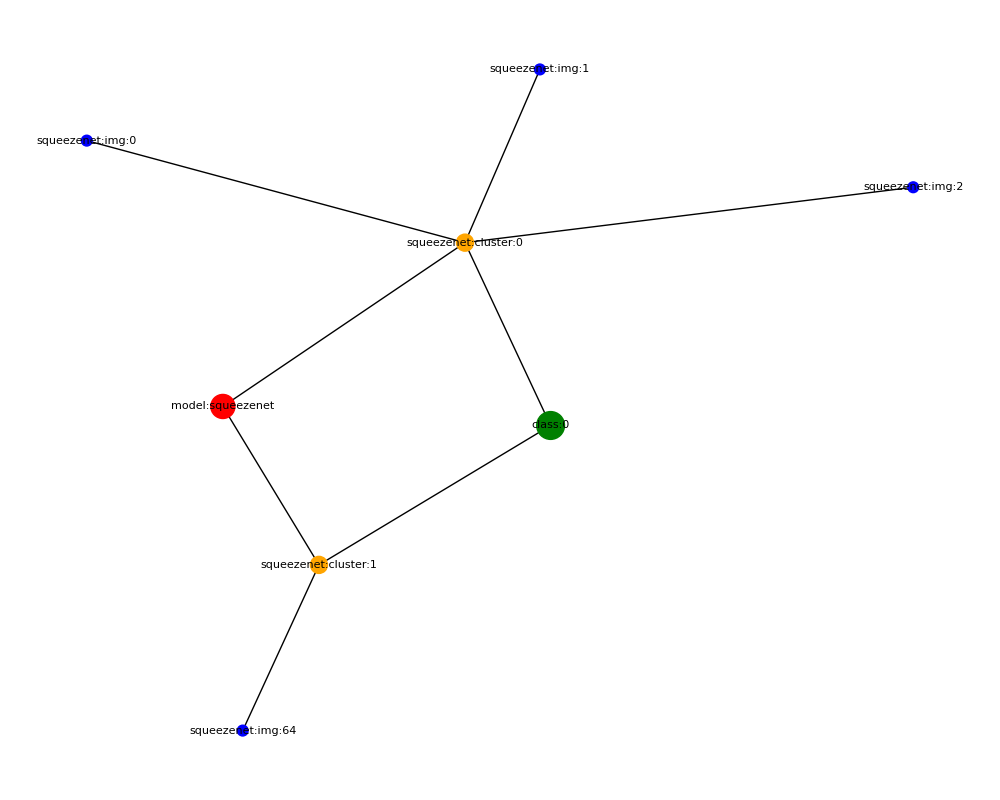


--- kg_squeezenet_from_training_8190


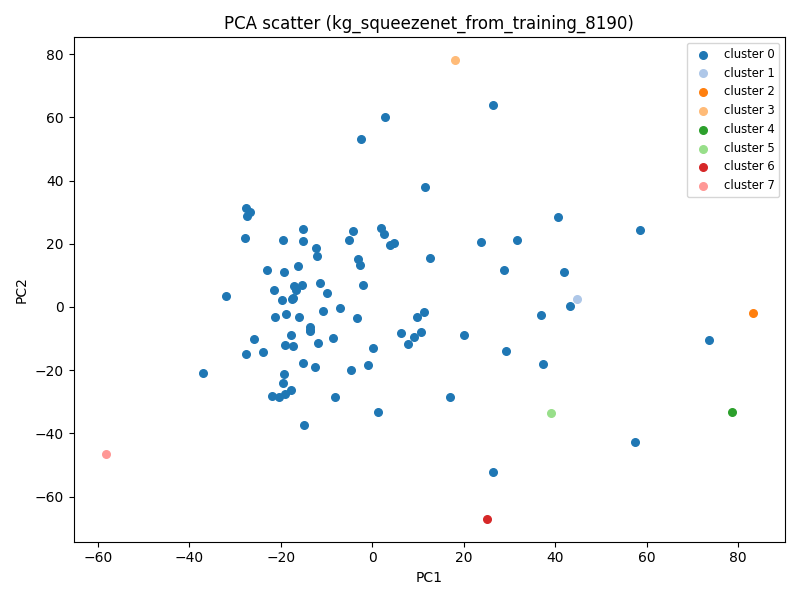

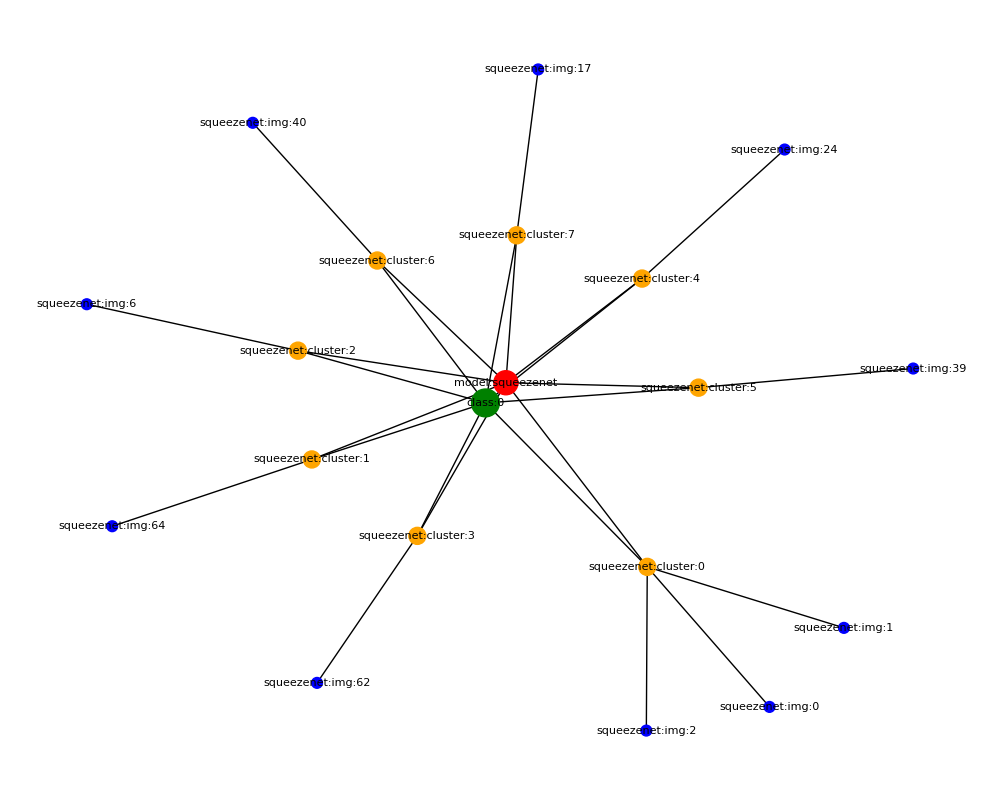


--- kg_squeezenet_from_training_8270


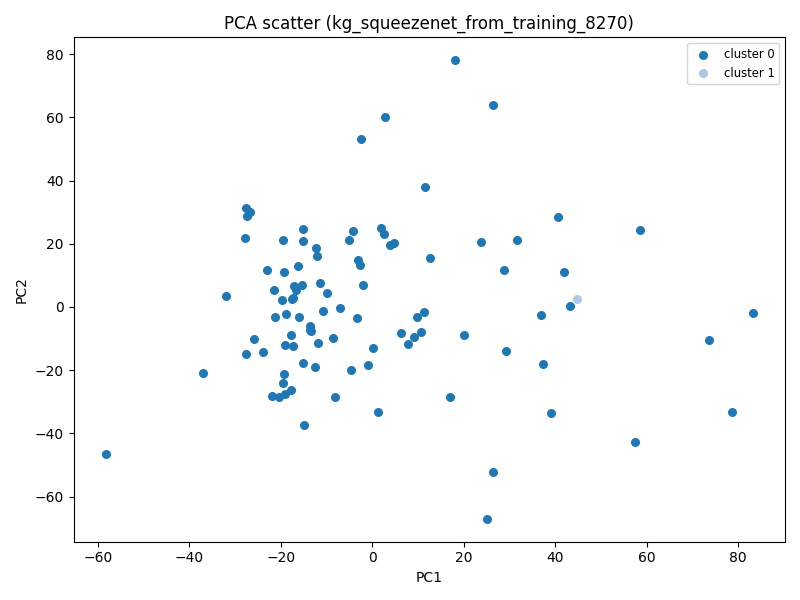

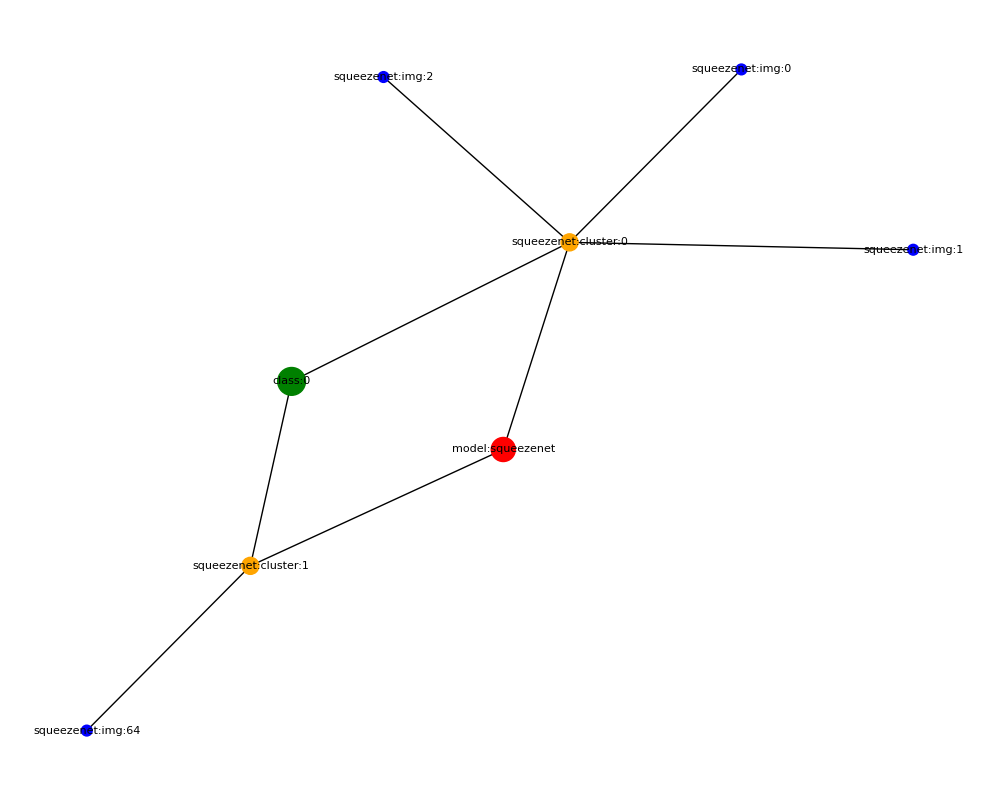


Done.


In [119]:
# Show PCA and network graphs for ALL model-concept KG artifacts

# Discover all prefixes by scanning for *_pca.png files
pca_files = sorted(OUT_DIR.glob('kg_*_from_training_*_pca.png'))
all_prefixes = [p.name.replace('_pca.png', '') for p in pca_files]

if not all_prefixes:
    print('No model-concept KG PCA artifacts found in', OUT_DIR)
else:
    print(f'Found {len(all_prefixes)} KG prefixes; displaying PCA and network PNG for each...')
    for pref in all_prefixes:
        print('\n---', pref)
        p_pca = OUT_DIR / f"{pref}_pca.png"
        p_png = OUT_DIR / f"{pref}.png"
        if p_pca.exists():
            try:
                display(IPyImage(filename=str(p_pca)))
            except Exception as e:
                print('Could not display PCA:', e)
        else:
            print('PCA png missing:', p_pca)
        if p_png.exists():
            try:
                display(IPyImage(filename=str(p_png)))
            except Exception as e:
                print('Could not display network PNG:', e)
        else:
            print('Network png missing:', p_png)
print('\nDone.')